In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

from PIL import Image
import tifffile
import os

from data_loader import image_loader
from data_loader import image_augmentation as aug
from models import double_decoder_cnn

from tqdm.notebook import tqdm
import importlib
import json
import pickle
from datetime import datetime

2022-11-23 17:54:49.140355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 17:54:49.280172: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-23 17:54:49.758478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /srv/data/Apps/hdf5/lib:/usr/local/cuda-11.2/lib64:/srv/data/gcc-11.2.0/libexec/gcc/x86_64-pc-linux-gnu/11.2.0:/srv/data/gcc-11.2.0/lib:/srv/data/gcc-11.2.0/lib32:/srv/data/gcc-11.2.0/lib64:/srv/data/Apps

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as lay
import tensorflow.keras.optimizers as opt
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import model_from_json
# import tensorflow_addons as tfa

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


In [3]:
import tensorboard
tensorboard.__version__

'2.10.1'

In [4]:
print("number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))

number of GPUs available:  1


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3788332777326876838
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23375708160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15575178406687118483
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2022-11-23 17:54:50.497255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 17:54:50.990758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
working_dir = "/group/ag_cmb/mohsen_simtemp/data/xray_tomography/"

#result_dir = "../results/series_21/semi_supervised/"
result_dir = "../outputs/series_23/semi_supervised/"

#name_str = "semisupervised_april_2021_1"
name_str = "semisupervised_may_2021_1"
#name_str = "semisupervised_august_2021_1"

save_figures = True

#trn_dim = 64
#trn_dim = 128
trn_dim = 256
trn_dim_small = 96

test_split_fraction = 0.1

#batch_size = 16
batch_size = 1

# Data preparation

In [8]:
dataset_folder_img_lbl = [working_dir + "raw_training_sets/single_frame/current_dataset"]
dataset_folder_img_img = [working_dir + "raw_training_sets/single_frame/semi_supervised"]

In [9]:
data_generator_img_img = image_loader.ImageLoader(dataset_folders=None, #dataset_folder_img_img,
                                 test_split_fraction=test_split_fraction,
                                 use_labels=False,
                                 image_processing_function=image_loader.image_preprocessing_function,
                                 label_processing_function=None,
                                 use_global_brightness_scaling=False)

513 image files fetched from /group/ag_cmb/mohsen_simtemp/data/xray_tomography/raw_training_sets/single_frame/semi_supervised without labels!
Processing image information...

  0%|          | 0/513 [00:00<?, ?it/s]

done!
Max. image dimensions = 1324
Mean of all brightness values = 0.672528404081366
Standard deviation of all brightness values = 0.13139720674954022
Number of images in the training set: 461
Number of images in the test set: 52


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

In [10]:
data_generator_img_lbl = image_loader.ImageLoader(dataset_folders=None, #dataset_folder_img_lbl,
                                 test_split_fraction=test_split_fraction,
                                 use_labels=True,
                                 image_processing_function=image_loader.image_preprocessing_function,
                                 label_processing_function=image_loader.label_preprocessing_function,
                                 use_global_brightness_scaling=False)

79 image files fetched from /group/ag_cmb/mohsen_simtemp/data/xray_tomography/raw_training_sets/single_frame/current_dataset with corresponding labels!
Processing image information...

  0%|          | 0/79 [00:00<?, ?it/s]

done!
Max. image dimensions = 1324
Mean of all brightness values = 0.6005418720407576
Standard deviation of all brightness values = 0.09422468961977994
Number of images in the training set: 71
Number of images in the test set: 8


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [26]:
# data_generator_img_img.save_to_file(working_dir + "/processed_training_sets/new_dataset_images_" + name_str)
# data_generator_img_lbl.save_to_file(working_dir + "/processed_training_sets/new_dataset_image_labels_" + name_str)

Saving zipped datasets to file...done!
Saving zipped datasets to file...done!


## The datasets with the "new" prefix have been prepared without the global scaling of brightness values

In [13]:
data_generator_img_img.load_from_file(working_dir + "/processed_training_sets/new_dataset_images_" + name_str)
data_generator_img_lbl.load_from_file(working_dir + "/processed_training_sets/new_dataset_image_labels_" + name_str)

Loading zipped datasets from file...done!
Max. image dimensions = 1324
Loading zipped datasets from file...done!
Max. image dimensions = 1324


In [11]:
# print(f"max. dataset size (small) = {len(data_generator_small.trn_img_list)}")
print(f"max. dataset size (image-image) = {len(data_generator_img_img.trn_img_list)}")
print(f"max. dataset size (image-label) = {len(data_generator_img_lbl.trn_img_list)}")

max. dataset size (image-image) = 461
max. dataset size (image-label) = 71


In [11]:
img_value_range = np.amax(data_generator_img_img.trn_img_list) - np.amin(data_generator_img_img.trn_img_list)

print(img_value_range)

75.97349


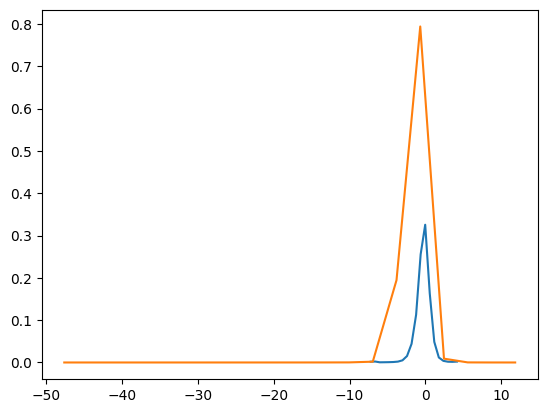

In [12]:
mean_img_img = np.mean(data_generator_img_img.trn_img_list)
std_img_img = np.std(data_generator_img_img.trn_img_list)

mean_img_lbl = np.mean(data_generator_img_lbl.trn_img_list)
std_img_lbl = np.std(data_generator_img_lbl.trn_img_list)


hist, bin_edges = np.histogram(data_generator_img_lbl.test_img_list, bins=20)
hist = hist / np.sum(hist)
plt.plot(bin_edges[:-1], hist)

hist, bin_edges = np.histogram(data_generator_img_img.test_img_list, bins=20)
hist = hist / np.sum(hist)

plt.plot(bin_edges[:-1], hist)

In [13]:
print(mean_img_img, std_img_img)
print(mean_img_lbl, std_img_lbl)

9.211009e-08 0.98560154
-1.925363e-07 0.98518014


In [14]:
# trn_input_small, test_input_small = data_generator_small.get_dataset()
trn_input_img_img, test_input_img_img = data_generator_img_img.get_dataset()
trn_input_img_lbl, test_input_img_lbl = data_generator_img_lbl.get_dataset()

Compiling tensorflow datasets...

2022-11-23 17:55:23.711157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2022-11-23 17:55:23.713357: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3232487744 exceeds 10% of free system memory.
2022-11-23 17:55:25.148749: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3232487744 exceeds 10% of free system memory.
2022-11-23 17:55:25.981791: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3232487744 exceeds 10% of free system memory.
2022-11-23 17:55:27.154851: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3232487744 exceeds 10% of free system memory.


done!
Compiling tensorflow datasets...done!


In [27]:
augmentation_func_img_img = aug.augmentation_function(data_generator_img_img.max_dim, trn_dim,
                                              random_rotation=True,
                                              random_reflection=True,
                                              random_contrast=False)

training_dataset_img_img = trn_input_img_img.\
                    repeat(batch_size).\
                    map(map_func=augmentation_func_img_img).\
                    shuffle(len(trn_input_img_img) * batch_size, reshuffle_each_iteration=True).\
                    batch(batch_size)


test_dataset_img_img = test_input_img_img.\
                    repeat(batch_size).\
                    map(map_func=augmentation_func_img_img).\
                    batch(batch_size)#.prefetch(tf.data.experimental.AUTOTUNE)


augmentation_func_img_lbl = aug.augmentation_function(data_generator_img_lbl.max_dim, trn_dim,
                                              random_rotation=True,
                                              random_reflection=True,
                                              random_contrast=False)

n_equivalent_batches = 6
# n_equivalent_batches = 2

training_dataset_img_lbl = trn_input_img_lbl.\
                    repeat(batch_size * n_equivalent_batches).\
                    map(map_func=augmentation_func_img_lbl).\
                    shuffle(len(trn_input_img_lbl) * batch_size * n_equivalent_batches,
                            reshuffle_each_iteration=True).\
                    batch(batch_size)


test_dataset_img_lbl = test_input_img_lbl.\
                    repeat(batch_size * n_equivalent_batches).\
                    map(map_func=augmentation_func_img_lbl).\
                    batch(batch_size)#.prefetch(tf.data.experimental.AUTOTUNE)

print(training_dataset_img_img.cardinality)
print(training_dataset_img_lbl.cardinality)

<bound method DatasetV2.cardinality of <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>>
<bound method DatasetV2.cardinality of <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>>


-4.31384 3.6618133 -4.31384 3.6618133
-5.9154487 3.811785 -5.9154487 3.811785
-4.4846725 3.1238024 -4.4846725 3.1238024
-2.5439672 2.1445293 -2.5439672 2.1445293
-7.0489993 3.6661212 -7.0489993 3.6661212
-7.2131424 3.15126 -7.2131424 3.15126
-3.4002998 4.0797024 -3.4002998 4.0797024
-4.062705 2.878292 -4.062705 2.878292
-4.4215903 3.0555248 -4.4215903 3.0555248
-14.411358 5.379083 -14.411358 5.379083
-6.6277404 3.376737 -1.0 1.0
-2.755441 3.5314462 -1.0 1.0
-4.2368283 3.3278286 -1.0 1.0
-2.9343026 2.9055195 -1.0 1.0
-3.9532397 2.6108048 -1.0 1.0
-2.5592587 2.536599 -1.0 1.0
-4.283148 2.7355576 -1.0 1.0
-5.1300406 4.2585883 -1.0 1.0
-3.2510989 2.835321 -1.0 1.0
-6.621301 4.4183593 -1.0 1.0


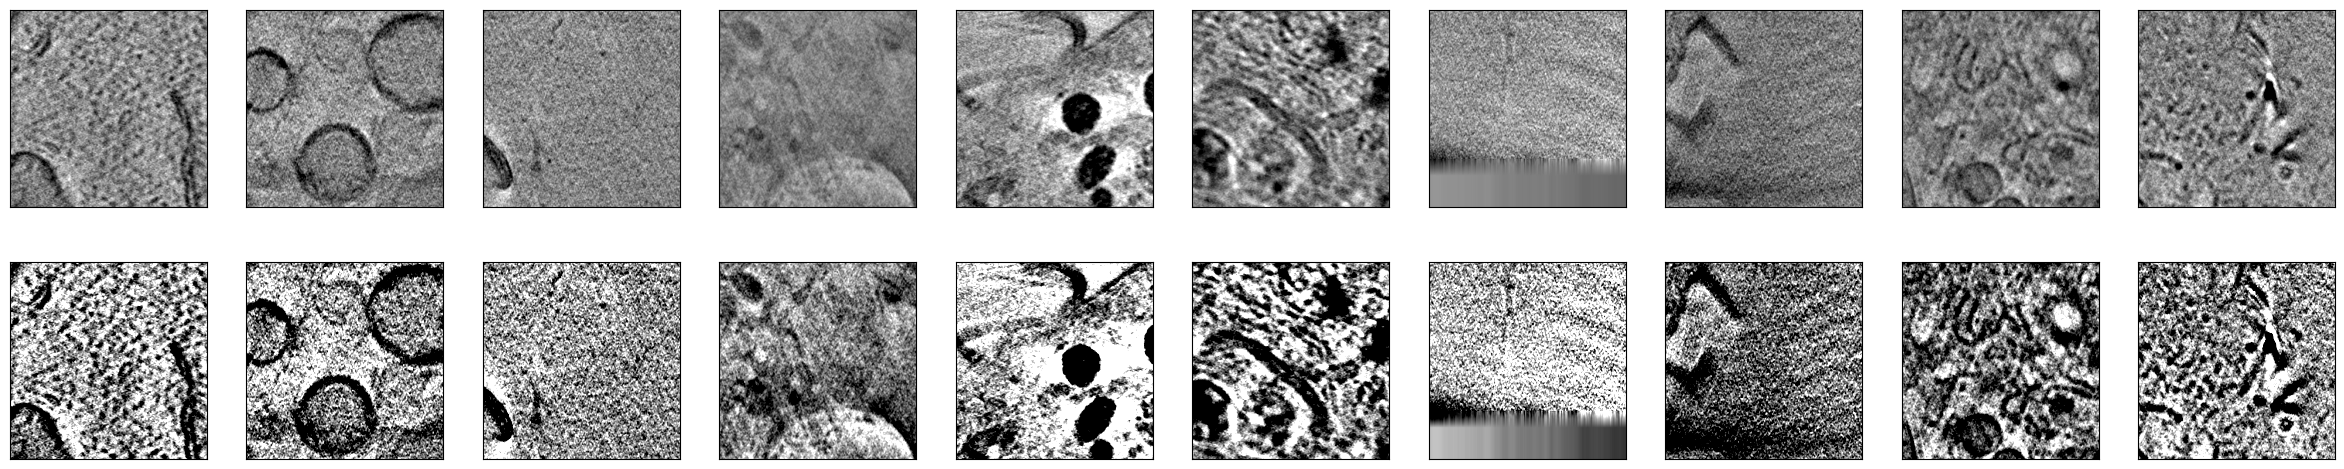

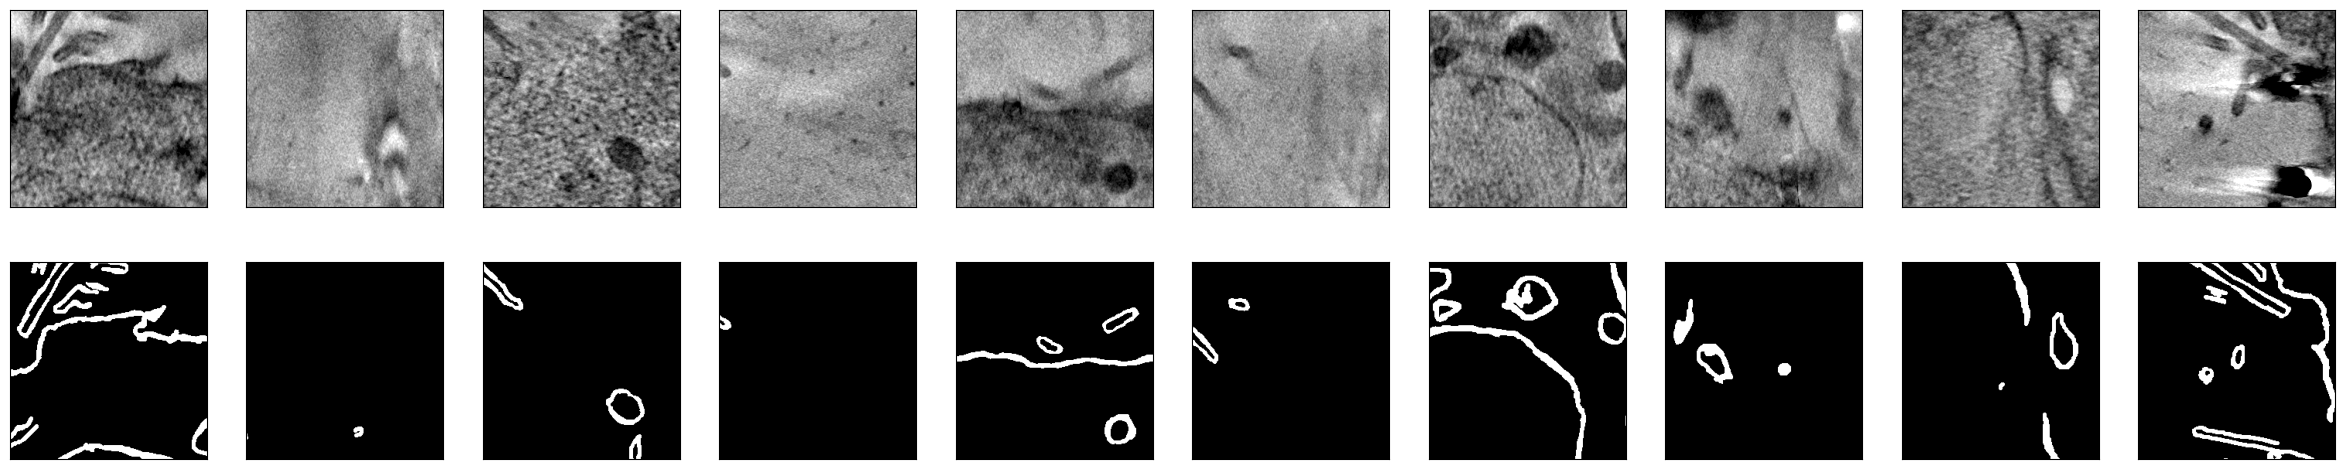

In [16]:
def show_samples(fig, _iter, n_images):
    
    for i in range(n_images):
        img_list, lbl_list = next(_iter)
        img, lbl = img_list[0], lbl_list[0]
        print(np.amin(img), np.amax(img), np.amin(lbl), np.amax(lbl))
        ax = [fig.add_subplot(2, n_images, i + 1), fig.add_subplot(2, n_images, i + n_images + 1)]
        ax[0].imshow (img[:, :, 0], cmap='gray', vmin=-3, vmax=3)
        ax[1].imshow (lbl[:, :, 0], cmap='gray', vmin=-1, vmax=1)
        
        for _ax in ax:
            _ax.tick_params(axis='both', which='both',
                            bottom=False, top=False, left=False, right=False,
                            labelbottom=False, labelleft=False)
        
n_images = 10
_fig_size = (3.0 * n_images, 3.0 * 2)

# fig = plt.figure (figsize=_fig_size)
# show_samples(fig, training_dataset_small.as_numpy_iterator(), n_images)

fig = plt.figure (figsize=_fig_size)
show_samples(fig, test_dataset_img_img.as_numpy_iterator(), n_images)

fig = plt.figure (figsize=_fig_size)
show_samples(fig, test_dataset_img_lbl.as_numpy_iterator(), n_images)

# Network definition

In [21]:
m_f = 64

encoder_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                  'n_stages': 4, 'n_blocks': 1, 'block_depth': 2,
                  'add_instead_of_concat':False,
                  'n_filters': [m_f, m_f, 2 * m_f, 4 * m_f, 8 * m_f],
                  'activation': {'type': 'relu'},
                  'dropout': {'active': False},
                  'batch_norm': {'active': True}}

neck_config = {'kernel_sizes': [1, 2, 3],
               'depth': 4, 'n_filters': 16 * m_f,
               'activation': {'type': 'relu'},
               'dropout': {'active': False},
               'batch_norm': {'active': True}}

decoder_image_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                        'n_stages': 4, 'n_blocks': 1, 'block_depth': 2,
                        'add_instead_of_concat':False,
                        'use_skip_connections': False,
                        'n_filters': [8 * m_f, 4 * m_f, 2 * m_f, m_f, m_f],
                        'activation': {'type': 'relu'},
                        'dropout': {'active': False},
                        'batch_norm': {'active': True}}

decoder_label_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                        'n_stages': 4, 'n_blocks': 2, 'block_depth': 2,
                        'add_instead_of_concat':False,
                        'use_skip_connections': True,
                        'n_filters': [8 * m_f, 4 * m_f, 2 * m_f, m_f, m_f],
                        'activation': {'type': 'relu'},
                        'dropout': {'active': False},
                        'batch_norm': {'active': True}}


model_config = {'pooling': None, 'm_f': m_f, 'add_instead_of_concat_after_neck': False,
                              'encoder': encoder_config,
                              'neck': neck_config,
                              'decoder_image': decoder_image_config,
                              'decoder_label': decoder_label_config}


with open(working_dir + 'saved_cnn_model/model_config_' + name_str + '.json', 'w') as f_conf:
    json.dump(model_config, f_conf, indent=4)

In [22]:
dd_model = double_decoder_cnn.MyDoubleDecoderNet(config=model_config)

#tmp_input = tf.zeros((1, trn_dim, trn_dim, 1))
#tmp_output = dd_model(tmp_input, training=False)

dd_model.build(input_shape=(None, trn_dim, trn_dim, 1))

dd_model.summary ()

skip connections in image decoder: False
skip connections in label decoder: True


/srv/data/miniconda3/envs/TomoDev/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "my_double_decoder_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (MyEncoderBlock)    multiple                  2286240   
                                                                 
 mid_branch_0 (MyMidBranchBl  multiple                 5259264   
 ock)                                                            
                                                                 
 mid_branch_1 (MyMidBranchBl  multiple                 8404992   
 ock)                                                            
                                                                 
 mid_branch_2 (MyMidBranchBl  multiple                 13647872  
 ock)                                                            
                                                                 
 image_decoder (MyDecoderBlo  multiple                 19543488  
 ck)                                         

## Saving/loading network weights

In [23]:
save_model = False
load_model = True

In [24]:
if load_model:
    dd_model.load_weights(working_dir + 'saved_cnn_model/weights_' + name_str + '.h5')

## Training

In [18]:
def image_reconstruction_loss(input_img, y_true, y_pred):
    
    alpha = 0.5
    
    return alpha * (tf.math.reduce_sum(1.0 - tf.image.ssim(input_img, y_pred[0],
                                                           img_value_range, filter_size=11, filter_sigma=1.5,
                                                           k1=0.01, k2=0.03), axis=0)) +\
            (1.0 - alpha) * tf.keras.losses.Huber(delta=0.1)(input_img, y_pred[0]) +\
            tf.keras.losses.MeanSquaredError()(y_pred[1], y_pred[1])

def label_loss(input_img, y_true, y_pred):
    
    alpha = 0.99
    
    return (1.0 - alpha) * tf.keras.losses.Huber(delta=0.1)(input_img, y_pred[0]) +\
           alpha * tf.keras.losses.Huber(delta=0.1)(y_true, y_pred[1])  

def label_only_loss(input_img, y_true, y_pred):
    
    return tf.keras.losses.Huber(delta=0.1)(y_true, y_pred[1]) +\
           tf.keras.losses.MeanSquaredError()(y_pred[0], y_pred[0])

def label_accuracy_function(label, prediction):

    prediction = tf.clip_by_value(0.5 * (prediction[1] + tf.ones_like(prediction[1])), 0.0, 1.0)
    label = tf.clip_by_value(0.5 * (label + tf.ones_like(label)), 0.0, 1.0)
    
    num_of_pixels = tf.reduce_sum(tf.ones_like(label))
    num_of_correct_pixels = tf.reduce_sum(
        tf.cast(tf.math.less_equal(tf.abs(label - prediction), 0.01 * tf.ones_like(label)), dtype=tf.float32))
                                                         
    #pred_score = 1.0 - tf.norm(label - prediction, 1) / (1.0e-6 + tf.norm(label, 1))
    pred_score = num_of_correct_pixels / num_of_pixels
    
    return tf.clip_by_value(pred_score, 0.0, 1.0)

def comprehensive_label_accuracy_function(label, prediction):
    
    tol = 1.0e-3
    
    _prediction = np.squeeze(prediction[1].numpy())
    _label = np.squeeze(label.numpy())
    
    total_num_of_pixels = np.prod(_label.shape)
    
    _prediction_positive = (_prediction > 0.9).astype(np.float64)
    _label_positive = (_label > 0.9).astype(np.float64)

    _prediction_negative = (_prediction < -0.9).astype(np.float64)
    _label_negative = (_label < -0.9).astype(np.float64)
    
    true_positive = (_prediction_positive * _label_positive).astype(np.float64)
    true_negative = (_prediction_negative * _label_negative).astype(np.float64)

    false_positive = (_prediction_positive * _label_negative).astype(np.float64)
    false_negative = (_prediction_negative * _label_positive).astype(np.float64)
    
    num_true_positive = np.sum (true_positive)
    num_true_negative = np.sum (true_negative)
    
    num_false_positive = np.sum (false_positive)
    num_false_negative = np.sum (false_negative)
    
#     num_all_positive = np.sum (_prediction_positive)
#     num_all_negative = np.sum (_prediction_negative)
        
#     num_original_positive = np.sum (_label_positive)
#     num_original_negative = np.sum (_label_negative)
    
    accuracy = (num_true_positive + num_true_negative) / total_num_of_pixels
    
    precision = num_true_positive / (num_true_positive + num_false_positive + 1.0e-16)
    recall = num_true_positive / (num_true_positive + num_false_negative + 1.0e-16)
    
    F1_score = 2.0 * num_true_positive / (2.0 * num_true_positive + num_false_positive + num_false_negative + 1.0e-16)
    
    return accuracy, precision, recall, F1_score

def image_accuracy_function(label, prediction):

    #prediction = tf.clip_by_value(0.5 * (prediction[0] + tf.ones_like(prediction[1])), 0.0, 1.0)
    #label = tf.clip_by_value(0.5 * (label + tf.ones_like(label)), 0.0, 1.0)

    num_of_pixels = tf.reduce_sum(tf.ones_like(label))
    num_of_correct_pixels = tf.reduce_sum(
        tf.cast(tf.math.less_equal(tf.abs(label - prediction[0]), tf.ones_like(label) * tf.math.reduce_std(label)), dtype=tf.float32))

    #pred_score = 1.0 - tf.norm(label - prediction, 1) / tf.norm(label, 1)
    pred_score = num_of_correct_pixels / num_of_pixels

    return tf.clip_by_value(pred_score, 0.0, 1.0)

In [23]:
class MyDoubleTrainer:
    def __init__(self, model, training_dataset, test_dataset, learning_rate=5.0e-5,
                 optimizer=None, loss_function=None, accuracy_function=None, extended_accuracy_function=None):

        self.model = model
        self.training_dataset = training_dataset
        self.test_dataset = test_dataset

        if optimizer is None:
#             optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        self.optimizer = optimizer
        self.loss_function = loss_function
        self.accuracy_function = accuracy_function

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')
        
        self.extended_accuaracy_function = extended_accuracy_function

        self.epoch = None
        self.train_loss_list, self.test_loss_list = None, None
        self.train_accuracy_list, self.test_accuracy_list = None, None

        self.reset_training_loop()

    @tf.function
    def __train_step(self, images, labels):

        with tf.GradientTape() as tape:
            predictions = self.model(images, training=True)
            loss = self.loss_function(images, labels, predictions)
            accuracy = self.accuracy_function(labels, predictions)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(accuracy)

    @tf.function
    def __test_step(self, images, labels):
        predictions = self.model(images, training=False)

        loss = self.loss_function(images, labels, predictions)
        accuracy = self.accuracy_function(labels, predictions)

        self.test_loss(loss)
        self.test_accuracy(accuracy)

    def reset_training_loop(self):

        self.epoch = 0
        self.train_loss_list = []
        self.test_loss_list = []
        self.train_accuracy_list = []
        self.test_accuracy_list = []

    def estimate_extended_accuracy(self):

        self.test_loss.reset_states()
        self.test_accuracy.reset_states()
        
        loss_list = []
        accuracy_list = []
        
        for test_images, test_labels in self.test_dataset:

            test_predictions = self.model(test_images, training=False)

            accuracy_list.append(self.extended_accuaracy_function (test_labels, test_predictions))

        accuracy_list = np.array(accuracy_list)
        
        print(f"Test Accuracy:")
        print(np.mean (accuracy_list, axis=0))

        return np.mean (accuracy_list, axis=0), np.std (accuracy_list, axis=0)

    def one_epoch(self):

        self.train_loss.reset_states()
        self.train_accuracy.reset_states()

        self.test_loss.reset_states()
        self.test_accuracy.reset_states()
        
        for images, labels in tqdm(self.training_dataset):
            self.__train_step(images, labels)

        for test_images, test_labels in tqdm(self.test_dataset):
            self.__test_step(test_images, test_labels)
        
        self.epoch += 1
                
        template = 'Epoch {}, Loss: {:5.4f}, Accuracy: {:5.2f}%, Test Loss: {:5.4f}, Test Accuracy: {:5.2f}%'

        print(template.format(self.epoch,
                                self.train_loss.result(),
                                self.train_accuracy.result() * 100.0,
                                self.test_loss.result(),
                                self.test_accuracy.result() * 100.0))

        self.train_loss_list.append(self.train_loss.result())
        self.train_accuracy_list.append(self.train_accuracy.result())

        self.test_loss_list.append(self.test_loss.result())
        self.test_accuracy_list.append(self.test_accuracy.result())



In [111]:
image_trainer = MyDoubleTrainer(model=dd_model,
                                 training_dataset=training_dataset_img_img,
                                 test_dataset=test_dataset_img_img,
                                 loss_function=image_reconstruction_loss,
                                 accuracy_function=image_accuracy_function,
                                 extended_accuracy_function=None)

label_trainer = MyDoubleTrainer(model=dd_model,
                                training_dataset=training_dataset_img_lbl,
                                test_dataset=test_dataset_img_lbl,
                                loss_function=label_loss,
                                accuracy_function=label_accuracy_function,
                                extended_accuracy_function=comprehensive_label_accuracy_function)


In [29]:
image_trainer.reset_training_loop()
label_trainer.reset_training_loop()

In [30]:
if load_model:
    dat = np.load(working_dir + 'saved_cnn_model/loss_' + name_str + '.npz')
    
    image_trainer.train_loss_list, image_trainer.test_loss_list = dat["arr_0"].tolist(), dat["arr_1"].tolist()
    label_trainer.train_loss_list, label_trainer.test_loss_list = dat["arr_2"].tolist(), dat["arr_3"].tolist()
    label_trainer.train_accuracy_list, label_trainer.test_accuracy_list = dat["arr_4"].tolist(), dat["arr_5"].tolist()

In [33]:
label_trainer.estimate_extended_accuracy ()

  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96440188 0.59429615 0.48749935 0.51933756]


(array([0.96440188, 0.59429615, 0.48749935, 0.51933756]),
 array([0.02629193, 0.34875405, 0.30091392, 0.30610732]))

In [361]:
score_list = []

for i in range(20):
    score_list.append(label_trainer.estimate_extended_accuracy ()[0])

score_list = np.array (score_list)

  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96706963 0.68344832 0.60735804 0.61416029]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96794097 0.62326291 0.57839828 0.5831695 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.97077052 0.60637254 0.53057428 0.5435796 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96991889 0.52863239 0.53095064 0.50862723]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96411292 0.6233989  0.62075469 0.5938187 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96909587 0.60917272 0.55414447 0.55572094]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96228091 0.65130636 0.56442508 0.57917568]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96252314 0.66174519 0.61470261 0.61220905]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96734015 0.50785049 0.47435185 0.47213391]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.95922629 0.6233961  0.62312421 0.60408441]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.9659462  0.53081947 0.51279663 0.50063076]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96148173 0.70401396 0.62217848 0.65089131]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96118482 0.65966886 0.5980451  0.60504991]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96659597 0.62537593 0.53747016 0.56829866]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96865527 0.5914532  0.53084706 0.53946403]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96641191 0.61631285 0.5775602  0.56915908]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96916739 0.63008117 0.53498827 0.55263807]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.96486537 0.61113677 0.56045614 0.56634342]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.97044881 0.55037507 0.51397052 0.51002509]


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.9622968  0.64604557 0.53779703 0.56644261]


In [362]:
print (np.mean(score_list, axis=0))

[0.96586668 0.61419344 0.56124469 0.56478111]


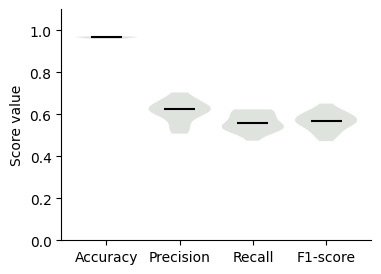

In [363]:
fig = plt.figure(figsize=(4, 3))

ax = fig.add_subplot ()

parts = ax.violinplot(dataset=score_list, positions=None, points=2000, widths=0.85,
                     showmeans=False, showextrema=False, showmedians=True, bw_method='silverman')


ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-score'])
ax.set_ylabel(r"Score value")
ax.set_ylim(0.0, 1.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for pc in parts['bodies']:
    pc.set_facecolor('xkcd:light gray')
    pc.set_edgecolor('none')
    pc.set_alpha(0.8)
    
for pc in [parts['cmedians']]:#, parts['cbars'], parts['cmins'], parts['cmaxes']]:
    pc.set_colors('xkcd:black')
    pc.set_linewidth(1.5)


# if save_figures:
#     fig.savefig(result_dir + 'test_scores.pdf',
#             format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

In [20]:
def show_image_results (model, n_results):
    
    fig, ax = plt.subplots(n_results, 4, figsize = (24, n_results * 6.0), gridspec_kw={'wspace':0.1, 'hspace':0.1})

    for i, (img, lbl) in zip(range(n_results), test_dataset_img_lbl):

        output = model(img, training=False)

        gen_image_test = output[0].numpy()
        predicted_label_test = output[1].numpy()

        ind = 0

        ax[i, 0].imshow (img[ind, :, :, 0], cmap='gray', interpolation='nearest')

        ax[i, 1].imshow (lbl[ind, :, :, 0], cmap='hot', interpolation='nearest', vmin=-1.0, vmax=1.0)

        ax[i, 2].imshow (gen_image_test[ind, :, :, 0], cmap='gray', interpolation='nearest')

        ax[i, 3].imshow (predicted_label_test[ind, :, :, 0], cmap='hot', interpolation='nearest', vmin=-1.0, vmax=1.0)

        if i == 0:
            ax[i, 0].set_title("original slide", fontsize=22)
            ax[i, 1].set_title("manual label", fontsize=22)
            ax[i, 2].set_title("gen. image", fontsize=22)
            ax[i, 3].set_title("predicted label", fontsize=22)

        for j in range(4):
            ax[i, j].tick_params(
                axis='both',
                which='both',
                bottom=False,     
                top=False, 
                left=False,
                right=False,
                labelbottom=False,
                labelleft=False)

In [21]:
def accuracy_objective (m_f, n_epochs, lr, n_samples, train_image_restoration=True):
    
    report = {}
    
    report["m_f"] = m_f
    report["lr"] = lr
    report["n_epochs"] = n_epochs
    report["train_image_restoration"] = train_image_restoration

    tf.keras.backend.clear_session()
    
    encoder_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                      'n_stages': 4, 'n_blocks': 1, 'block_depth': 2,
                      'add_instead_of_concat':False,
                      'n_filters': [m_f, m_f, 2 * m_f, 4 * m_f, 8 * m_f],
                      'activation': {'type': 'relu'},
                      'dropout': {'active': False},
                      'batch_norm': {'active': True}}

    neck_config = {'kernel_sizes': [1, 2, 3],
                   'depth': 4, 'n_filters': 16 * m_f,
                   'activation': {'type': 'relu'},
                   'dropout': {'active': False},
                   'batch_norm': {'active': True}}

    decoder_image_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                            'n_stages': 4, 'n_blocks': 1, 'block_depth': 2,
                            'add_instead_of_concat':False,
                            'use_skip_connections': False,
                            'n_filters': [8 * m_f, 4 * m_f, 2 * m_f, m_f, m_f],
                            'activation': {'type': 'relu'},
                            'dropout': {'active': False},
                            'batch_norm': {'active': True}}

    decoder_label_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                            'n_stages': 4, 'n_blocks': 2, 'block_depth': 2,
                            'add_instead_of_concat':False,
                            'use_skip_connections': True,
                            'n_filters': [8 * m_f, 4 * m_f, 2 * m_f, m_f, m_f],
                            'activation': {'type': 'relu'},
                            'dropout': {'active': False},
                            'batch_norm': {'active': True}}


    model_config = {'pooling': None, 'm_f': m_f, 'add_instead_of_concat_after_neck': False,
                                  'encoder': encoder_config,
                                  'neck': neck_config,
                                  'decoder_image': decoder_image_config,
                                  'decoder_label': decoder_label_config}
    
    _model = double_decoder_cnn.MyDoubleDecoderNet(config=model_config)

    _model.build(input_shape=(None, trn_dim, trn_dim, 1))

    
    report["total_n_params"] = 0
    
    for _var in _model.trainable_weights:
        report["total_n_params"] += np.prod(_var.shape)
    
    print(f"total number of parameters = {report['total_n_params']}")
    
    _image_trainer = MyDoubleTrainer(model=_model, learning_rate=lr,
                                 training_dataset=training_dataset_img_img,
                                 test_dataset=test_dataset_img_img,
                                 loss_function=image_reconstruction_loss,
                                 accuracy_function=image_accuracy_function,
                                 extended_accuracy_function=None)

    _label_trainer = MyDoubleTrainer(model=_model, learning_rate=lr,
                                    training_dataset=training_dataset_img_lbl,
                                    test_dataset=test_dataset_img_lbl,
                                    loss_function=label_only_loss,
                                    accuracy_function=label_accuracy_function,
                                    extended_accuracy_function=comprehensive_label_accuracy_function)
    
    _image_trainer.reset_training_loop()
    _label_trainer.reset_training_loop()
    
    report["scores_mean"] = []
    report["scores_std"] = []
    
    for epoch in range(n_epochs):
        
        _label_trainer.one_epoch()
        
        if train_image_restoration:
            _image_trainer.one_epoch()
        
        score_sample = []
        
        for i in range(n_samples):
            
            score_sample.append(_label_trainer.estimate_extended_accuracy ()[0])
            
        report["scores_mean"].append(np.mean(score_sample, axis = 0))
        report["scores_std"].append(np.std(score_sample, axis = 0))
        
    report["loss_training"] = np.array(_label_trainer.train_loss_list)
    report["loss_test"] = np.array(_label_trainer.test_loss_list)
    
    show_image_results(_model, 2)
    
    return report

In [ ]:
full_report = []

_m_f = 64
_lr = 1.0e-4

for train_image_restoration in [False, True]:

    full_report.append(accuracy_objective (m_f=_m_f, n_epochs=100, n_samples=10,
                                           lr=_lr, train_image_restoration=train_image_restoration))

skip connections in image decoder: False
skip connections in label decoder: True
total number of parameters = 76483502


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0152, Accuracy: 88.07%, Test Loss: 0.0833, Test Accuracy: 56.93%
Test Accuracy:
[0.61566289 0.07549106 0.68414931 0.12920001]
Test Accuracy:
[0.60662683 0.08157888 0.77547089 0.14276232]
Test Accuracy:
[0.61948395 0.09016176 0.77602921 0.15718633]
Test Accuracy:
[0.64122931 0.09252156 0.73276076 0.1592107 ]
Test Accuracy:
[0.65778224 0.06473861 0.67364515 0.11600223]
Test Accuracy:
[0.60646121 0.0685452  0.73391287 0.12167681]
Test Accuracy:
[0.58650875 0.07880116 0.79058141 0.13905607]
Test Accuracy:
[0.62177722 0.09422341 0.76534254 0.16306261]
Test Accuracy:
[0.59133403 0.09014514 0.73683209 0.15229641]
Test Accuracy:
[0.59759744 0.08613749 0.75912723 0.1501481 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0097, Accuracy: 93.89%, Test Loss: 0.0099, Test Accuracy: 94.79%
Test Accuracy:
[0.95363776 0.34273587 0.1477403  0.17532048]
Test Accuracy:
[0.94652875 0.36728691 0.1590278  0.19198382]
Test Accuracy:
[0.95346196 0.3821303  0.1845113  0.22712793]
Test Accuracy:
[0.95109717 0.38176317 0.16205102 0.18654088]
Test Accuracy:
[0.95344035 0.41409895 0.19244255 0.2301612 ]
Test Accuracy:
[0.94809373 0.38090691 0.16593571 0.20965704]
Test Accuracy:
[0.96302414 0.35882659 0.15508174 0.19517879]
Test Accuracy:
[0.94400469 0.42772855 0.2030362  0.23290802]
Test Accuracy:
[0.96176275 0.30329364 0.17085596 0.1978128 ]
Test Accuracy:
[0.95355352 0.40130686 0.17353675 0.21709288]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0095, Accuracy: 94.60%, Test Loss: 0.0080, Test Accuracy: 95.87%
Test Accuracy:
[0.95429579 0.51632602 0.04505632 0.07856561]
Test Accuracy:
[0.95940781 0.51682329 0.08475722 0.13900763]
Test Accuracy:
[0.95751031 0.51138277 0.07201432 0.1192054 ]
Test Accuracy:
[0.95342159 0.45075953 0.0562477  0.09251049]
Test Accuracy:
[0.96179612 0.40750568 0.05525425 0.09272981]
Test Accuracy:
[0.95863374 0.3932     0.04693937 0.07425499]
Test Accuracy:
[0.96146011 0.45767177 0.05510276 0.09333622]
Test Accuracy:
[0.9528176  0.53973782 0.05858015 0.10055701]
Test Accuracy:
[0.95493571 0.5144299  0.0555504  0.09257377]
Test Accuracy:
[0.96004295 0.5449748  0.06698581 0.10761868]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0098, Accuracy: 94.60%, Test Loss: 0.0093, Test Accuracy: 95.20%
Test Accuracy:
[0.95707385 0.28352469 0.24564765 0.23242355]
Test Accuracy:
[0.95230993 0.38513734 0.30596474 0.31484224]
Test Accuracy:
[0.95332877 0.32688408 0.25233716 0.26112726]
Test Accuracy:
[0.94362863 0.3747459  0.29592428 0.31261108]
Test Accuracy:
[0.94903215 0.41437211 0.31319723 0.32386423]
Test Accuracy:
[0.94993146 0.45594932 0.3691101  0.36254208]
Test Accuracy:
[0.94685841 0.36499801 0.27303421 0.29129466]
Test Accuracy:
[0.94895713 0.39071107 0.32352178 0.32787894]
Test Accuracy:
[0.94910494 0.40851277 0.30678303 0.31943604]
Test Accuracy:
[0.94933478 0.42447275 0.32294907 0.31720421]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0084, Accuracy: 95.48%, Test Loss: 0.0069, Test Accuracy: 96.41%
Test Accuracy:
[0.95764319 0.44762764 0.01868485 0.03456739]
Test Accuracy:
[0.95794487 0.36782743 0.01988623 0.03592339]
Test Accuracy:
[0.96207301 0.32371395 0.01909766 0.03364094]
Test Accuracy:
[0.95623843 0.22749042 0.00953036 0.01787221]
Test Accuracy:
[0.96316814 0.28360002 0.0165013  0.03073162]
Test Accuracy:
[0.96114031 0.30054536 0.02400212 0.04040028]
Test Accuracy:
[0.95739015 0.24676997 0.01237932 0.0221947 ]
Test Accuracy:
[0.95148563 0.28444129 0.01653643 0.02978531]
Test Accuracy:
[0.95794519 0.2048831  0.0065678  0.01221348]
Test Accuracy:
[0.96207905 0.36673351 0.01293383 0.02409854]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0092, Accuracy: 95.06%, Test Loss: 0.0077, Test Accuracy: 95.95%
Test Accuracy:
[0.96475856 0.34081679 0.02167787 0.03938835]
Test Accuracy:
[0.96151447 0.4972221  0.03151182 0.05648853]
Test Accuracy:
[0.95821126 0.52317141 0.02848461 0.05239383]
Test Accuracy:
[0.96364816 0.51235181 0.02952239 0.0539954 ]
Test Accuracy:
[0.97032897 0.42130573 0.0323848  0.05701258]
Test Accuracy:
[0.96688588 0.3841217  0.02175733 0.04061364]
Test Accuracy:
[0.95318794 0.40092687 0.0230352  0.04119123]
Test Accuracy:
[0.96672694 0.33560374 0.0263542  0.04587772]
Test Accuracy:
[0.95712789 0.45858416 0.03217017 0.05727672]
Test Accuracy:
[0.95228259 0.53719847 0.0267773  0.04903232]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0091, Accuracy: 95.28%, Test Loss: 0.0071, Test Accuracy: 96.30%
Test Accuracy:
[0.95188395 0.53512486 0.08407354 0.13526567]
Test Accuracy:
[0.96346219 0.42276378 0.07470452 0.10975434]
Test Accuracy:
[0.96410147 0.46611769 0.0625704  0.10207044]
Test Accuracy:
[0.95284112 0.5609517  0.09077737 0.14658888]
Test Accuracy:
[0.96306197 0.39653728 0.06783686 0.10528927]
Test Accuracy:
[0.95584361 0.50418642 0.07592053 0.11128247]
Test Accuracy:
[0.95672544 0.52980841 0.08076427 0.12866111]
Test Accuracy:
[0.96076775 0.48947777 0.10179658 0.1455818 ]
Test Accuracy:
[0.9583079  0.44421246 0.08445559 0.13162985]
Test Accuracy:
[0.95383358 0.50674631 0.09296286 0.13526622]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0088, Accuracy: 95.23%, Test Loss: 0.0101, Test Accuracy: 94.77%
Test Accuracy:
[0.95691236 0.35415584 0.16847198 0.20172358]
Test Accuracy:
[0.95211379 0.50834022 0.18467844 0.24074157]
Test Accuracy:
[0.95399284 0.43432815 0.15496764 0.20465307]
Test Accuracy:
[0.94910145 0.499952   0.18538105 0.24721351]
Test Accuracy:
[0.95512581 0.52435622 0.20971579 0.2673906 ]
Test Accuracy:
[0.96014214 0.45392377 0.1600157  0.22368805]
Test Accuracy:
[0.95732562 0.49619164 0.18534809 0.24036779]
Test Accuracy:
[0.96024259 0.38759074 0.15818487 0.19123659]
Test Accuracy:
[0.95552699 0.44116056 0.11961806 0.16793362]
Test Accuracy:
[0.96466923 0.34766594 0.14537813 0.18609245]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0091, Accuracy: 95.27%, Test Loss: 0.0069, Test Accuracy: 96.44%
Test Accuracy:
[0.95814196 0.5721179  0.15827979 0.220595  ]
Test Accuracy:
[0.96462758 0.43244036 0.1301806  0.17497902]
Test Accuracy:
[0.95622444 0.50801902 0.14828132 0.21306453]
Test Accuracy:
[0.96439012 0.4476649  0.13100379 0.18643629]
Test Accuracy:
[0.95872784 0.47545425 0.15552636 0.20714523]
Test Accuracy:
[0.95417404 0.54359737 0.11260849 0.17451915]
Test Accuracy:
[0.95770009 0.48662842 0.12928678 0.18219585]
Test Accuracy:
[0.95488866 0.56191286 0.14533699 0.21947653]
Test Accuracy:
[0.95980549 0.52493394 0.14761463 0.21623459]
Test Accuracy:
[0.95233631 0.5277234  0.14285668 0.19900642]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0086, Accuracy: 95.53%, Test Loss: 0.0081, Test Accuracy: 95.84%
Test Accuracy:
[0.95881939 0.46529853 0.05807133 0.09753744]
Test Accuracy:
[0.96460088 0.41945823 0.06018565 0.09630327]
Test Accuracy:
[0.9639616  0.47850781 0.06308417 0.09670101]
Test Accuracy:
[0.95486069 0.52454139 0.05163616 0.09049963]
Test Accuracy:
[0.95300547 0.581248   0.07077046 0.11703695]
Test Accuracy:
[0.9560283  0.57985687 0.08600006 0.13859835]
Test Accuracy:
[0.96251678 0.48596615 0.06104948 0.10234966]
Test Accuracy:
[0.95566273 0.62771474 0.07305737 0.12635498]
Test Accuracy:
[0.96168327 0.40068429 0.04776077 0.08136723]
Test Accuracy:
[0.96006012 0.47671598 0.05369433 0.09202411]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11, Loss: 0.0091, Accuracy: 95.31%, Test Loss: 0.0091, Test Accuracy: 95.35%
Test Accuracy:
[0.96019014 0.48346021 0.0479978  0.0726563 ]
Test Accuracy:
[0.95822398 0.51139417 0.02887194 0.04973628]
Test Accuracy:
[0.94943523 0.50686535 0.03909011 0.06199465]
Test Accuracy:
[0.95751095 0.50651629 0.02870528 0.04607644]
Test Accuracy:
[0.96104368 0.5234948  0.03977274 0.06668185]
Test Accuracy:
[0.96099186 0.51931083 0.04383207 0.07170657]
Test Accuracy:
[0.9597346  0.48424737 0.0395584  0.06184565]
Test Accuracy:
[0.96435261 0.43489055 0.02500944 0.0447981 ]
Test Accuracy:
[0.95669905 0.49952943 0.02837963 0.04994917]
Test Accuracy:
[0.95564302 0.50790779 0.02283359 0.04002371]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12, Loss: 0.0089, Accuracy: 95.39%, Test Loss: 0.0160, Test Accuracy: 91.49%
Test Accuracy:
[0.93107796 0.30019987 0.1091899  0.1269053 ]
Test Accuracy:
[0.94095643 0.28122204 0.14150864 0.13774344]
Test Accuracy:
[0.92810472 0.30231583 0.19320446 0.16219333]
Test Accuracy:
[0.92722034 0.22997706 0.12617595 0.10559873]
Test Accuracy:
[0.91144149 0.27992091 0.15348977 0.1227685 ]
Test Accuracy:
[0.93128236 0.30598091 0.13287551 0.11939738]
Test Accuracy:
[0.92518171 0.30771818 0.18879912 0.16963722]
Test Accuracy:
[0.93243599 0.2382119  0.19114899 0.1236677 ]
Test Accuracy:
[0.93766022 0.2678076  0.16270764 0.10107826]
Test Accuracy:
[0.93705114 0.31386108 0.11626825 0.11547124]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13, Loss: 0.0085, Accuracy: 95.61%, Test Loss: 0.0072, Test Accuracy: 96.26%
Test Accuracy:
[0.96000862 0.51637178 0.23293671 0.2854001 ]
Test Accuracy:
[0.95799478 0.51985447 0.2119418  0.27303787]
Test Accuracy:
[0.96798484 0.50433748 0.22116227 0.27534576]
Test Accuracy:
[0.95800368 0.54758199 0.22453537 0.29423047]
Test Accuracy:
[0.96036466 0.49661917 0.17958869 0.24255061]
Test Accuracy:
[0.95485274 0.55618489 0.23625558 0.28633179]
Test Accuracy:
[0.96809483 0.46803897 0.20282565 0.24940492]
Test Accuracy:
[0.96937148 0.46844722 0.25203856 0.2904667 ]
Test Accuracy:
[0.96805827 0.4447808  0.21208238 0.25012752]
Test Accuracy:
[0.96321265 0.57359973 0.29372756 0.33722724]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14, Loss: 0.0088, Accuracy: 95.42%, Test Loss: 0.0078, Test Accuracy: 95.92%
Test Accuracy:
[0.96175957 0.4705817  0.29517222 0.32721674]
Test Accuracy:
[0.96182728 0.51527063 0.2984732  0.3412827 ]
Test Accuracy:
[0.95832888 0.48452322 0.24097968 0.29527669]
Test Accuracy:
[0.96076934 0.47899797 0.25061776 0.30728414]
Test Accuracy:
[0.95855554 0.41285565 0.21845641 0.25054727]
Test Accuracy:
[0.96077315 0.45808193 0.2436093  0.28947769]
Test Accuracy:
[0.96024132 0.49932056 0.26456964 0.31659574]
Test Accuracy:
[0.9650437  0.50025567 0.26463553 0.31454994]
Test Accuracy:
[0.96068891 0.48427231 0.26643591 0.30665122]
Test Accuracy:
[0.96545728 0.47105847 0.23225382 0.29142931]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15, Loss: 0.0084, Accuracy: 95.66%, Test Loss: 0.0078, Test Accuracy: 95.96%
Test Accuracy:
[0.96249676 0.54652323 0.10091612 0.15669906]
Test Accuracy:
[0.96285375 0.6137787  0.13012598 0.19461589]
Test Accuracy:
[0.96530215 0.45427146 0.10084382 0.15737785]
Test Accuracy:
[0.96290398 0.51566151 0.08617314 0.13594161]
Test Accuracy:
[0.96090635 0.52483505 0.09169526 0.14455929]
Test Accuracy:
[0.95258331 0.58637334 0.0872484  0.14508661]
Test Accuracy:
[0.9600865  0.57537094 0.10629972 0.16452426]
Test Accuracy:
[0.96285884 0.52102289 0.0903802  0.14224313]
Test Accuracy:
[0.95921294 0.5148253  0.0945822  0.14321566]
Test Accuracy:
[0.96275012 0.44868405 0.07729637 0.10823978]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16, Loss: 0.0080, Accuracy: 95.82%, Test Loss: 0.0100, Test Accuracy: 94.69%
Test Accuracy:
[0.95666981 0.39414763 0.27971421 0.31112856]
Test Accuracy:
[0.94702371 0.35600179 0.33123695 0.30942505]
Test Accuracy:
[0.94072628 0.36820381 0.32861176 0.3288186 ]
Test Accuracy:
[0.95602163 0.36875883 0.31166392 0.31883333]
Test Accuracy:
[0.94848283 0.35051239 0.31553746 0.29684445]
Test Accuracy:
[0.95415847 0.360934   0.31977208 0.3152173 ]
Test Accuracy:
[0.94209576 0.41498089 0.31392307 0.32878675]
Test Accuracy:
[0.94433308 0.44471073 0.35779928 0.37489247]
Test Accuracy:
[0.95141093 0.39931226 0.31175389 0.32740138]
Test Accuracy:
[0.94733175 0.35699473 0.36592433 0.32967617]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17, Loss: 0.0086, Accuracy: 95.51%, Test Loss: 0.0072, Test Accuracy: 96.20%
Test Accuracy:
[0.96745809 0.44128837 0.36216366 0.37066165]
Test Accuracy:
[0.9529918  0.49070355 0.36916474 0.39093016]
Test Accuracy:
[0.96147855 0.51845968 0.40108314 0.42739809]
Test Accuracy:
[0.96210512 0.50249587 0.33655601 0.38297277]
Test Accuracy:
[0.96201801 0.45289315 0.36559029 0.37531148]
Test Accuracy:
[0.96213277 0.44279761 0.33724579 0.35662263]
Test Accuracy:
[0.95227019 0.53223031 0.37505749 0.40851554]
Test Accuracy:
[0.95816167 0.50288356 0.38812458 0.41898374]
Test Accuracy:
[0.95922311 0.46110848 0.37777404 0.38146775]
Test Accuracy:
[0.95977084 0.44762986 0.34782143 0.37311985]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18, Loss: 0.0081, Accuracy: 95.77%, Test Loss: 0.0090, Test Accuracy: 95.07%
Test Accuracy:
[0.95548089 0.36852792 0.36082991 0.35103956]
Test Accuracy:
[0.95112101 0.4055681  0.46415591 0.40304834]
Test Accuracy:
[0.95142142 0.40111995 0.43064588 0.39364337]
Test Accuracy:
[0.95046647 0.40910564 0.43215157 0.39595754]
Test Accuracy:
[0.94949055 0.37554244 0.43121903 0.36631178]
Test Accuracy:
[0.9582564  0.42652408 0.44800033 0.40785404]
Test Accuracy:
[0.95157433 0.39829616 0.4632221  0.40279969]
Test Accuracy:
[0.94570033 0.47250711 0.50679312 0.47201524]
Test Accuracy:
[0.9549853  0.35687446 0.38293045 0.34990745]
Test Accuracy:
[0.95046234 0.41606546 0.4387376  0.39983171]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19, Loss: 0.0076, Accuracy: 96.00%, Test Loss: 0.0084, Test Accuracy: 95.62%
Test Accuracy:
[0.9684782  0.48467776 0.19665627 0.2576977 ]
Test Accuracy:
[0.96016788 0.59006984 0.23666764 0.31666038]
Test Accuracy:
[0.96492926 0.6405048  0.24915104 0.33518108]
Test Accuracy:
[0.96146679 0.58494242 0.20909423 0.29155286]
Test Accuracy:
[0.95889759 0.64611197 0.26106196 0.35502012]
Test Accuracy:
[0.95793851 0.6620696  0.29752282 0.37621646]
Test Accuracy:
[0.95807679 0.60179176 0.24985578 0.33649439]
Test Accuracy:
[0.96417459 0.59298401 0.25444627 0.32766933]
Test Accuracy:
[0.96773974 0.59187382 0.24628592 0.32121533]
Test Accuracy:
[0.96650124 0.5003051  0.22648682 0.29130597]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20, Loss: 0.0079, Accuracy: 95.78%, Test Loss: 0.0071, Test Accuracy: 96.29%
Test Accuracy:
[0.95601972 0.57675841 0.29430311 0.36600806]
Test Accuracy:
[0.96374925 0.5611479  0.29489012 0.36175485]
Test Accuracy:
[0.96464634 0.5453778  0.30794363 0.35240638]
Test Accuracy:
[0.95975208 0.57766482 0.29242286 0.36944427]
Test Accuracy:
[0.95752239 0.57118351 0.27551447 0.3487106 ]
Test Accuracy:
[0.96023178 0.57533618 0.27962105 0.35747878]
Test Accuracy:
[0.96154626 0.54963107 0.26876094 0.33942498]
Test Accuracy:
[0.96805223 0.5092891  0.26229559 0.33030321]
Test Accuracy:
[0.96368217 0.64060377 0.37076769 0.41589689]
Test Accuracy:
[0.96404807 0.50352735 0.29539069 0.34197539]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21, Loss: 0.0070, Accuracy: 96.27%, Test Loss: 0.0072, Test Accuracy: 96.15%
Test Accuracy:
[0.95830123 0.48237684 0.34755607 0.38646383]
Test Accuracy:
[0.96126811 0.44388283 0.37274938 0.3606062 ]
Test Accuracy:
[0.95877838 0.47645433 0.3612791  0.38524415]
Test Accuracy:
[0.96783511 0.39092965 0.32373913 0.32132499]
Test Accuracy:
[0.96170394 0.50225246 0.35660134 0.39160811]
Test Accuracy:
[0.9584109  0.40155633 0.33477653 0.3269729 ]
Test Accuracy:
[0.96110789 0.4909415  0.36248768 0.39303106]
Test Accuracy:
[0.96407604 0.43196639 0.34041124 0.35417233]
Test Accuracy:
[0.96721458 0.49531695 0.38650208 0.40371778]
Test Accuracy:
[0.96605364 0.49723195 0.42363699 0.41331607]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22, Loss: 0.0068, Accuracy: 96.39%, Test Loss: 0.0069, Test Accuracy: 96.31%
Test Accuracy:
[0.96560065 0.57259107 0.38349673 0.43559731]
Test Accuracy:
[0.96222878 0.6335309  0.37831055 0.44681004]
Test Accuracy:
[0.9659729  0.60267664 0.40595865 0.45550003]
Test Accuracy:
[0.96248976 0.56637192 0.3435193  0.40287215]
Test Accuracy:
[0.97018051 0.5409826  0.3600943  0.39607345]
Test Accuracy:
[0.97052256 0.52047176 0.30235829 0.36601467]
Test Accuracy:
[0.97363472 0.51497896 0.32049493 0.36206054]
Test Accuracy:
[0.97166061 0.5486762  0.32922486 0.38690208]
Test Accuracy:
[0.96675428 0.57110825 0.35626197 0.40154514]
Test Accuracy:
[0.96366787 0.62424615 0.38791292 0.45279736]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23, Loss: 0.0066, Accuracy: 96.50%, Test Loss: 0.0076, Test Accuracy: 95.86%
Test Accuracy:
[0.96024704 0.39975644 0.33775743 0.33903551]
Test Accuracy:
[0.95412477 0.5044603  0.39519385 0.42791038]
Test Accuracy:
[0.95933946 0.39811308 0.37384296 0.3581421 ]
Test Accuracy:
[0.96085739 0.41739553 0.3012731  0.3298006 ]
Test Accuracy:
[0.95770741 0.53138522 0.41127492 0.44707369]
Test Accuracy:
[0.95694447 0.47810807 0.38571526 0.39595561]
Test Accuracy:
[0.95573966 0.47767022 0.37044143 0.39569447]
Test Accuracy:
[0.96008968 0.46406435 0.36299389 0.39778773]
Test Accuracy:
[0.94900258 0.48176184 0.35322435 0.3940452 ]
Test Accuracy:
[0.96313413 0.46709171 0.379873   0.39537055]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24, Loss: 0.0074, Accuracy: 96.03%, Test Loss: 0.0062, Test Accuracy: 96.73%
Test Accuracy:
[0.96301174 0.6218673  0.26117388 0.33191496]
Test Accuracy:
[0.96862793 0.61620266 0.27067059 0.3412939 ]
Test Accuracy:
[0.9663833  0.53680911 0.24385803 0.30068705]
Test Accuracy:
[0.96505197 0.56069389 0.23277655 0.30114583]
Test Accuracy:
[0.95895576 0.62681388 0.21605708 0.29665242]
Test Accuracy:
[0.96080844 0.59643008 0.20656041 0.26853961]
Test Accuracy:
[0.96677812 0.59371455 0.20381839 0.26778741]
Test Accuracy:
[0.96778425 0.59861061 0.22039822 0.27434297]
Test Accuracy:
[0.96415869 0.6608687  0.24778168 0.32994685]
Test Accuracy:
[0.96381505 0.60390346 0.21436034 0.28792245]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25, Loss: 0.0064, Accuracy: 96.58%, Test Loss: 0.0057, Test Accuracy: 96.92%
Test Accuracy:
[0.96351496 0.64904338 0.33878917 0.40618581]
Test Accuracy:
[0.96114508 0.61462954 0.31650649 0.39697376]
Test Accuracy:
[0.95930767 0.61938056 0.28020819 0.36865598]
Test Accuracy:
[0.96138732 0.587369   0.26550883 0.34489906]
Test Accuracy:
[0.96648916 0.59670111 0.30547243 0.38071636]
Test Accuracy:
[0.96952597 0.57728224 0.30976568 0.37256212]
Test Accuracy:
[0.97012552 0.50484692 0.31459143 0.35662444]
Test Accuracy:
[0.9720068  0.50231752 0.23672441 0.28794157]
Test Accuracy:
[0.97267469 0.50244256 0.30940807 0.35230575]
Test Accuracy:
[0.9598554  0.60712284 0.30057414 0.38002393]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 26, Loss: 0.0064, Accuracy: 96.59%, Test Loss: 0.0075, Test Accuracy: 96.08%
Test Accuracy:
[0.96979109 0.51109129 0.14796024 0.20405021]
Test Accuracy:
[0.96891149 0.48473209 0.13383426 0.19324755]
Test Accuracy:
[0.96430683 0.58962066 0.16654903 0.23662659]
Test Accuracy:
[0.95912361 0.5782673  0.18152217 0.25700118]
Test Accuracy:
[0.95949332 0.64971749 0.19929023 0.28219596]
Test Accuracy:
[0.96415106 0.5352902  0.18966539 0.25998969]
Test Accuracy:
[0.9628102  0.4993533  0.13241337 0.18962298]
Test Accuracy:
[0.96137396 0.57802197 0.16565975 0.23751243]
Test Accuracy:
[0.96621195 0.61011406 0.24560013 0.30778226]
Test Accuracy:
[0.9701697  0.56612678 0.2052742  0.26802252]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 27, Loss: 0.0064, Accuracy: 96.57%, Test Loss: 0.0080, Test Accuracy: 95.63%
Test Accuracy:
[0.95565065 0.38106346 0.36680313 0.34443022]
Test Accuracy:
[0.96086438 0.4467087  0.39520012 0.39928014]
Test Accuracy:
[0.96380615 0.33348573 0.40748701 0.34317544]
Test Accuracy:
[0.95392164 0.40013729 0.48185057 0.40773658]
Test Accuracy:
[0.95139281 0.40947649 0.46592911 0.42050287]
Test Accuracy:
[0.9612538  0.36925011 0.34897584 0.34334254]
Test Accuracy:
[0.95710723 0.440806   0.40242293 0.4013687 ]
Test Accuracy:
[0.96078046 0.46989271 0.4325826  0.42845487]
Test Accuracy:
[0.96126048 0.4285769  0.46299056 0.41347481]
Test Accuracy:
[0.95914872 0.37571978 0.37910153 0.35761722]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 28, Loss: 0.0065, Accuracy: 96.51%, Test Loss: 0.0064, Test Accuracy: 96.52%
Test Accuracy:
[0.96414026 0.51594828 0.34146114 0.38936788]
Test Accuracy:
[0.96315734 0.5591332  0.36182108 0.41990678]
Test Accuracy:
[0.96792634 0.47158111 0.3161312  0.34893325]
Test Accuracy:
[0.96339353 0.54519064 0.38897841 0.43807655]
Test Accuracy:
[0.9568313  0.57269236 0.35442593 0.41395189]
Test Accuracy:
[0.96874809 0.48625182 0.36247452 0.39662707]
Test Accuracy:
[0.9603227  0.56040411 0.36569545 0.41980072]
Test Accuracy:
[0.9619449  0.50485114 0.33431328 0.38123219]
Test Accuracy:
[0.9629221  0.56129434 0.36805629 0.423283  ]
Test Accuracy:
[0.96511873 0.60715398 0.37743058 0.44910423]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 29, Loss: 0.0065, Accuracy: 96.54%, Test Loss: 0.0067, Test Accuracy: 96.49%
Test Accuracy:
[0.97267342 0.61229993 0.2807885  0.34618797]
Test Accuracy:
[0.97318141 0.51843935 0.25095549 0.31217646]
Test Accuracy:
[0.96704006 0.62183892 0.2976609  0.37713272]
Test Accuracy:
[0.96735096 0.58425978 0.27871303 0.36610282]
Test Accuracy:
[0.96643035 0.65081696 0.28957134 0.37423267]
Test Accuracy:
[0.96826426 0.6066106  0.29201685 0.3676223 ]
Test Accuracy:
[0.96637821 0.58511142 0.26651513 0.34452316]
Test Accuracy:
[0.97061253 0.57763575 0.2585242  0.33638462]
Test Accuracy:
[0.97195244 0.53068919 0.26965517 0.33671808]
Test Accuracy:
[0.96772671 0.56151382 0.25554925 0.32835723]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 30, Loss: 0.0067, Accuracy: 96.45%, Test Loss: 0.0060, Test Accuracy: 96.85%
Test Accuracy:
[0.96161238 0.66073668 0.26573832 0.35950653]
Test Accuracy:
[0.96033414 0.70731588 0.26220112 0.34889179]
Test Accuracy:
[0.96528562 0.64484613 0.2789449  0.36011375]
Test Accuracy:
[0.9668808  0.58250458 0.29434135 0.36146848]
Test Accuracy:
[0.96483707 0.65075405 0.26614679 0.35705194]
Test Accuracy:
[0.96846104 0.63596766 0.25264191 0.3351596 ]
Test Accuracy:
[0.96747335 0.6278187  0.30442168 0.38256317]
Test Accuracy:
[0.96603775 0.67302897 0.32193093 0.4103452 ]
Test Accuracy:
[0.97122542 0.60094635 0.28199803 0.35105025]
Test Accuracy:
[0.96287505 0.63865243 0.23731645 0.32290098]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 31, Loss: 0.0060, Accuracy: 96.81%, Test Loss: 0.0058, Test Accuracy: 96.92%
Test Accuracy:
[0.96975644 0.62657419 0.35770164 0.42441064]
Test Accuracy:
[0.96775532 0.63869391 0.35847966 0.41328291]
Test Accuracy:
[0.97176488 0.58265008 0.38010642 0.44320121]
Test Accuracy:
[0.9743948  0.61307656 0.34442394 0.41527495]
Test Accuracy:
[0.96390756 0.65308772 0.34937409 0.42148865]
Test Accuracy:
[0.96618207 0.60105306 0.24958019 0.31014113]
Test Accuracy:
[0.96858915 0.62768157 0.3242871  0.38411918]
Test Accuracy:
[0.96894964 0.58892791 0.33942832 0.39034589]
Test Accuracy:
[0.96906503 0.5514637  0.31420989 0.37509096]
Test Accuracy:
[0.97076321 0.59185704 0.36971507 0.42382377]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 32, Loss: 0.0063, Accuracy: 96.65%, Test Loss: 0.0064, Test Accuracy: 96.61%
Test Accuracy:
[0.98004468 0.54745079 0.38504063 0.42797659]
Test Accuracy:
[0.97016716 0.63612194 0.36413023 0.43831049]
Test Accuracy:
[0.96904977 0.62498877 0.42199561 0.47531925]
Test Accuracy:
[0.96842957 0.51012156 0.28684627 0.35191613]
Test Accuracy:
[0.96986516 0.59260138 0.33178264 0.40207253]
Test Accuracy:
[0.96975613 0.61915465 0.36965379 0.43854781]
Test Accuracy:
[0.97327518 0.60206683 0.38748008 0.44299182]
Test Accuracy:
[0.96115875 0.62370846 0.3500718  0.42526318]
Test Accuracy:
[0.9650561  0.57289303 0.30248072 0.38492945]
Test Accuracy:
[0.96757189 0.62128234 0.33906789 0.4189817 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 33, Loss: 0.0066, Accuracy: 96.50%, Test Loss: 0.0058, Test Accuracy: 96.99%
Test Accuracy:
[0.97002284 0.60853896 0.31584168 0.39336672]
Test Accuracy:
[0.96468385 0.62898586 0.26635666 0.35261947]
Test Accuracy:
[0.97407564 0.55603781 0.25310724 0.31862443]
Test Accuracy:
[0.96572526 0.59459244 0.28903406 0.36378796]
Test Accuracy:
[0.96141593 0.75218325 0.38623528 0.46387575]
Test Accuracy:
[0.9609251  0.74417972 0.3028599  0.39794719]
Test Accuracy:
[0.96778361 0.68628098 0.3352671  0.41190963]
Test Accuracy:
[0.96982416 0.5439037  0.26549234 0.32159424]
Test Accuracy:
[0.96842066 0.59236982 0.28883487 0.36225508]
Test Accuracy:
[0.9639562  0.70043391 0.32559614 0.4041713 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 34, Loss: 0.0065, Accuracy: 96.55%, Test Loss: 0.0058, Test Accuracy: 96.92%
Test Accuracy:
[0.97124163 0.58990011 0.3891938  0.45455955]
Test Accuracy:
[0.96952407 0.56859393 0.37086456 0.42208794]
Test Accuracy:
[0.97207006 0.56994152 0.35280554 0.40756403]
Test Accuracy:
[0.96815109 0.5240577  0.34560996 0.39989379]
Test Accuracy:
[0.96954536 0.48830282 0.3050238  0.35625217]
Test Accuracy:
[0.9677728  0.65384598 0.38841609 0.46556735]
Test Accuracy:
[0.97031371 0.55307945 0.37148171 0.42737389]
Test Accuracy:
[0.96993574 0.60269932 0.38323693 0.44595175]
Test Accuracy:
[0.9662927  0.66701762 0.41297472 0.49141787]
Test Accuracy:
[0.97082583 0.58268797 0.36208458 0.42066658]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 35, Loss: 0.0058, Accuracy: 96.91%, Test Loss: 0.0052, Test Accuracy: 97.22%
Test Accuracy:
[0.97592258 0.51927904 0.37060419 0.41375479]
Test Accuracy:
[0.97021516 0.63670179 0.46327882 0.51062736]
Test Accuracy:
[0.9702123  0.5675917  0.44165954 0.4828309 ]
Test Accuracy:
[0.97376347 0.5816413  0.39800629 0.44513306]
Test Accuracy:
[0.96757126 0.63127085 0.45507389 0.4947966 ]
Test Accuracy:
[0.96758525 0.53618645 0.40740483 0.4389996 ]
Test Accuracy:
[0.96550179 0.52911558 0.40115093 0.43754887]
Test Accuracy:
[0.9678669  0.5610994  0.39960928 0.43386788]
Test Accuracy:
[0.96762848 0.61398798 0.43032813 0.48675398]
Test Accuracy:
[0.9680748  0.58608682 0.43171757 0.48098542]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 36, Loss: 0.0064, Accuracy: 96.58%, Test Loss: 0.0058, Test Accuracy: 96.96%
Test Accuracy:
[0.96951739 0.6549298  0.24975169 0.33520602]
Test Accuracy:
[0.9665823  0.70660639 0.25137792 0.34299182]
Test Accuracy:
[0.9657402  0.67333048 0.24040611 0.33757167]
Test Accuracy:
[0.96711159 0.73219023 0.25613444 0.35016424]
Test Accuracy:
[0.96752135 0.657748   0.24721903 0.33243447]
Test Accuracy:
[0.96941757 0.65675011 0.24660061 0.33784661]
Test Accuracy:
[0.96850046 0.69948245 0.27737606 0.3801129 ]
Test Accuracy:
[0.95970885 0.65697391 0.24534709 0.33850662]
Test Accuracy:
[0.97375615 0.64277042 0.29791807 0.38121299]
Test Accuracy:
[0.96793175 0.68487149 0.24715087 0.33812268]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 37, Loss: 0.0062, Accuracy: 96.69%, Test Loss: 0.0050, Test Accuracy: 97.34%
Test Accuracy:
[0.97273572 0.592164   0.46089282 0.50419822]
Test Accuracy:
[0.96380838 0.61732632 0.38840711 0.45071645]
Test Accuracy:
[0.96934923 0.56658558 0.41895447 0.46614975]
Test Accuracy:
[0.97123051 0.59075485 0.40390531 0.45227672]
Test Accuracy:
[0.97496319 0.50776031 0.36457592 0.40920435]
Test Accuracy:
[0.96939468 0.56111975 0.38423568 0.41174736]
Test Accuracy:
[0.97107792 0.59265117 0.4102696  0.46448145]
Test Accuracy:
[0.97410361 0.50272278 0.39334564 0.41308981]
Test Accuracy:
[0.97546895 0.51243966 0.38695777 0.41625629]
Test Accuracy:
[0.96641223 0.62689972 0.41468516 0.47621559]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 38, Loss: 0.0060, Accuracy: 96.79%, Test Loss: 0.0064, Test Accuracy: 96.60%
Test Accuracy:
[0.96711222 0.59773794 0.3367369  0.41123582]
Test Accuracy:
[0.96891562 0.64882943 0.3591688  0.44252786]
Test Accuracy:
[0.96912511 0.61032918 0.32516156 0.39715649]
Test Accuracy:
[0.97253227 0.59326794 0.35453358 0.41707099]
Test Accuracy:
[0.97146702 0.52766389 0.34801817 0.3983266 ]
Test Accuracy:
[0.96970113 0.61946274 0.33400899 0.4067372 ]
Test Accuracy:
[0.96904755 0.57670708 0.30124706 0.37528679]
Test Accuracy:
[0.96872807 0.64545071 0.37041113 0.44089671]
Test Accuracy:
[0.97210693 0.61235476 0.31018532 0.3944283 ]
Test Accuracy:
[0.97140662 0.64923935 0.3769416  0.45366462]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 39, Loss: 0.0064, Accuracy: 96.57%, Test Loss: 0.0068, Test Accuracy: 96.31%
Test Accuracy:
[0.9670674  0.48553384 0.47771938 0.46454505]
Test Accuracy:
[0.9633007  0.48599383 0.48962475 0.46776516]
Test Accuracy:
[0.95806758 0.50936005 0.46957864 0.46590291]
Test Accuracy:
[0.96730995 0.42372079 0.48723077 0.43021856]
Test Accuracy:
[0.96438471 0.54024778 0.53546286 0.50870445]
Test Accuracy:
[0.96609688 0.44112148 0.46848838 0.42819468]
Test Accuracy:
[0.96054236 0.47402279 0.50232515 0.45954645]
Test Accuracy:
[0.96799469 0.48423313 0.47486924 0.45852609]
Test Accuracy:
[0.9682773  0.42999897 0.46555325 0.43481169]
Test Accuracy:
[0.96587849 0.5117557  0.51468165 0.49969628]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 40, Loss: 0.0060, Accuracy: 96.77%, Test Loss: 0.0065, Test Accuracy: 96.53%
Test Accuracy:
[0.97042561 0.58086953 0.41530222 0.47156441]
Test Accuracy:
[0.97048378 0.52827365 0.38443804 0.41831746]
Test Accuracy:
[0.96690019 0.5318887  0.36867655 0.41654524]
Test Accuracy:
[0.96460406 0.59592582 0.36349407 0.41195556]
Test Accuracy:
[0.96985404 0.59839239 0.43808255 0.47018725]
Test Accuracy:
[0.9692653  0.56525529 0.36495083 0.41573319]
Test Accuracy:
[0.96581618 0.62055925 0.42463063 0.4789081 ]
Test Accuracy:
[0.96458689 0.59457912 0.37256201 0.42861977]
Test Accuracy:
[0.9746809  0.49487023 0.34221679 0.38622514]
Test Accuracy:
[0.97211806 0.59841567 0.40571125 0.45601942]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 41, Loss: 0.0057, Accuracy: 96.96%, Test Loss: 0.0066, Test Accuracy: 96.49%
Test Accuracy:
[0.96451155 0.58179157 0.47804185 0.50463008]
Test Accuracy:
[0.96788088 0.51151629 0.42691691 0.45525352]
Test Accuracy:
[0.96182823 0.55566929 0.47573223 0.49096717]
Test Accuracy:
[0.96777058 0.55474217 0.46618489 0.46918914]
Test Accuracy:
[0.9757487  0.41918383 0.36703938 0.37273818]
Test Accuracy:
[0.96603076 0.54885917 0.47095568 0.48482359]
Test Accuracy:
[0.9725008  0.52005589 0.45624818 0.44726481]
Test Accuracy:
[0.96829955 0.5241178  0.45474423 0.45472076]
Test Accuracy:
[0.96726259 0.53450031 0.46841806 0.4720672 ]
Test Accuracy:
[0.96978347 0.56617241 0.45072484 0.47545391]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 42, Loss: 0.0055, Accuracy: 97.08%, Test Loss: 0.0062, Test Accuracy: 96.72%
Test Accuracy:
[0.96621482 0.53474766 0.33371012 0.38341574]
Test Accuracy:
[0.96884632 0.54705052 0.43556971 0.46164447]
Test Accuracy:
[0.96857834 0.52627793 0.36171491 0.39825569]
Test Accuracy:
[0.96355502 0.56767483 0.36968561 0.41235992]
Test Accuracy:
[0.96716118 0.60851907 0.40186153 0.46015401]
Test Accuracy:
[0.96944459 0.5102173  0.32007023 0.36098706]
Test Accuracy:
[0.96617126 0.57921481 0.39295641 0.4403005 ]
Test Accuracy:
[0.96718756 0.56495097 0.38347269 0.43021548]
Test Accuracy:
[0.96902657 0.54291999 0.37892129 0.41617855]
Test Accuracy:
[0.97261906 0.60995971 0.41267997 0.44867031]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 43, Loss: 0.0056, Accuracy: 97.03%, Test Loss: 0.0052, Test Accuracy: 97.22%
Test Accuracy:
[0.96511459 0.6328979  0.46374374 0.51447636]
Test Accuracy:
[0.97028192 0.53136086 0.39318982 0.43965341]
Test Accuracy:
[0.97492154 0.49069714 0.37437732 0.40054878]
Test Accuracy:
[0.96669165 0.64154311 0.46034643 0.51010185]
Test Accuracy:
[0.9695069  0.56608899 0.38138338 0.41828169]
Test Accuracy:
[0.9663798  0.59110909 0.4347925  0.48303911]
Test Accuracy:
[0.96968619 0.59351407 0.41423712 0.46609535]
Test Accuracy:
[0.96738625 0.59282897 0.38713647 0.42336693]
Test Accuracy:
[0.96748702 0.59329824 0.43828482 0.48108453]
Test Accuracy:
[0.97487481 0.48845321 0.37100566 0.40018613]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 44, Loss: 0.0062, Accuracy: 96.69%, Test Loss: 0.0053, Test Accuracy: 97.16%
Test Accuracy:
[0.96630541 0.50575859 0.41112129 0.43054505]
Test Accuracy:
[0.96918233 0.56914594 0.44550241 0.46475728]
Test Accuracy:
[0.96828429 0.5863367  0.46383737 0.50462797]
Test Accuracy:
[0.96584797 0.59910334 0.47436139 0.51276768]
Test Accuracy:
[0.96414598 0.55107414 0.51002282 0.5051494 ]
Test Accuracy:
[0.96964709 0.50010737 0.43004388 0.44357014]
Test Accuracy:
[0.96931235 0.50126639 0.42977545 0.43000436]
Test Accuracy:
[0.96676286 0.57581917 0.48703933 0.50227452]
Test Accuracy:
[0.97467613 0.53059145 0.41939301 0.4498322 ]
Test Accuracy:
[0.96798229 0.59234441 0.42343689 0.46833802]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 45, Loss: 0.0061, Accuracy: 96.74%, Test Loss: 0.0051, Test Accuracy: 97.28%
Test Accuracy:
[0.9677283  0.55510402 0.42664921 0.46482109]
Test Accuracy:
[0.97358068 0.53183736 0.4167565  0.44653285]
Test Accuracy:
[0.96794542 0.57502285 0.43782963 0.46526708]
Test Accuracy:
[0.96969064 0.53822567 0.45136839 0.47567262]
Test Accuracy:
[0.96978792 0.57163081 0.46962917 0.49760125]
Test Accuracy:
[0.96440283 0.58433569 0.45889686 0.49000532]
Test Accuracy:
[0.96909459 0.52740197 0.4011348  0.43989511]
Test Accuracy:
[0.96895186 0.59495836 0.46927552 0.50223065]
Test Accuracy:
[0.97003969 0.56243175 0.39783503 0.44216164]
Test Accuracy:
[0.96908474 0.59049369 0.46826494 0.48278518]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 46, Loss: 0.0060, Accuracy: 96.82%, Test Loss: 0.0063, Test Accuracy: 96.63%
Test Accuracy:
[0.96905867 0.5233134  0.32265115 0.37745234]
Test Accuracy:
[0.96490065 0.68258214 0.41251409 0.49781458]
Test Accuracy:
[0.97029082 0.60309959 0.39689971 0.46449063]
Test Accuracy:
[0.96505578 0.62717482 0.43740615 0.49745774]
Test Accuracy:
[0.97197882 0.55697574 0.36273518 0.42327237]
Test Accuracy:
[0.97263877 0.54442057 0.33578896 0.39963898]
Test Accuracy:
[0.96979459 0.53444263 0.31653956 0.38156738]
Test Accuracy:
[0.97205003 0.60603246 0.36227317 0.43881787]
Test Accuracy:
[0.96888765 0.58776344 0.33783095 0.40648851]
Test Accuracy:
[0.97175662 0.62265153 0.35442353 0.4293655 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 47, Loss: 0.0061, Accuracy: 96.71%, Test Loss: 0.0063, Test Accuracy: 96.59%
Test Accuracy:
[0.97364712 0.49740662 0.41334366 0.43191084]
Test Accuracy:
[0.96972307 0.56249176 0.48342591 0.49620603]
Test Accuracy:
[0.96294467 0.55730894 0.43979223 0.47233154]
Test Accuracy:
[0.96631559 0.5973756  0.51438536 0.52147996]
Test Accuracy:
[0.96948624 0.59713565 0.52659682 0.54142914]
Test Accuracy:
[0.96701241 0.49797193 0.42004015 0.43675659]
Test Accuracy:
[0.96406587 0.59174122 0.52187451 0.54271174]
Test Accuracy:
[0.96573067 0.57443629 0.42945379 0.46785461]
Test Accuracy:
[0.96981208 0.52613002 0.43576369 0.44121471]
Test Accuracy:
[0.96852875 0.62035253 0.48213638 0.51375885]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 48, Loss: 0.0060, Accuracy: 96.77%, Test Loss: 0.0103, Test Accuracy: 94.37%
Test Accuracy:
[0.96196556 0.4474281  0.430559   0.42152338]
Test Accuracy:
[0.95676422 0.40509288 0.39506822 0.37469889]
Test Accuracy:
[0.95518271 0.45705242 0.40708514 0.41397365]
Test Accuracy:
[0.95954514 0.42013578 0.4571393  0.41829274]
Test Accuracy:
[0.96057828 0.42404388 0.35725333 0.35742705]
Test Accuracy:
[0.94973024 0.45533102 0.3981532  0.41105518]
Test Accuracy:
[0.95029481 0.42754666 0.4145138  0.3970314 ]
Test Accuracy:
[0.95385106 0.47435584 0.42120903 0.43257037]
Test Accuracy:
[0.95214049 0.50653011 0.41985468 0.44549279]
Test Accuracy:
[0.95161279 0.48689562 0.47473126 0.46132155]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 49, Loss: 0.0059, Accuracy: 96.82%, Test Loss: 0.0070, Test Accuracy: 96.24%
Test Accuracy:
[0.96566232 0.47346174 0.46499266 0.44674464]
Test Accuracy:
[0.96678797 0.52398807 0.47241802 0.46642841]
Test Accuracy:
[0.96707217 0.46618579 0.42245972 0.43446122]
Test Accuracy:
[0.96546427 0.47892901 0.49560027 0.46328654]
Test Accuracy:
[0.96929105 0.50791664 0.52860402 0.49189785]
Test Accuracy:
[0.95813529 0.57011381 0.52086436 0.51785602]
Test Accuracy:
[0.96381569 0.47333038 0.45212825 0.43364847]
Test Accuracy:
[0.96499697 0.44946085 0.42662914 0.41547299]
Test Accuracy:
[0.96198146 0.49751329 0.52269306 0.48004501]
Test Accuracy:
[0.96523794 0.52319621 0.48892695 0.48426139]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 50, Loss: 0.0056, Accuracy: 97.01%, Test Loss: 0.0056, Test Accuracy: 96.99%
Test Accuracy:
[0.96162224 0.50703786 0.47196066 0.46811502]
Test Accuracy:
[0.9619627  0.53468994 0.48943458 0.48761917]
Test Accuracy:
[0.96422704 0.53184974 0.45558727 0.47542826]
Test Accuracy:
[0.96327655 0.50118774 0.4726262  0.46417376]
Test Accuracy:
[0.96390057 0.44912268 0.42939099 0.42342853]
Test Accuracy:
[0.96410052 0.47423378 0.47072853 0.45812692]
Test Accuracy:
[0.9666055  0.48634092 0.46557334 0.4548112 ]
Test Accuracy:
[0.96801694 0.52191987 0.51637361 0.49741556]
Test Accuracy:
[0.96402009 0.56607717 0.51656866 0.52514244]
Test Accuracy:
[0.96245925 0.49223198 0.43477706 0.43148381]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 51, Loss: 0.0055, Accuracy: 97.06%, Test Loss: 0.0063, Test Accuracy: 96.69%
Test Accuracy:
[0.96723779 0.65505942 0.35688995 0.44594293]
Test Accuracy:
[0.97079627 0.59785341 0.35850884 0.41678679]
Test Accuracy:
[0.97265244 0.62006901 0.33312099 0.40601347]
Test Accuracy:
[0.97222646 0.64211326 0.40506813 0.47051189]
Test Accuracy:
[0.96634102 0.64880389 0.34330267 0.42878464]
Test Accuracy:
[0.97219404 0.6080321  0.35469478 0.43192052]
Test Accuracy:
[0.97178396 0.60287472 0.33039767 0.40215449]
Test Accuracy:
[0.96989409 0.61319191 0.34126942 0.41641052]
Test Accuracy:
[0.97229671 0.75990099 0.41963119 0.51941353]
Test Accuracy:
[0.96921794 0.60303897 0.36546249 0.42840966]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 52, Loss: 0.0063, Accuracy: 96.63%, Test Loss: 0.0066, Test Accuracy: 96.49%
Test Accuracy:
[0.96416187 0.53846585 0.45657229 0.45775576]
Test Accuracy:
[0.95998414 0.49587066 0.40209304 0.39322243]
Test Accuracy:
[0.96222146 0.60503734 0.49063952 0.51167079]
Test Accuracy:
[0.96878974 0.52599796 0.44993879 0.44683182]
Test Accuracy:
[0.96367868 0.53103348 0.47009844 0.46136149]
Test Accuracy:
[0.96829796 0.49438603 0.43651319 0.42331491]
Test Accuracy:
[0.96369584 0.57265052 0.41896958 0.43581999]
Test Accuracy:
[0.96533362 0.50877735 0.42758125 0.43460738]
Test Accuracy:
[0.96338654 0.55130413 0.44879947 0.45527997]
Test Accuracy:
[0.9657739  0.43262772 0.43463106 0.40611027]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 53, Loss: 0.0058, Accuracy: 96.86%, Test Loss: 0.0055, Test Accuracy: 97.04%
Test Accuracy:
[0.97069232 0.5447713  0.36025095 0.41387512]
Test Accuracy:
[0.96345456 0.61124914 0.38508908 0.45810973]
Test Accuracy:
[0.97162183 0.54244354 0.3802302  0.42743448]
Test Accuracy:
[0.96268241 0.61366257 0.40825308 0.46712846]
Test Accuracy:
[0.96330674 0.60493569 0.36744782 0.43134299]
Test Accuracy:
[0.9665362  0.61060089 0.41129073 0.46273108]
Test Accuracy:
[0.9698499  0.50164685 0.36062037 0.41258951]
Test Accuracy:
[0.97228845 0.44332842 0.30173291 0.33274671]
Test Accuracy:
[0.97215112 0.54648554 0.37497258 0.42488516]
Test Accuracy:
[0.96786054 0.61596581 0.35769222 0.4309547 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 54, Loss: 0.0061, Accuracy: 96.69%, Test Loss: 0.0047, Test Accuracy: 97.49%
Test Accuracy:
[0.96830686 0.6785421  0.38871383 0.47558137]
Test Accuracy:
[0.97038841 0.57776513 0.32058544 0.38866295]
Test Accuracy:
[0.96849759 0.63496985 0.33938395 0.42191528]
Test Accuracy:
[0.97129917 0.67342933 0.31809819 0.39935942]
Test Accuracy:
[0.97776063 0.56866283 0.37243717 0.41415031]
Test Accuracy:
[0.96833038 0.64507341 0.32910758 0.40590996]
Test Accuracy:
[0.97048918 0.55838791 0.28842328 0.36938808]
Test Accuracy:
[0.965264   0.64247951 0.36494825 0.43132883]
Test Accuracy:
[0.97206688 0.63443589 0.31924725 0.39139919]
Test Accuracy:
[0.96503258 0.65514717 0.33909916 0.4343387 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 55, Loss: 0.0058, Accuracy: 96.84%, Test Loss: 0.0059, Test Accuracy: 96.87%
Test Accuracy:
[0.97279421 0.58803937 0.30537695 0.37004481]
Test Accuracy:
[0.97236983 0.55025336 0.26921164 0.33753268]
Test Accuracy:
[0.9671793  0.63981112 0.359209   0.43309848]
Test Accuracy:
[0.96399816 0.62008002 0.32524312 0.40581966]
Test Accuracy:
[0.97040621 0.58480139 0.30277906 0.37245501]
Test Accuracy:
[0.96595256 0.64841734 0.34546332 0.42407028]
Test Accuracy:
[0.968352   0.582646   0.27896565 0.34699619]
Test Accuracy:
[0.97060585 0.65699481 0.33179269 0.40380972]
Test Accuracy:
[0.96911558 0.57021084 0.29479341 0.35414664]
Test Accuracy:
[0.96676064 0.66675976 0.29122098 0.3686102 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 56, Loss: 0.0060, Accuracy: 96.76%, Test Loss: 0.0067, Test Accuracy: 96.35%
Test Accuracy:
[0.96116606 0.47462659 0.4560865  0.44562428]
Test Accuracy:
[0.97073364 0.48249562 0.49520604 0.47193442]
Test Accuracy:
[0.96680482 0.51216673 0.47233568 0.47571381]
Test Accuracy:
[0.96583875 0.46256079 0.46549515 0.45144844]
Test Accuracy:
[0.96752993 0.49141193 0.47282904 0.47126835]
Test Accuracy:
[0.9686149  0.48256138 0.51788733 0.48698124]
Test Accuracy:
[0.96487395 0.542837   0.5051461  0.49099553]
Test Accuracy:
[0.96767775 0.45820536 0.48938978 0.44839083]
Test Accuracy:
[0.96521854 0.5438598  0.55884341 0.53255057]
Test Accuracy:
[0.96764501 0.51619482 0.50296445 0.48662091]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 57, Loss: 0.0061, Accuracy: 96.72%, Test Loss: 0.0055, Test Accuracy: 97.00%
Test Accuracy:
[0.96923351 0.55566662 0.42022027 0.44077455]
Test Accuracy:
[0.96566741 0.51747794 0.43791725 0.44436825]
Test Accuracy:
[0.96825155 0.5805044  0.47470077 0.48823894]
Test Accuracy:
[0.96627808 0.60207752 0.51800759 0.52058782]
Test Accuracy:
[0.97100735 0.55917739 0.49735374 0.48446328]
Test Accuracy:
[0.97149118 0.51845745 0.52438823 0.49655087]
Test Accuracy:
[0.96914609 0.6085203  0.50419654 0.53736221]
Test Accuracy:
[0.96133105 0.60358107 0.44310923 0.49338428]
Test Accuracy:
[0.97173564 0.50941484 0.49166627 0.45953917]
Test Accuracy:
[0.96923606 0.53027975 0.39899282 0.43744709]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 58, Loss: 0.0055, Accuracy: 97.03%, Test Loss: 0.0064, Test Accuracy: 96.50%
Test Accuracy:
[0.96836217 0.47673013 0.47845677 0.45766683]
Test Accuracy:
[0.96474584 0.50969827 0.50470843 0.47463163]
Test Accuracy:
[0.97046757 0.49523436 0.46494559 0.46941458]
Test Accuracy:
[0.97327455 0.47014195 0.46942412 0.45487352]
Test Accuracy:
[0.96724351 0.52178017 0.51525489 0.49299579]
Test Accuracy:
[0.96838792 0.58184484 0.50492401 0.50739037]
Test Accuracy:
[0.96688207 0.56681744 0.43532414 0.47718135]
Test Accuracy:
[0.96449057 0.5970535  0.5169858  0.54123066]
Test Accuracy:
[0.96011511 0.51188967 0.47808824 0.47124648]
Test Accuracy:
[0.96784051 0.54674237 0.45311069 0.47537528]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 59, Loss: 0.0058, Accuracy: 96.88%, Test Loss: 0.0056, Test Accuracy: 96.96%
Test Accuracy:
[0.9711434  0.5805346  0.36635245 0.42537916]
Test Accuracy:
[0.96788534 0.62203169 0.38609849 0.45535742]
Test Accuracy:
[0.96979872 0.64431875 0.37819704 0.44562663]
Test Accuracy:
[0.9658521  0.63603695 0.38889559 0.45824408]
Test Accuracy:
[0.968606   0.68672992 0.41072733 0.48709309]
Test Accuracy:
[0.95929686 0.68381463 0.4219617  0.50324711]
Test Accuracy:
[0.96964391 0.59110102 0.37699437 0.42830247]
Test Accuracy:
[0.97397486 0.5167391  0.34816175 0.38457869]
Test Accuracy:
[0.96975835 0.69013636 0.36832839 0.45801198]
Test Accuracy:
[0.97320684 0.61808779 0.40245789 0.45829935]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 60, Loss: 0.0055, Accuracy: 96.99%, Test Loss: 0.0058, Test Accuracy: 96.86%
Test Accuracy:
[0.97459062 0.59450068 0.37148973 0.43094676]
Test Accuracy:
[0.96795177 0.57365354 0.34977943 0.41148438]
Test Accuracy:
[0.97803243 0.60272217 0.41911357 0.46165721]
Test Accuracy:
[0.96922843 0.63177566 0.39391504 0.46012386]
Test Accuracy:
[0.96950118 0.58151909 0.38339184 0.43290174]
Test Accuracy:
[0.96553739 0.69588707 0.39065611 0.47381169]
Test Accuracy:
[0.96879673 0.64274505 0.42445087 0.46932647]
Test Accuracy:
[0.9733127  0.63210275 0.43773715 0.49819242]
Test Accuracy:
[0.96996816 0.61188546 0.38227863 0.44370227]
Test Accuracy:
[0.96780205 0.5494439  0.30289287 0.36830282]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 61, Loss: 0.0057, Accuracy: 96.91%, Test Loss: 0.0057, Test Accuracy: 96.86%
Test Accuracy:
[0.96864796 0.54653867 0.4834162  0.48651407]
Test Accuracy:
[0.96564738 0.51135061 0.46454906 0.47596395]
Test Accuracy:
[0.97119172 0.50010262 0.45659827 0.45406715]
Test Accuracy:
[0.96962229 0.53857945 0.5177482  0.49091186]
Test Accuracy:
[0.96472422 0.5633584  0.47693078 0.49353566]
Test Accuracy:
[0.97419993 0.47651852 0.43156255 0.43314355]
Test Accuracy:
[0.96818638 0.52312131 0.43313436 0.4521846 ]
Test Accuracy:
[0.96470801 0.56620697 0.46243783 0.48849493]
Test Accuracy:
[0.96765359 0.55269671 0.45952492 0.47753333]
Test Accuracy:
[0.97232342 0.50841922 0.40762295 0.42989885]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 62, Loss: 0.0059, Accuracy: 96.80%, Test Loss: 0.0048, Test Accuracy: 97.42%
Test Accuracy:
[0.97385597 0.61847494 0.46882019 0.50701306]
Test Accuracy:
[0.97030099 0.57012556 0.4321818  0.47113181]
Test Accuracy:
[0.97014141 0.55292099 0.37585383 0.42591803]
Test Accuracy:
[0.9674778  0.61136455 0.3874147  0.44319492]
Test Accuracy:
[0.96971798 0.62926647 0.41932279 0.4757414 ]
Test Accuracy:
[0.97178682 0.68952399 0.51567588 0.56625567]
Test Accuracy:
[0.97143682 0.60385656 0.38951596 0.44291665]
Test Accuracy:
[0.97320684 0.55634454 0.40194356 0.44846583]
Test Accuracy:
[0.97424412 0.59346517 0.41494597 0.46684571]
Test Accuracy:
[0.97189045 0.56271652 0.42532891 0.45795423]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 63, Loss: 0.0059, Accuracy: 96.78%, Test Loss: 0.0059, Test Accuracy: 96.82%
Test Accuracy:
[0.96628126 0.61278485 0.40334803 0.46721759]
Test Accuracy:
[0.96778329 0.66589674 0.44323205 0.502182  ]
Test Accuracy:
[0.97078451 0.71690699 0.45096482 0.52838913]
Test Accuracy:
[0.97176298 0.53523842 0.35447348 0.40561641]
Test Accuracy:
[0.96484598 0.66764213 0.45226919 0.50642794]
Test Accuracy:
[0.96803474 0.60752447 0.38982277 0.46015095]
Test Accuracy:
[0.96967093 0.65321936 0.41654675 0.48439233]
Test Accuracy:
[0.97179159 0.53472208 0.35419531 0.40826664]
Test Accuracy:
[0.97390715 0.57549111 0.37909223 0.44004929]
Test Accuracy:
[0.96456464 0.63934794 0.40427746 0.46771383]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 64, Loss: 0.0059, Accuracy: 96.78%, Test Loss: 0.0048, Test Accuracy: 97.37%
Test Accuracy:
[0.97160594 0.5847668  0.3128667  0.38704352]
Test Accuracy:
[0.9666551  0.64954044 0.33210125 0.41988212]
Test Accuracy:
[0.97132333 0.66205597 0.37540411 0.44659348]
Test Accuracy:
[0.96608321 0.71248372 0.45772695 0.52862565]
Test Accuracy:
[0.97266293 0.60245704 0.36721742 0.4305829 ]
Test Accuracy:
[0.97026253 0.61776116 0.34204984 0.41578797]
Test Accuracy:
[0.96825981 0.67029537 0.41144544 0.47772873]
Test Accuracy:
[0.96768634 0.67576759 0.39303725 0.4739489 ]
Test Accuracy:
[0.97435157 0.52203248 0.33601204 0.39260796]
Test Accuracy:
[0.97404893 0.56899314 0.36053198 0.40781073]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 65, Loss: 0.0058, Accuracy: 96.81%, Test Loss: 0.0051, Test Accuracy: 97.13%
Test Accuracy:
[0.970493   0.5594399  0.42874989 0.45235124]
Test Accuracy:
[0.97176997 0.52332939 0.41699046 0.43089823]
Test Accuracy:
[0.96372827 0.6170856  0.50984798 0.54321241]
Test Accuracy:
[0.96434116 0.564301   0.4952324  0.50410311]
Test Accuracy:
[0.97021834 0.59299111 0.47121541 0.50435418]
Test Accuracy:
[0.97066816 0.60865991 0.49739094 0.52138307]
Test Accuracy:
[0.96741422 0.55659279 0.40944219 0.45722848]
Test Accuracy:
[0.97290166 0.53153058 0.45743453 0.45586083]
Test Accuracy:
[0.97277006 0.6254396  0.51747073 0.53603646]
Test Accuracy:
[0.96289094 0.60668521 0.44685671 0.49475394]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 66, Loss: 0.0055, Accuracy: 96.98%, Test Loss: 0.0064, Test Accuracy: 96.51%
Test Accuracy:
[0.97060585 0.63256606 0.44320245 0.49090362]
Test Accuracy:
[0.96954219 0.64136235 0.48800922 0.5316905 ]
Test Accuracy:
[0.97075971 0.59966641 0.42342954 0.45586913]
Test Accuracy:
[0.96967697 0.6026818  0.47890183 0.50767837]
Test Accuracy:
[0.96901067 0.55505517 0.47138666 0.49051884]
Test Accuracy:
[0.97164218 0.59408974 0.48097324 0.51019739]
Test Accuracy:
[0.97210153 0.6035162  0.51378966 0.53677008]
Test Accuracy:
[0.97053719 0.57529939 0.42046134 0.46975183]
Test Accuracy:
[0.96855895 0.58702615 0.43649894 0.4825613 ]
Test Accuracy:
[0.97004096 0.5829861  0.47181068 0.5070697 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 67, Loss: 0.0055, Accuracy: 96.97%, Test Loss: 0.0064, Test Accuracy: 96.46%
Test Accuracy:
[0.96216138 0.61063157 0.56014074 0.56864069]
Test Accuracy:
[0.97287846 0.50348869 0.46514114 0.47799565]
Test Accuracy:
[0.9583559  0.57986186 0.5514937  0.55113778]
Test Accuracy:
[0.97259394 0.47017758 0.47348354 0.4617315 ]
Test Accuracy:
[0.96716817 0.49669345 0.47853078 0.46522438]
Test Accuracy:
[0.96544584 0.51810836 0.4648005  0.47448115]
Test Accuracy:
[0.96848742 0.55309484 0.54730715 0.54112209]
Test Accuracy:
[0.96853129 0.47465198 0.45367299 0.44587986]
Test Accuracy:
[0.96904786 0.54500636 0.49146788 0.49156128]
Test Accuracy:
[0.96825186 0.4513215  0.4227687  0.42461458]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 68, Loss: 0.0054, Accuracy: 97.04%, Test Loss: 0.0061, Test Accuracy: 96.74%
Test Accuracy:
[0.9703811  0.63046842 0.25317184 0.33483203]
Test Accuracy:
[0.9712073  0.64214457 0.28511645 0.36396242]
Test Accuracy:
[0.96848329 0.63050543 0.26039807 0.35773075]
Test Accuracy:
[0.97333018 0.53265966 0.25602135 0.32764946]
Test Accuracy:
[0.96968873 0.61165464 0.27963662 0.34992928]
Test Accuracy:
[0.9675862  0.6050642  0.27958594 0.35781898]
Test Accuracy:
[0.96973642 0.67196772 0.33853732 0.42094361]
Test Accuracy:
[0.96391678 0.76649604 0.3386819  0.43659817]
Test Accuracy:
[0.96423054 0.60668546 0.30035815 0.38022612]
Test Accuracy:
[0.96797371 0.68870019 0.29240714 0.38668683]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 69, Loss: 0.0057, Accuracy: 96.83%, Test Loss: 0.0058, Test Accuracy: 96.73%
Test Accuracy:
[0.96770859 0.60280337 0.50119777 0.52096344]
Test Accuracy:
[0.97296111 0.4930523  0.40141028 0.43106132]
Test Accuracy:
[0.96908379 0.58206523 0.45692573 0.4952257 ]
Test Accuracy:
[0.97351074 0.59569896 0.51585371 0.53552208]
Test Accuracy:
[0.97028478 0.54059472 0.45345232 0.47969281]
Test Accuracy:
[0.96915468 0.56918781 0.46888616 0.50427903]
Test Accuracy:
[0.97678979 0.45958234 0.37699325 0.39226227]
Test Accuracy:
[0.96724192 0.60086775 0.47435003 0.50569355]
Test Accuracy:
[0.96859614 0.57735541 0.44419489 0.49137717]
Test Accuracy:
[0.97062174 0.56245575 0.42643767 0.47457466]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 70, Loss: 0.0052, Accuracy: 97.11%, Test Loss: 0.0066, Test Accuracy: 96.30%
Test Accuracy:
[0.96459548 0.59584777 0.48550616 0.50689737]
Test Accuracy:
[0.964317   0.64563153 0.51259049 0.53405892]
Test Accuracy:
[0.9733874  0.54344418 0.45864174 0.47559134]
Test Accuracy:
[0.97269344 0.59970099 0.52880604 0.542897  ]
Test Accuracy:
[0.96975517 0.56844698 0.42337641 0.46459986]
Test Accuracy:
[0.96892643 0.57931799 0.49927066 0.51327326]
Test Accuracy:
[0.96466033 0.61529134 0.49710256 0.53248165]
Test Accuracy:
[0.9703633  0.56035952 0.49761199 0.50735015]
Test Accuracy:
[0.97114754 0.57543123 0.47396074 0.49489093]
Test Accuracy:
[0.9680109  0.54139468 0.45847708 0.47116354]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 71, Loss: 0.0060, Accuracy: 96.67%, Test Loss: 0.0044, Test Accuracy: 97.61%
Test Accuracy:
[0.96651395 0.69442551 0.35192869 0.4484207 ]
Test Accuracy:
[0.96814187 0.62445728 0.29280185 0.37748216]
Test Accuracy:
[0.97458235 0.61187754 0.31363366 0.39368368]
Test Accuracy:
[0.9670318  0.5807749  0.24446419 0.32116204]
Test Accuracy:
[0.96646659 0.71541103 0.30931099 0.41257445]
Test Accuracy:
[0.96950499 0.65242965 0.36697114 0.44525084]
Test Accuracy:
[0.96744315 0.64837926 0.366818   0.45708778]
Test Accuracy:
[0.97191747 0.63230232 0.33983334 0.41379417]
Test Accuracy:
[0.97343731 0.64995328 0.36372146 0.44334388]
Test Accuracy:
[0.96816953 0.63300612 0.33017193 0.4174137 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 72, Loss: 0.0058, Accuracy: 96.79%, Test Loss: 0.0053, Test Accuracy: 97.07%
Test Accuracy:
[0.9695514  0.66141741 0.43394211 0.50677698]
Test Accuracy:
[0.96726767 0.62508484 0.37273153 0.44527606]
Test Accuracy:
[0.96627299 0.7171228  0.45600315 0.53134679]
Test Accuracy:
[0.96852875 0.64826239 0.39865963 0.46139507]
Test Accuracy:
[0.96823088 0.61453684 0.37804172 0.44480435]
Test Accuracy:
[0.9729236  0.61694592 0.38758241 0.45333926]
Test Accuracy:
[0.9726661  0.67037638 0.43009007 0.502761  ]
Test Accuracy:
[0.97295856 0.59228151 0.38006319 0.443038  ]
Test Accuracy:
[0.97326628 0.66018631 0.42219699 0.48526866]
Test Accuracy:
[0.97361437 0.55432059 0.361105   0.41473411]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 73, Loss: 0.0053, Accuracy: 97.05%, Test Loss: 0.0056, Test Accuracy: 96.84%
Test Accuracy:
[0.96603012 0.56246886 0.50501376 0.52149038]
Test Accuracy:
[0.96619161 0.55327887 0.55588767 0.52065475]
Test Accuracy:
[0.96306674 0.5326583  0.51675836 0.50718862]
Test Accuracy:
[0.97128582 0.45564074 0.43261113 0.42574113]
Test Accuracy:
[0.9661239  0.53663606 0.46326918 0.47685686]
Test Accuracy:
[0.96320756 0.57807793 0.46470011 0.50046651]
Test Accuracy:
[0.96766853 0.57530912 0.57492589 0.55664282]
Test Accuracy:
[0.96949069 0.52424817 0.48596936 0.49750257]
Test Accuracy:
[0.96723461 0.53627891 0.47892517 0.49670865]
Test Accuracy:
[0.96727753 0.53578944 0.46981772 0.48389173]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 74, Loss: 0.0054, Accuracy: 96.98%, Test Loss: 0.0060, Test Accuracy: 96.59%
Test Accuracy:
[0.96843815 0.57072697 0.54603353 0.54597307]
Test Accuracy:
[0.96190008 0.54489523 0.5089705  0.51349515]
Test Accuracy:
[0.96071593 0.51872696 0.52992063 0.51495458]
Test Accuracy:
[0.96632957 0.49625441 0.47021511 0.45885388]
Test Accuracy:
[0.96664747 0.46940512 0.46943757 0.43649067]
Test Accuracy:
[0.96660773 0.49272471 0.45916103 0.46770328]
Test Accuracy:
[0.96868547 0.47872109 0.49877839 0.47474607]
Test Accuracy:
[0.96800868 0.51576587 0.49247486 0.49008349]
Test Accuracy:
[0.96313667 0.53618922 0.51681    0.51848174]
Test Accuracy:
[0.96422323 0.5273035  0.51316965 0.49741237]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 75, Loss: 0.0054, Accuracy: 96.98%, Test Loss: 0.0053, Test Accuracy: 96.94%
Test Accuracy:
[0.97433758 0.56611209 0.44461221 0.47014101]
Test Accuracy:
[0.96719011 0.55437896 0.42090323 0.46360665]
Test Accuracy:
[0.97180589 0.56339703 0.46493914 0.48756833]
Test Accuracy:
[0.96857993 0.54601535 0.38495407 0.43681884]
Test Accuracy:
[0.96709569 0.6275171  0.50734417 0.53324362]
Test Accuracy:
[0.97269662 0.54130534 0.45011496 0.46655774]
Test Accuracy:
[0.96784306 0.57063546 0.43443108 0.45395323]
Test Accuracy:
[0.97108491 0.55331746 0.44089289 0.45193028]
Test Accuracy:
[0.96719551 0.59446315 0.45014917 0.48827189]
Test Accuracy:
[0.96710523 0.59296173 0.41233799 0.44954454]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 76, Loss: 0.0055, Accuracy: 96.89%, Test Loss: 0.0059, Test Accuracy: 96.71%
Test Accuracy:
[0.97737916 0.53602903 0.39347033 0.43087155]
Test Accuracy:
[0.97259363 0.57401152 0.37493485 0.43093926]
Test Accuracy:
[0.96920617 0.58008315 0.47871823 0.5020748 ]
Test Accuracy:
[0.96506437 0.64590297 0.47176475 0.5306513 ]
Test Accuracy:
[0.97352695 0.63468605 0.47844095 0.5167613 ]
Test Accuracy:
[0.97008642 0.65288039 0.48070708 0.5144307 ]
Test Accuracy:
[0.97604052 0.56974393 0.45777512 0.48038888]
Test Accuracy:
[0.97141774 0.59033379 0.43679673 0.4815175 ]
Test Accuracy:
[0.9710811  0.61716257 0.46823497 0.50714885]
Test Accuracy:
[0.97208977 0.55281038 0.39930774 0.45051546]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 77, Loss: 0.0053, Accuracy: 96.99%, Test Loss: 0.0047, Test Accuracy: 97.45%
Test Accuracy:
[0.96276792 0.6605955  0.3563199  0.43155955]
Test Accuracy:
[0.9682916  0.68141355 0.35905819 0.44397164]
Test Accuracy:
[0.96965853 0.61602935 0.29604568 0.38250497]
Test Accuracy:
[0.97550774 0.60405886 0.344053   0.4120046 ]
Test Accuracy:
[0.97122447 0.53499343 0.30500207 0.37097406]
Test Accuracy:
[0.96566455 0.66732128 0.41706585 0.48259417]
Test Accuracy:
[0.97204971 0.6421269  0.39622686 0.45165857]
Test Accuracy:
[0.96782271 0.64072132 0.35264756 0.41859336]
Test Accuracy:
[0.96395238 0.70411178 0.3731309  0.45158859]
Test Accuracy:
[0.96205616 0.66729036 0.39244739 0.46614961]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 78, Loss: 0.0054, Accuracy: 96.94%, Test Loss: 0.0059, Test Accuracy: 96.62%
Test Accuracy:
[0.97185071 0.57748759 0.46985866 0.4890966 ]
Test Accuracy:
[0.97382959 0.59621538 0.4274513  0.46314381]
Test Accuracy:
[0.97676722 0.48943103 0.45306483 0.44235243]
Test Accuracy:
[0.97001839 0.55372797 0.41703786 0.45496589]
Test Accuracy:
[0.96796004 0.59707417 0.45700692 0.49443178]
Test Accuracy:
[0.96948051 0.60083024 0.44776173 0.48691597]
Test Accuracy:
[0.96852843 0.55544102 0.45263467 0.46787127]
Test Accuracy:
[0.96864764 0.58149522 0.46427675 0.49264513]
Test Accuracy:
[0.97439766 0.55023865 0.38689646 0.43086376]
Test Accuracy:
[0.97453245 0.62393985 0.50731848 0.53182695]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 79, Loss: 0.0053, Accuracy: 96.97%, Test Loss: 0.0051, Test Accuracy: 97.08%
Test Accuracy:
[0.96289253 0.55615598 0.52434314 0.52088731]
Test Accuracy:
[0.96509743 0.5621905  0.49593453 0.49425286]
Test Accuracy:
[0.96970018 0.57583048 0.48483591 0.5045136 ]
Test Accuracy:
[0.96999995 0.51960218 0.5151204  0.49658602]
Test Accuracy:
[0.9769729  0.45847739 0.42320577 0.42446515]
Test Accuracy:
[0.96614138 0.53560314 0.52191755 0.50489842]
Test Accuracy:
[0.96729247 0.59058098 0.60054572 0.56107824]
Test Accuracy:
[0.96753025 0.54187897 0.55688071 0.52886404]
Test Accuracy:
[0.9682773  0.56347796 0.56746817 0.53684108]
Test Accuracy:
[0.9632899  0.5630719  0.54667016 0.53498092]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 80, Loss: 0.0056, Accuracy: 96.79%, Test Loss: 0.0057, Test Accuracy: 96.83%
Test Accuracy:
[0.97063065 0.65847935 0.42652539 0.50035676]
Test Accuracy:
[0.96844323 0.63098421 0.3862742  0.45361407]
Test Accuracy:
[0.96966998 0.63541141 0.37669479 0.43190729]
Test Accuracy:
[0.96935081 0.60856521 0.39995701 0.45460503]
Test Accuracy:
[0.97543621 0.64769808 0.39001981 0.4478277 ]
Test Accuracy:
[0.96688684 0.69658348 0.42365134 0.49214552]
Test Accuracy:
[0.96855513 0.64449932 0.35727711 0.43830126]
Test Accuracy:
[0.96486696 0.63649282 0.38921335 0.46664109]
Test Accuracy:
[0.96969509 0.63774382 0.41206946 0.47061242]
Test Accuracy:
[0.97145017 0.61483759 0.36063738 0.41663423]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 81, Loss: 0.0055, Accuracy: 96.84%, Test Loss: 0.0053, Test Accuracy: 97.02%
Test Accuracy:
[0.9764719  0.56318893 0.33094186 0.39459758]
Test Accuracy:
[0.97234885 0.62022212 0.41522585 0.48077658]
Test Accuracy:
[0.9704024  0.67519709 0.41217958 0.489717  ]
Test Accuracy:
[0.9761432  0.65251644 0.4227051  0.49729932]
Test Accuracy:
[0.97402382 0.62403514 0.44868727 0.49887136]
Test Accuracy:
[0.9740661  0.62185184 0.35885292 0.44002542]
Test Accuracy:
[0.96754519 0.66182736 0.38682659 0.46611031]
Test Accuracy:
[0.9665858  0.70163897 0.40894955 0.48984388]
Test Accuracy:
[0.96916389 0.70228435 0.42711038 0.50475435]
Test Accuracy:
[0.9715662  0.6835105  0.40501338 0.48821564]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 82, Loss: 0.0053, Accuracy: 96.95%, Test Loss: 0.0061, Test Accuracy: 96.62%
Test Accuracy:
[0.96754201 0.62085765 0.40206246 0.46646354]
Test Accuracy:
[0.97378508 0.60606827 0.43171873 0.46092813]
Test Accuracy:
[0.97469107 0.63183161 0.45242382 0.5040139 ]
Test Accuracy:
[0.96711254 0.64133236 0.47977723 0.51961003]
Test Accuracy:
[0.96780205 0.63722647 0.41643956 0.47882698]
Test Accuracy:
[0.96855863 0.65531992 0.45724933 0.50559254]
Test Accuracy:
[0.97093264 0.620582   0.39188541 0.44425797]
Test Accuracy:
[0.96892007 0.6362117  0.4274059  0.47715725]
Test Accuracy:
[0.97055626 0.57478539 0.37605001 0.43786782]
Test Accuracy:
[0.9678456  0.65863643 0.43944774 0.49620543]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 83, Loss: 0.0056, Accuracy: 96.73%, Test Loss: 0.0062, Test Accuracy: 96.65%
Test Accuracy:
[0.97082329 0.61882038 0.2982826  0.35623803]
Test Accuracy:
[0.96184826 0.68596258 0.24832493 0.32487319]
Test Accuracy:
[0.97316583 0.62037147 0.30105187 0.36698259]
Test Accuracy:
[0.96589343 0.66410744 0.31796038 0.39674145]
Test Accuracy:
[0.97083314 0.5457862  0.19203928 0.25367931]
Test Accuracy:
[0.96816889 0.58718519 0.25653198 0.33158259]
Test Accuracy:
[0.96926053 0.590002   0.23939153 0.31751977]
Test Accuracy:
[0.9615345  0.59726588 0.27651606 0.34257444]
Test Accuracy:
[0.96740023 0.63966213 0.23782052 0.30661902]
Test Accuracy:
[0.9755818  0.52516812 0.25602651 0.31491503]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 84, Loss: 0.0061, Accuracy: 96.44%, Test Loss: 0.0059, Test Accuracy: 96.55%
Test Accuracy:
[0.96797148 0.51542743 0.46113168 0.47124778]
Test Accuracy:
[0.96469816 0.62129484 0.4810229  0.52971977]
Test Accuracy:
[0.96950467 0.59409669 0.53147057 0.52790184]
Test Accuracy:
[0.96790886 0.58051177 0.51673534 0.52476247]
Test Accuracy:
[0.96797943 0.60363241 0.54683876 0.54930601]
Test Accuracy:
[0.96781603 0.63167262 0.56108941 0.56232688]
Test Accuracy:
[0.97260729 0.55471883 0.50176192 0.49875301]
Test Accuracy:
[0.96710459 0.58639222 0.55249923 0.55606531]
Test Accuracy:
[0.97160689 0.57863692 0.54194917 0.52618611]
Test Accuracy:
[0.96305148 0.60714177 0.51409497 0.53502763]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 85, Loss: 0.0057, Accuracy: 96.68%, Test Loss: 0.0052, Test Accuracy: 97.02%
Test Accuracy:
[0.97200743 0.58851308 0.44235788 0.47797026]
Test Accuracy:
[0.97164822 0.56783722 0.43104444 0.45998211]
Test Accuracy:
[0.97488944 0.59979976 0.50424852 0.51325277]
Test Accuracy:
[0.97069995 0.6133811  0.41284553 0.45237481]
Test Accuracy:
[0.97097365 0.57936642 0.46919745 0.50351187]
Test Accuracy:
[0.97249667 0.64577383 0.48586201 0.52988673]
Test Accuracy:
[0.97196674 0.58789329 0.46019129 0.47405124]
Test Accuracy:
[0.97001457 0.63171872 0.44437533 0.50561908]
Test Accuracy:
[0.97929637 0.56922422 0.44038837 0.46564264]
Test Accuracy:
[0.96699047 0.70260487 0.51914494 0.57451496]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 86, Loss: 0.0054, Accuracy: 96.84%, Test Loss: 0.0061, Test Accuracy: 96.47%
Test Accuracy:
[0.96746699 0.64762371 0.45184813 0.50541396]
Test Accuracy:
[0.97330825 0.54484986 0.39298603 0.4326378 ]
Test Accuracy:
[0.97087924 0.6202154  0.42141539 0.46662421]
Test Accuracy:
[0.96797784 0.57573832 0.37538444 0.43752863]
Test Accuracy:
[0.96645896 0.63716867 0.40634546 0.47106329]
Test Accuracy:
[0.96935272 0.6054003  0.42281478 0.46629936]
Test Accuracy:
[0.97144731 0.59357667 0.36333914 0.43082517]
Test Accuracy:
[0.97010994 0.59551632 0.37500949 0.43460286]
Test Accuracy:
[0.97334448 0.58759223 0.37632131 0.43271173]
Test Accuracy:
[0.97177505 0.61492739 0.39423129 0.44647682]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 87, Loss: 0.0054, Accuracy: 96.86%, Test Loss: 0.0049, Test Accuracy: 97.14%
Test Accuracy:
[0.97246456 0.62209266 0.50028414 0.52860804]
Test Accuracy:
[0.97171593 0.53537569 0.45311693 0.4652375 ]
Test Accuracy:
[0.96891785 0.55048465 0.47696746 0.49722469]
Test Accuracy:
[0.96540229 0.6703587  0.55103824 0.58252614]
Test Accuracy:
[0.96598752 0.60428686 0.48996922 0.52024144]
Test Accuracy:
[0.97031625 0.58869578 0.46788863 0.50737335]
Test Accuracy:
[0.96200943 0.65296742 0.52275122 0.56136876]
Test Accuracy:
[0.9657402  0.62139024 0.51565801 0.55242588]
Test Accuracy:
[0.97436174 0.58883355 0.52007755 0.53985041]
Test Accuracy:
[0.97357877 0.55923643 0.47458524 0.48120698]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 88, Loss: 0.0054, Accuracy: 96.82%, Test Loss: 0.0057, Test Accuracy: 96.80%
Test Accuracy:
[0.96981748 0.63252719 0.45364156 0.50505773]
Test Accuracy:
[0.96968969 0.66146064 0.46100255 0.51314354]
Test Accuracy:
[0.97061125 0.60507592 0.4310901  0.48237216]
Test Accuracy:
[0.96960831 0.64681963 0.44943014 0.50293605]
Test Accuracy:
[0.97249158 0.63742473 0.47645678 0.52998113]
Test Accuracy:
[0.97401555 0.55737842 0.36957174 0.42070195]
Test Accuracy:
[0.97328154 0.59052836 0.42613259 0.4585202 ]
Test Accuracy:
[0.97406133 0.52428398 0.34935268 0.4018928 ]
Test Accuracy:
[0.96748543 0.71677021 0.43889822 0.52134102]
Test Accuracy:
[0.97085158 0.59718598 0.42301773 0.46550674]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 89, Loss: 0.0051, Accuracy: 96.98%, Test Loss: 0.0066, Test Accuracy: 96.15%
Test Accuracy:
[0.96318372 0.66291885 0.39915946 0.46392491]
Test Accuracy:
[0.97469171 0.6112486  0.4561539  0.50046928]
Test Accuracy:
[0.96922493 0.5885639  0.43863306 0.46636821]
Test Accuracy:
[0.9719855  0.56957737 0.43432589 0.46556718]
Test Accuracy:
[0.97165489 0.62409306 0.45452875 0.50987957]
Test Accuracy:
[0.9665451  0.61659936 0.46477474 0.49491893]
Test Accuracy:
[0.96536509 0.63856292 0.42766603 0.4731321 ]
Test Accuracy:
[0.96929455 0.58809042 0.42640845 0.4625483 ]
Test Accuracy:
[0.96244558 0.68005428 0.47806171 0.53477966]
Test Accuracy:
[0.97319221 0.551901   0.4409051  0.45785461]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 90, Loss: 0.0052, Accuracy: 96.93%, Test Loss: 0.0055, Test Accuracy: 96.83%
Test Accuracy:
[0.9708484  0.5713114  0.46915105 0.47676101]
Test Accuracy:
[0.97063669 0.5672534  0.44667832 0.47197802]
Test Accuracy:
[0.9716657  0.61792997 0.47573049 0.50958209]
Test Accuracy:
[0.97121779 0.53426618 0.47210416 0.48232066]
Test Accuracy:
[0.96974723 0.54210698 0.41918671 0.43940761]
Test Accuracy:
[0.96985531 0.57381861 0.50673439 0.49093182]
Test Accuracy:
[0.96923606 0.51486279 0.47440978 0.46108257]
Test Accuracy:
[0.9731067  0.5531729  0.4651539  0.46600284]
Test Accuracy:
[0.96332264 0.66131915 0.54590787 0.55818963]
Test Accuracy:
[0.97087701 0.5693721  0.42333318 0.45451952]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 91, Loss: 0.0054, Accuracy: 96.79%, Test Loss: 0.0064, Test Accuracy: 96.28%
Test Accuracy:
[0.97011216 0.63856315 0.47282499 0.51840888]
Test Accuracy:
[0.97184499 0.5849975  0.45359301 0.48569863]
Test Accuracy:
[0.97340107 0.57094806 0.36357357 0.42592921]
Test Accuracy:
[0.97121779 0.65697843 0.43618407 0.4937706 ]
Test Accuracy:
[0.96246338 0.69103462 0.44505002 0.52351855]
Test Accuracy:
[0.97263209 0.60426161 0.43881957 0.47749615]
Test Accuracy:
[0.97036107 0.69268793 0.45109884 0.52397392]
Test Accuracy:
[0.9737641  0.64285544 0.43979534 0.50234984]
Test Accuracy:
[0.97157669 0.59495376 0.4079225  0.47133427]
Test Accuracy:
[0.97336356 0.57434997 0.3724727  0.42714654]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 92, Loss: 0.0053, Accuracy: 96.88%, Test Loss: 0.0053, Test Accuracy: 96.78%
Test Accuracy:
[0.97350438 0.52914213 0.34445263 0.39967187]
Test Accuracy:
[0.96911716 0.63404743 0.4033889  0.44978036]
Test Accuracy:
[0.97621123 0.64548307 0.44105206 0.48134935]
Test Accuracy:
[0.97054958 0.67741359 0.43819512 0.50497053]
Test Accuracy:
[0.9720885  0.60060144 0.41643152 0.46456828]
Test Accuracy:
[0.97972298 0.56032053 0.40640618 0.45336201]
Test Accuracy:
[0.97231674 0.68505042 0.41651362 0.49606741]
Test Accuracy:
[0.97246997 0.64668259 0.41550017 0.48060869]
Test Accuracy:
[0.97281647 0.58003117 0.36651283 0.41054922]
Test Accuracy:
[0.96780205 0.60699665 0.38252052 0.45129804]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 93, Loss: 0.0053, Accuracy: 96.85%, Test Loss: 0.0060, Test Accuracy: 96.46%
Test Accuracy:
[0.97446028 0.58467545 0.40353914 0.46101719]
Test Accuracy:
[0.97487609 0.61464576 0.51180982 0.54339456]
Test Accuracy:
[0.96882598 0.64632734 0.49407896 0.5326328 ]
Test Accuracy:
[0.96995195 0.64544412 0.45339782 0.50439959]
Test Accuracy:
[0.97370688 0.60889407 0.41289531 0.47444563]
Test Accuracy:
[0.97948201 0.59536638 0.48138569 0.50780507]
Test Accuracy:
[0.96872648 0.64670342 0.45186512 0.4970074 ]
Test Accuracy:
[0.97669442 0.57952752 0.38821689 0.44415071]
Test Accuracy:
[0.96682835 0.65623543 0.48302123 0.52636416]
Test Accuracy:
[0.97301928 0.49476945 0.33399747 0.37285929]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 94, Loss: 0.0054, Accuracy: 96.76%, Test Loss: 0.0052, Test Accuracy: 97.04%
Test Accuracy:
[0.97285811 0.56910118 0.42413586 0.46570321]
Test Accuracy:
[0.9670337  0.66519631 0.44783434 0.50008667]
Test Accuracy:
[0.96830622 0.62757369 0.38448073 0.44211428]
Test Accuracy:
[0.97749933 0.54536252 0.38057792 0.42314909]
Test Accuracy:
[0.9667298  0.65580092 0.37478464 0.43279087]
Test Accuracy:
[0.973375   0.60096296 0.41511799 0.46907585]
Test Accuracy:
[0.9767615  0.65218834 0.43625831 0.48605788]
Test Accuracy:
[0.9673713  0.66196643 0.45173203 0.51799301]
Test Accuracy:
[0.96834056 0.63778864 0.40379824 0.4715955 ]
Test Accuracy:
[0.976916   0.60315345 0.44407099 0.4870981 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 95, Loss: 0.0052, Accuracy: 96.85%, Test Loss: 0.0048, Test Accuracy: 97.19%
Test Accuracy:
[0.96306133 0.73735484 0.33830491 0.42004725]
Test Accuracy:
[0.97571882 0.54707274 0.32807949 0.38937198]
Test Accuracy:
[0.97509766 0.66716058 0.40888639 0.47729788]
Test Accuracy:
[0.97393004 0.68631705 0.42310774 0.4914859 ]
Test Accuracy:
[0.96659279 0.77338153 0.43583042 0.51540764]
Test Accuracy:
[0.97032897 0.63045328 0.35372903 0.41190554]
Test Accuracy:
[0.96843561 0.58359027 0.33011031 0.38453281]
Test Accuracy:
[0.96740119 0.76818522 0.43336884 0.52416627]
Test Accuracy:
[0.97151724 0.61037328 0.37041262 0.44048635]
Test Accuracy:
[0.96872807 0.69826296 0.42413896 0.48962374]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 96, Loss: 0.0056, Accuracy: 96.59%, Test Loss: 0.0057, Test Accuracy: 96.55%
Test Accuracy:
[0.97025394 0.58444672 0.49268872 0.51673722]
Test Accuracy:
[0.96892961 0.55508313 0.46194248 0.48805372]
Test Accuracy:
[0.97075844 0.64798362 0.51184626 0.55340405]
Test Accuracy:
[0.96624088 0.59821707 0.5178837  0.53996989]
Test Accuracy:
[0.97388077 0.53221715 0.45671319 0.47975486]
Test Accuracy:
[0.9624176  0.60787051 0.5402212  0.54487659]
Test Accuracy:
[0.96603457 0.6270667  0.5118524  0.54108459]
Test Accuracy:
[0.96937911 0.63006862 0.56701675 0.58063697]
Test Accuracy:
[0.96458658 0.57450681 0.5205598  0.52952673]
Test Accuracy:
[0.97467422 0.57815184 0.4809242  0.48850172]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 97, Loss: 0.0052, Accuracy: 96.84%, Test Loss: 0.0053, Test Accuracy: 96.66%
Test Accuracy:
[0.96708107 0.54336123 0.53785414 0.52267085]
Test Accuracy:
[0.96287537 0.61798184 0.58268736 0.58435854]
Test Accuracy:
[0.96717803 0.55315841 0.54077679 0.52284537]
Test Accuracy:
[0.9625988  0.53758731 0.53778879 0.5281688 ]
Test Accuracy:
[0.96676286 0.50010161 0.50036112 0.48180444]
Test Accuracy:
[0.97016811 0.50006177 0.51991611 0.48522357]
Test Accuracy:
[0.96845595 0.46685206 0.44775204 0.44122749]
Test Accuracy:
[0.96579742 0.55399076 0.54367742 0.53179053]
Test Accuracy:
[0.9634943  0.581887   0.56956636 0.54770949]
Test Accuracy:
[0.96883901 0.52503345 0.55574064 0.50419145]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 98, Loss: 0.0050, Accuracy: 96.97%, Test Loss: 0.0054, Test Accuracy: 96.83%
Test Accuracy:
[0.97367287 0.60377172 0.40733503 0.44987306]
Test Accuracy:
[0.97273477 0.56602122 0.38213934 0.43568938]
Test Accuracy:
[0.96646659 0.65936627 0.43839121 0.49669736]
Test Accuracy:
[0.96822802 0.65214533 0.36996104 0.43961602]
Test Accuracy:
[0.96315924 0.73774233 0.42011811 0.50765643]
Test Accuracy:
[0.96993605 0.55197511 0.28510694 0.34951992]
Test Accuracy:
[0.97274907 0.68369457 0.43033772 0.49839643]
Test Accuracy:
[0.96927134 0.60467838 0.38996207 0.45394084]
Test Accuracy:
[0.96799882 0.67862959 0.38199423 0.46001354]
Test Accuracy:
[0.96727276 0.61081255 0.37912742 0.4381186 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 99, Loss: 0.0050, Accuracy: 96.90%, Test Loss: 0.0054, Test Accuracy: 96.80%
Test Accuracy:
[0.96892484 0.69916222 0.5281627  0.58494415]
Test Accuracy:
[0.97564952 0.62085646 0.44679221 0.49360788]
Test Accuracy:
[0.9676501  0.65920511 0.42350296 0.48829757]
Test Accuracy:
[0.97204717 0.54561071 0.38997316 0.43941728]
Test Accuracy:
[0.97365697 0.63821236 0.40756324 0.46264388]
Test Accuracy:
[0.96957461 0.7137617  0.50497527 0.57227231]
Test Accuracy:
[0.96588898 0.70824416 0.47937939 0.54576581]
Test Accuracy:
[0.97086875 0.63140758 0.43776511 0.49182439]
Test Accuracy:
[0.9714702  0.56514972 0.40621685 0.44278237]
Test Accuracy:
[0.97158591 0.70026884 0.49193501 0.5598985 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 100, Loss: 0.0055, Accuracy: 96.67%, Test Loss: 0.0066, Test Accuracy: 96.11%
Test Accuracy:
[0.9690129  0.64792747 0.41887174 0.47229135]
Test Accuracy:
[0.96987438 0.64111747 0.34259196 0.40759069]
Test Accuracy:
[0.97443581 0.6571011  0.43963797 0.4983622 ]
Test Accuracy:
[0.96891626 0.58488997 0.37827924 0.4406803 ]
Test Accuracy:
[0.96823533 0.68828713 0.43128673 0.50506314]
Test Accuracy:
[0.96693548 0.61367882 0.40231823 0.46733512]
Test Accuracy:
[0.96444798 0.66340295 0.4018848  0.46474652]
Test Accuracy:
[0.96810532 0.64462233 0.39593323 0.45640874]
Test Accuracy:
[0.96929391 0.69054391 0.42013417 0.49376454]
Test Accuracy:
[0.96486155 0.68265977 0.41478072 0.48643332]
skip connections in image decoder: False
skip connections in label decoder: True
total number of parameters = 76483502


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0150, Accuracy: 87.68%, Test Loss: 0.0114, Test Accuracy: 94.00%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1903, Accuracy: 67.06%, Test Loss: 0.1493, Test Accuracy: 70.72%
Test Accuracy:
[0.94094658 0.15299287 0.05078658 0.06747147]
Test Accuracy:
[0.93902143 0.20877191 0.037361   0.0574937 ]
Test Accuracy:
[0.95049953 0.18749673 0.05305092 0.062572  ]
Test Accuracy:
[0.94209512 0.23773119 0.06636941 0.08982231]
Test Accuracy:
[0.94349893 0.13631059 0.03436108 0.04754819]
Test Accuracy:
[0.93827279 0.26077677 0.07571275 0.10792247]
Test Accuracy:
[0.94620037 0.18936494 0.0437865  0.05832761]
Test Accuracy:
[0.94972674 0.13905146 0.0446948  0.05698203]
Test Accuracy:
[0.95807393 0.1756928  0.03429436 0.05327222]
Test Accuracy:
[0.9398632  0.2524013  0.06140302 0.08231331]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0096, Accuracy: 93.77%, Test Loss: 0.0074, Test Accuracy: 96.19%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2, Loss: 0.1430, Accuracy: 73.38%, Test Loss: 0.1487, Test Accuracy: 72.03%
Test Accuracy:
[0.92147414 0.27036798 0.03554844 0.05635367]
Test Accuracy:
[0.91326873 0.24013912 0.02941166 0.049508  ]
Test Accuracy:
[0.92735926 0.26660205 0.03823013 0.06264302]
Test Accuracy:
[0.91433875 0.26770821 0.0363412  0.05884829]
Test Accuracy:
[0.92087555 0.29362727 0.04517689 0.07182724]
Test Accuracy:
[0.91785049 0.22264561 0.0250301  0.04183   ]
Test Accuracy:
[0.91820463 0.28582411 0.03338924 0.05721089]
Test Accuracy:
[0.92130788 0.2551995  0.03531428 0.05364569]
Test Accuracy:
[0.91096369 0.25540706 0.04071563 0.06118162]
Test Accuracy:
[0.93132973 0.26377535 0.03453763 0.05762125]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0094, Accuracy: 94.72%, Test Loss: 0.0091, Test Accuracy: 95.32%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3, Loss: 0.1349, Accuracy: 73.07%, Test Loss: 0.1504, Test Accuracy: 70.63%
Test Accuracy:
[9.45453644e-01 4.26874919e-02 5.77586106e-04 1.10121975e-03]
Test Accuracy:
[9.59524473e-01 2.08333333e-02 6.48205766e-06 1.29600829e-05]
Test Accuracy:
[9.55063184e-01 1.97072072e-02 1.04825570e-04 2.08541875e-04]
Test Accuracy:
[0.95478948 0.         0.         0.        ]
Test Accuracy:
[9.53680356e-01 7.92059099e-02 7.58742997e-04 1.45259580e-03]
Test Accuracy:
[9.49279467e-01 4.01234568e-02 3.52678779e-04 6.93174809e-04]
Test Accuracy:
[9.54103788e-01 2.15773810e-02 5.83233406e-05 1.16326371e-04]
Test Accuracy:
[0.94747035 0.100156   0.00170425 0.00326257]
Test Accuracy:
[9.59226290e-01 4.45555556e-02 2.06078640e-04 3.90670834e-04]
Test Accuracy:
[0.94882456 0.         0.         0.        ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0093, Accuracy: 94.95%, Test Loss: 0.0103, Test Accuracy: 94.67%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4, Loss: 0.1113, Accuracy: 76.08%, Test Loss: 0.1202, Test Accuracy: 77.83%
Test Accuracy:
[0.95813243 0.34762503 0.05516884 0.07194115]
Test Accuracy:
[0.9587539  0.35221036 0.04451098 0.06191534]
Test Accuracy:
[0.95198663 0.40732861 0.06042543 0.07999229]
Test Accuracy:
[0.96114222 0.30035689 0.0294433  0.04860748]
Test Accuracy:
[0.95665359 0.36956599 0.04471773 0.07080872]
Test Accuracy:
[0.95289071 0.47021209 0.0576058  0.09096392]
Test Accuracy:
[0.95091788 0.4149625  0.05062386 0.07534906]
Test Accuracy:
[0.94850159 0.37864155 0.05364    0.07925637]
Test Accuracy:
[0.95411587 0.31176122 0.05421943 0.07970632]
Test Accuracy:
[0.96277459 0.34386572 0.05743433 0.07965325]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0093, Accuracy: 95.14%, Test Loss: 0.0084, Test Accuracy: 95.67%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5, Loss: 0.1044, Accuracy: 77.23%, Test Loss: 0.0928, Test Accuracy: 80.55%
Test Accuracy:
[0.95488326 0.40861349 0.0331144  0.05796986]
Test Accuracy:
[0.96022288 0.48156977 0.03871147 0.06345123]
Test Accuracy:
[0.9631815  0.36776857 0.04661951 0.07396147]
Test Accuracy:
[0.96431955 0.3527727  0.04251191 0.06490169]
Test Accuracy:
[0.9569966  0.40012788 0.03966928 0.06574986]
Test Accuracy:
[0.9628245  0.43283226 0.04799871 0.07485579]
Test Accuracy:
[0.95901553 0.47719886 0.07004643 0.10786532]
Test Accuracy:
[0.97038269 0.34727152 0.0407345  0.06749539]
Test Accuracy:
[0.95363045 0.41190416 0.03993037 0.06842493]
Test Accuracy:
[0.9619023  0.35502062 0.04120944 0.06949794]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0083, Accuracy: 95.62%, Test Loss: 0.0075, Test Accuracy: 96.13%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0974, Accuracy: 78.31%, Test Loss: 0.0969, Test Accuracy: 79.95%
Test Accuracy:
[0.95363839 0.33892905 0.02213812 0.03533147]
Test Accuracy:
[0.95551427 0.19997041 0.00559673 0.01060283]
Test Accuracy:
[0.95018641 0.34392779 0.01143014 0.02157724]
Test Accuracy:
[0.95971584 0.27996891 0.01971061 0.03222024]
Test Accuracy:
[0.96299235 0.29184398 0.02654457 0.03949297]
Test Accuracy:
[0.94775581 0.25047625 0.01522435 0.02593878]
Test Accuracy:
[0.95608393 0.26077638 0.01063503 0.01944371]
Test Accuracy:
[0.95329412 0.17913472 0.00571825 0.0107798 ]
Test Accuracy:
[0.96078555 0.33803473 0.01576758 0.02816038]
Test Accuracy:
[0.96552467 0.23759042 0.00650803 0.01250865]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0091, Accuracy: 95.28%, Test Loss: 0.0081, Test Accuracy: 95.83%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0948, Accuracy: 80.03%, Test Loss: 0.0859, Test Accuracy: 80.72%
Test Accuracy:
[0.97139581 0.37794587 0.06188575 0.09563539]
Test Accuracy:
[0.95966911 0.45466299 0.05939001 0.09538264]
Test Accuracy:
[0.96436119 0.4013495  0.05675564 0.08948192]
Test Accuracy:
[0.96552022 0.48179111 0.06686355 0.10911593]
Test Accuracy:
[0.96056811 0.3938399  0.05346881 0.08802372]
Test Accuracy:
[0.96484534 0.39868555 0.07182919 0.10837085]
Test Accuracy:
[0.96074708 0.43446081 0.0471216  0.07791333]
Test Accuracy:
[0.96272119 0.49324276 0.07851456 0.12131586]
Test Accuracy:
[0.95534547 0.40615769 0.0472293  0.07751461]
Test Accuracy:
[0.95583947 0.50600342 0.06636353 0.10562038]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0085, Accuracy: 95.61%, Test Loss: 0.0082, Test Accuracy: 95.76%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0874, Accuracy: 80.10%, Test Loss: 0.0936, Test Accuracy: 81.54%
Test Accuracy:
[0.96530851 0.49921816 0.1086479  0.16236214]
Test Accuracy:
[0.95659574 0.60322446 0.13840314 0.2006472 ]
Test Accuracy:
[0.95938778 0.45541569 0.08354771 0.12744853]
Test Accuracy:
[0.95499325 0.5591353  0.08994703 0.14069578]
Test Accuracy:
[0.95576509 0.55352827 0.11563318 0.17534626]
Test Accuracy:
[0.96834691 0.47011573 0.10529766 0.16164894]
Test Accuracy:
[0.95701981 0.55072197 0.0990282  0.14400531]
Test Accuracy:
[0.95979881 0.5761257  0.09637314 0.15159011]
Test Accuracy:
[0.95195357 0.54645375 0.09231992 0.14500487]
Test Accuracy:
[0.95682462 0.46773389 0.062865   0.10657491]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0088, Accuracy: 95.42%, Test Loss: 0.0063, Test Accuracy: 96.76%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0855, Accuracy: 81.07%, Test Loss: 0.0850, Test Accuracy: 80.79%
Test Accuracy:
[0.96396955 0.50855384 0.08127974 0.1285611 ]
Test Accuracy:
[0.95651436 0.48976079 0.05253978 0.09058163]
Test Accuracy:
[0.96953392 0.36167763 0.06472595 0.09911509]
Test Accuracy:
[0.94968732 0.51549755 0.05649989 0.09292465]
Test Accuracy:
[0.96015739 0.42656366 0.06580131 0.10421943]
Test Accuracy:
[0.95585696 0.52041843 0.07929823 0.12399763]
Test Accuracy:
[0.95482794 0.58063337 0.07005278 0.11693024]
Test Accuracy:
[0.95367781 0.5149799  0.07403554 0.12045208]
Test Accuracy:
[0.96544456 0.45878635 0.06615389 0.11093652]
Test Accuracy:
[0.95390161 0.61268433 0.11459165 0.17267515]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0094, Accuracy: 95.06%, Test Loss: 0.0062, Test Accuracy: 96.79%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0867, Accuracy: 81.27%, Test Loss: 0.0791, Test Accuracy: 82.43%
Test Accuracy:
[0.95826499 0.35854226 0.03374285 0.05245135]
Test Accuracy:
[0.9593207  0.23616437 0.03227228 0.05016532]
Test Accuracy:
[0.96711604 0.38223122 0.0334835  0.05421459]
Test Accuracy:
[0.95668379 0.30223867 0.03536665 0.05054099]
Test Accuracy:
[0.95689011 0.34741403 0.02988804 0.04740825]
Test Accuracy:
[0.95684846 0.38581774 0.01877955 0.03223213]
Test Accuracy:
[0.949296   0.32723675 0.02846621 0.04488493]
Test Accuracy:
[0.95149835 0.30849277 0.01585311 0.02759831]
Test Accuracy:
[0.96544584 0.38247008 0.0355645  0.06039749]
Test Accuracy:
[0.96041648 0.32287403 0.03222258 0.04892227]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11, Loss: 0.0091, Accuracy: 95.28%, Test Loss: 0.0090, Test Accuracy: 95.38%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11, Loss: 0.0833, Accuracy: 81.44%, Test Loss: 0.0732, Test Accuracy: 84.33%
Test Accuracy:
[0.97082424 0.3309209  0.0286685  0.04853704]
Test Accuracy:
[0.95732784 0.3647365  0.01353081 0.02504827]
Test Accuracy:
[0.95415401 0.47600482 0.01262898 0.02371701]
Test Accuracy:
[0.95744069 0.35783954 0.01879228 0.0345989 ]
Test Accuracy:
[0.96072292 0.23642592 0.01353391 0.02437054]
Test Accuracy:
[0.95557245 0.4730084  0.02849049 0.04991977]
Test Accuracy:
[0.96018155 0.24047239 0.01668251 0.02651334]
Test Accuracy:
[0.95734215 0.34683585 0.01202553 0.02218853]
Test Accuracy:
[0.96127955 0.24757548 0.01527893 0.02812753]
Test Accuracy:
[0.95649306 0.3297142  0.01208567 0.0218042 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12, Loss: 0.0086, Accuracy: 95.53%, Test Loss: 0.0149, Test Accuracy: 92.29%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12, Loss: 0.0796, Accuracy: 81.41%, Test Loss: 0.0880, Test Accuracy: 81.06%
Test Accuracy:
[0.95687421 0.4704305  0.20409141 0.24584855]
Test Accuracy:
[0.96294053 0.50709491 0.23301272 0.29752391]
Test Accuracy:
[0.95893574 0.42426811 0.24160935 0.28366551]
Test Accuracy:
[0.9461209  0.48845721 0.21714529 0.27770789]
Test Accuracy:
[0.96139463 0.38886555 0.18832982 0.23099844]
Test Accuracy:
[0.96081416 0.44052585 0.26588633 0.30118971]
Test Accuracy:
[0.95799573 0.45036488 0.26440763 0.30773954]
Test Accuracy:
[0.9529171  0.48877741 0.19136312 0.24588468]
Test Accuracy:
[0.9597079  0.37455227 0.161076   0.20717383]
Test Accuracy:
[0.9531587  0.49487593 0.25717475 0.29772513]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13, Loss: 0.0079, Accuracy: 95.90%, Test Loss: 0.0066, Test Accuracy: 96.56%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13, Loss: 0.0800, Accuracy: 82.75%, Test Loss: 0.0850, Test Accuracy: 83.46%
Test Accuracy:
[0.95924918 0.55325217 0.12824185 0.18579947]
Test Accuracy:
[0.96760941 0.47211084 0.14510079 0.19874737]
Test Accuracy:
[0.96056843 0.47122722 0.11849498 0.1405492 ]
Test Accuracy:
[0.96844133 0.47179848 0.07010069 0.11273852]
Test Accuracy:
[0.94623057 0.55694437 0.07614608 0.12726284]
Test Accuracy:
[0.95818011 0.43280579 0.07452009 0.10897508]
Test Accuracy:
[0.95988687 0.43368415 0.07828565 0.12267247]
Test Accuracy:
[0.96179454 0.52943711 0.1380221  0.19723399]
Test Accuracy:
[0.96202469 0.54812839 0.10884464 0.16615434]
Test Accuracy:
[0.9507548  0.55097052 0.08391291 0.13610348]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14, Loss: 0.0080, Accuracy: 95.83%, Test Loss: 0.0068, Test Accuracy: 96.48%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14, Loss: 0.0764, Accuracy: 81.88%, Test Loss: 0.0818, Test Accuracy: 82.18%
Test Accuracy:
[0.96081702 0.48965411 0.0761865  0.11702133]
Test Accuracy:
[0.95829391 0.51230457 0.07314297 0.11753359]
Test Accuracy:
[0.95986366 0.50604145 0.0732827  0.1160483 ]
Test Accuracy:
[0.95424143 0.51400644 0.08394181 0.13411464]
Test Accuracy:
[0.9551452  0.59452472 0.10373492 0.15214439]
Test Accuracy:
[0.96184222 0.50743103 0.12187648 0.1772348 ]
Test Accuracy:
[0.95755196 0.56684293 0.11565744 0.17341735]
Test Accuracy:
[0.96387895 0.41203169 0.08655979 0.12111009]
Test Accuracy:
[0.95982456 0.51371749 0.08042088 0.12466931]
Test Accuracy:
[0.95935249 0.48765577 0.10325007 0.15097355]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15, Loss: 0.0087, Accuracy: 95.45%, Test Loss: 0.0079, Test Accuracy: 95.89%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15, Loss: 0.0785, Accuracy: 82.05%, Test Loss: 0.0759, Test Accuracy: 84.65%
Test Accuracy:
[0.95920626 0.58092329 0.05460517 0.09406671]
Test Accuracy:
[0.95855077 0.55557162 0.07379306 0.11816949]
Test Accuracy:
[0.95528634 0.60743994 0.07844712 0.12863879]
Test Accuracy:
[0.96471659 0.47574536 0.05829921 0.09605707]
Test Accuracy:
[0.95760727 0.65504702 0.074628   0.1219242 ]
Test Accuracy:
[0.96335093 0.54202709 0.07654861 0.12548817]
Test Accuracy:
[0.9558328  0.53992632 0.06907633 0.11310297]
Test Accuracy:
[0.96378867 0.43829212 0.05216244 0.08753734]
Test Accuracy:
[0.95265293 0.53822283 0.06587229 0.11084098]
Test Accuracy:
[0.95187251 0.68113208 0.07481151 0.12839154]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16, Loss: 0.0077, Accuracy: 95.97%, Test Loss: 0.0067, Test Accuracy: 96.42%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16, Loss: 0.0771, Accuracy: 82.69%, Test Loss: 0.0703, Test Accuracy: 84.42%
Test Accuracy:
[0.96625487 0.54384603 0.10431324 0.15926874]
Test Accuracy:
[0.95119699 0.66232919 0.10382871 0.16936344]
Test Accuracy:
[0.95741113 0.56597861 0.11042306 0.16892914]
Test Accuracy:
[0.9656779  0.47826927 0.10725072 0.15737875]
Test Accuracy:
[0.9659125  0.54432581 0.09447737 0.15439431]
Test Accuracy:
[0.95918242 0.5059994  0.09157986 0.14250413]
Test Accuracy:
[0.96024291 0.58111068 0.11174379 0.1718001 ]
Test Accuracy:
[0.95273654 0.53841789 0.07906243 0.13205865]
Test Accuracy:
[0.9613959  0.56860075 0.12003916 0.1739195 ]
Test Accuracy:
[0.94821421 0.66582675 0.10343719 0.15205129]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17, Loss: 0.0075, Accuracy: 96.00%, Test Loss: 0.0060, Test Accuracy: 96.85%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17, Loss: 0.0748, Accuracy: 82.98%, Test Loss: 0.0728, Test Accuracy: 84.60%
Test Accuracy:
[0.96258704 0.54800792 0.12897583 0.18065968]
Test Accuracy:
[0.95571232 0.68400597 0.13498935 0.21116619]
Test Accuracy:
[0.96400102 0.45214355 0.13539365 0.18597297]
Test Accuracy:
[0.9605484  0.5614733  0.15860264 0.21474892]
Test Accuracy:
[0.95722993 0.46969019 0.10499918 0.15909475]
Test Accuracy:
[0.95902507 0.5854524  0.13557686 0.19723849]
Test Accuracy:
[0.95590814 0.57092498 0.12546855 0.19274116]
Test Accuracy:
[0.96574402 0.54047811 0.1414775  0.20559466]
Test Accuracy:
[0.96422005 0.55020308 0.13774729 0.19200419]
Test Accuracy:
[0.96107356 0.60598355 0.15734181 0.20746629]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18, Loss: 0.0070, Accuracy: 96.25%, Test Loss: 0.0082, Test Accuracy: 95.71%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18, Loss: 0.0746, Accuracy: 82.88%, Test Loss: 0.0744, Test Accuracy: 83.20%
Test Accuracy:
[0.97226334 0.58767903 0.11641063 0.17651313]
Test Accuracy:
[0.95685132 0.61368874 0.10107793 0.16073708]
Test Accuracy:
[0.96474679 0.57246867 0.08262766 0.13220923]
Test Accuracy:
[0.95994059 0.5854418  0.10623419 0.17217607]
Test Accuracy:
[0.95625718 0.62414203 0.10663092 0.16780623]
Test Accuracy:
[0.95830886 0.59905607 0.07263765 0.12035839]
Test Accuracy:
[0.95763111 0.59254    0.08384753 0.13535575]
Test Accuracy:
[0.966911   0.54304708 0.11908874 0.18154187]
Test Accuracy:
[0.96019141 0.55295775 0.07104204 0.11474761]
Test Accuracy:
[0.96351083 0.50337069 0.08557453 0.13556323]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19, Loss: 0.0069, Accuracy: 96.33%, Test Loss: 0.0055, Test Accuracy: 97.10%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19, Loss: 0.0727, Accuracy: 83.82%, Test Loss: 0.0679, Test Accuracy: 85.21%
Test Accuracy:
[0.96203645 0.57786872 0.18016927 0.24876707]
Test Accuracy:
[0.96686808 0.61638447 0.18019662 0.25538168]
Test Accuracy:
[0.95772107 0.56994749 0.15653589 0.2243017 ]
Test Accuracy:
[0.96203995 0.51132884 0.13271186 0.1894852 ]
Test Accuracy:
[0.96972942 0.53901253 0.16732199 0.23174815]
Test Accuracy:
[0.96101348 0.64593442 0.17730439 0.25062648]
Test Accuracy:
[0.9546744  0.58320522 0.16372992 0.233219  ]
Test Accuracy:
[0.96468194 0.51668574 0.18568367 0.24302534]
Test Accuracy:
[0.96324825 0.57744481 0.17390088 0.23979738]
Test Accuracy:
[0.96668498 0.51152608 0.19541915 0.25353018]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20, Loss: 0.0070, Accuracy: 96.24%, Test Loss: 0.0068, Test Accuracy: 96.37%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20, Loss: 0.0718, Accuracy: 83.33%, Test Loss: 0.0728, Test Accuracy: 84.34%
Test Accuracy:
[0.95323022 0.59086984 0.1133727  0.17454045]
Test Accuracy:
[0.95864709 0.5896061  0.13095225 0.18466145]
Test Accuracy:
[0.96680069 0.52974471 0.1370096  0.19845791]
Test Accuracy:
[0.96153005 0.50845979 0.09507369 0.14030888]
Test Accuracy:
[0.9570907  0.61411546 0.15540071 0.23060255]
Test Accuracy:
[0.95851008 0.60084339 0.16439715 0.22798804]
Test Accuracy:
[0.96145789 0.55124019 0.13437762 0.18995089]
Test Accuracy:
[0.95644633 0.70782181 0.16429937 0.24981869]
Test Accuracy:
[0.96582063 0.51653956 0.10653207 0.16035584]
Test Accuracy:
[0.96271133 0.43524532 0.1095737  0.16004998]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21, Loss: 0.0065, Accuracy: 96.57%, Test Loss: 0.0066, Test Accuracy: 96.54%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21, Loss: 0.0699, Accuracy: 83.06%, Test Loss: 0.0669, Test Accuracy: 84.73%
Test Accuracy:
[0.96291065 0.53248186 0.0839154  0.12036505]
Test Accuracy:
[0.96355597 0.4360617  0.13333619 0.174166  ]
Test Accuracy:
[0.9538037  0.61412975 0.12380675 0.17438312]
Test Accuracy:
[0.96078618 0.50819655 0.13315532 0.1884109 ]
Test Accuracy:
[0.96782176 0.57253174 0.16539473 0.22788981]
Test Accuracy:
[0.96729628 0.53084594 0.14324479 0.17992032]
Test Accuracy:
[0.96575514 0.44491277 0.10930887 0.14186101]
Test Accuracy:
[0.95921612 0.62551364 0.17459205 0.23586995]
Test Accuracy:
[0.95904191 0.55129082 0.14771913 0.20674334]
Test Accuracy:
[0.96396542 0.50438473 0.11681337 0.16227869]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22, Loss: 0.0067, Accuracy: 96.45%, Test Loss: 0.0061, Test Accuracy: 96.77%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22, Loss: 0.0693, Accuracy: 84.20%, Test Loss: 0.0692, Test Accuracy: 84.26%
Test Accuracy:
[0.96120071 0.55268767 0.15729889 0.21209231]
Test Accuracy:
[0.96468321 0.48586672 0.13790626 0.18795374]
Test Accuracy:
[0.95738093 0.56479626 0.20322564 0.2574323 ]
Test Accuracy:
[0.96492704 0.48908013 0.17343026 0.20852611]
Test Accuracy:
[0.96299839 0.48384871 0.14375851 0.19138522]
Test Accuracy:
[0.95970058 0.59153789 0.17676302 0.24680399]
Test Accuracy:
[0.96767616 0.55871671 0.21833979 0.26926337]
Test Accuracy:
[0.957352   0.49500517 0.18965573 0.24229022]
Test Accuracy:
[0.96102683 0.5527444  0.15238856 0.20661202]
Test Accuracy:
[0.96131134 0.554822   0.16647348 0.23127521]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23, Loss: 0.0065, Accuracy: 96.55%, Test Loss: 0.0065, Test Accuracy: 96.59%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23, Loss: 0.0684, Accuracy: 83.75%, Test Loss: 0.0682, Test Accuracy: 83.38%
Test Accuracy:
[0.95485401 0.6800912  0.16807082 0.24158539]
Test Accuracy:
[0.9700826  0.54461323 0.15496429 0.2085025 ]
Test Accuracy:
[0.96389675 0.55023843 0.14474438 0.19339985]
Test Accuracy:
[0.95755514 0.54583526 0.12171222 0.1763614 ]
Test Accuracy:
[0.95041529 0.70593064 0.1770524  0.25049551]
Test Accuracy:
[0.96062597 0.56041018 0.12785331 0.18221138]
Test Accuracy:
[0.96286201 0.49387685 0.13464091 0.18497485]
Test Accuracy:
[0.9710048  0.55887259 0.15415154 0.20337706]
Test Accuracy:
[0.965319   0.63800195 0.17497107 0.24281471]
Test Accuracy:
[0.96880213 0.56292816 0.16700078 0.22787579]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24, Loss: 0.0069, Accuracy: 96.34%, Test Loss: 0.0080, Test Accuracy: 95.75%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24, Loss: 0.0682, Accuracy: 84.82%, Test Loss: 0.0600, Test Accuracy: 86.38%
Test Accuracy:
[0.95726522 0.63908667 0.14854602 0.21032391]
Test Accuracy:
[0.96520933 0.51155533 0.13007771 0.19583774]
Test Accuracy:
[0.9582936  0.65402898 0.164726   0.23885203]
Test Accuracy:
[0.96534888 0.6557412  0.17960767 0.24851784]
Test Accuracy:
[0.96254476 0.66929851 0.1240749  0.19174449]
Test Accuracy:
[0.96605778 0.58080084 0.19050435 0.25699272]
Test Accuracy:
[0.96536064 0.59606892 0.14018595 0.20965638]
Test Accuracy:
[0.96259117 0.6227387  0.13728115 0.20799352]
Test Accuracy:
[0.96070512 0.55789327 0.10396386 0.15264857]
Test Accuracy:
[0.96864382 0.4407047  0.11878973 0.16916057]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25, Loss: 0.0069, Accuracy: 96.37%, Test Loss: 0.0063, Test Accuracy: 96.69%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25, Loss: 0.0671, Accuracy: 84.56%, Test Loss: 0.0642, Test Accuracy: 85.23%
Test Accuracy:
[0.97138214 0.5254587  0.21732775 0.26878207]
Test Accuracy:
[0.96134249 0.60810635 0.14270973 0.19626169]
Test Accuracy:
[0.96271038 0.60246983 0.20270465 0.27208213]
Test Accuracy:
[0.96601772 0.54423652 0.1999447  0.26579745]
Test Accuracy:
[0.95721849 0.65397167 0.15214289 0.21127457]
Test Accuracy:
[0.96187814 0.55586295 0.17136106 0.23248244]
Test Accuracy:
[0.9644893  0.5431489  0.20181654 0.26653041]
Test Accuracy:
[0.96305243 0.55838064 0.17119225 0.23395695]
Test Accuracy:
[0.96629556 0.54869021 0.16470777 0.22608705]
Test Accuracy:
[0.96333186 0.56827508 0.16406056 0.22551345]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 26, Loss: 0.0063, Accuracy: 96.63%, Test Loss: 0.0053, Test Accuracy: 97.21%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26, Loss: 0.0672, Accuracy: 84.92%, Test Loss: 0.1041, Test Accuracy: 80.56%
Test Accuracy:
[0.95925013 0.70784858 0.13065786 0.20643112]
Test Accuracy:
[0.96452681 0.60239724 0.15653129 0.21365197]
Test Accuracy:
[0.96785673 0.50121316 0.11874899 0.17185575]
Test Accuracy:
[0.95747884 0.53962395 0.10706417 0.16557775]
Test Accuracy:
[0.9534804  0.6451793  0.12152025 0.18659294]
Test Accuracy:
[0.96881104 0.55631232 0.1595468  0.21245383]
Test Accuracy:
[0.95494843 0.6400579  0.15428493 0.22805892]
Test Accuracy:
[0.96504116 0.59309538 0.12655799 0.18735694]
Test Accuracy:
[0.96638171 0.59052288 0.10865592 0.16497113]
Test Accuracy:
[0.95824528 0.62545481 0.11033675 0.16952312]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 27, Loss: 0.0065, Accuracy: 96.54%, Test Loss: 0.0074, Test Accuracy: 96.11%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27, Loss: 0.0653, Accuracy: 84.54%, Test Loss: 0.0621, Test Accuracy: 86.73%
Test Accuracy:
[0.96531963 0.52391573 0.33368655 0.36482651]
Test Accuracy:
[0.96656068 0.46738307 0.30593762 0.33870533]
Test Accuracy:
[0.95980422 0.55283222 0.36630034 0.40164073]
Test Accuracy:
[0.96215693 0.49501408 0.30195639 0.34113975]
Test Accuracy:
[0.96755759 0.52209839 0.34298404 0.37423453]
Test Accuracy:
[0.9693737  0.47617582 0.3077346  0.34076349]
Test Accuracy:
[0.96048164 0.54948439 0.32454151 0.3794624 ]
Test Accuracy:
[0.97118251 0.51979635 0.30054506 0.35630463]
Test Accuracy:
[0.96423086 0.59469049 0.33275539 0.3987539 ]
Test Accuracy:
[0.96953932 0.53949862 0.30905253 0.35173127]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 28, Loss: 0.0067, Accuracy: 96.46%, Test Loss: 0.0070, Test Accuracy: 96.34%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28, Loss: 0.0668, Accuracy: 84.52%, Test Loss: 0.0672, Test Accuracy: 86.64%
Test Accuracy:
[0.96748638 0.45709352 0.12383357 0.17535841]
Test Accuracy:
[0.96172937 0.62274251 0.1483768  0.21218152]
Test Accuracy:
[0.96261851 0.57680067 0.1259792  0.19216263]
Test Accuracy:
[0.96156597 0.59963512 0.16554602 0.23781826]
Test Accuracy:
[0.9547116  0.66160912 0.13424945 0.20645256]
Test Accuracy:
[0.9710865  0.44109023 0.15845626 0.19935825]
Test Accuracy:
[0.96445243 0.52163541 0.11580272 0.16586763]
Test Accuracy:
[0.95748711 0.56471906 0.13041497 0.19763977]
Test Accuracy:
[0.9612875  0.58339703 0.17262047 0.22857731]
Test Accuracy:
[0.95797094 0.58249786 0.14702774 0.20474322]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 29, Loss: 0.0059, Accuracy: 96.86%, Test Loss: 0.0070, Test Accuracy: 96.41%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29, Loss: 0.0646, Accuracy: 84.44%, Test Loss: 0.0608, Test Accuracy: 86.68%
Test Accuracy:
[0.9612786  0.51495583 0.04325913 0.07560477]
Test Accuracy:
[0.96139399 0.48183555 0.06677412 0.10553102]
Test Accuracy:
[0.96015326 0.50838659 0.04583703 0.07686647]
Test Accuracy:
[0.95905908 0.51543209 0.04929357 0.08331368]
Test Accuracy:
[0.96329753 0.48596995 0.06442713 0.1022625 ]
Test Accuracy:
[0.96169853 0.50048211 0.05089416 0.08478933]
Test Accuracy:
[0.96122551 0.58102618 0.08063361 0.12763416]
Test Accuracy:
[0.96961784 0.49421053 0.05794079 0.09535599]
Test Accuracy:
[0.94607353 0.58229715 0.04568711 0.07978994]
Test Accuracy:
[0.95940781 0.50496057 0.04914432 0.08216845]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 30, Loss: 0.0066, Accuracy: 96.46%, Test Loss: 0.0064, Test Accuracy: 96.64%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30, Loss: 0.0659, Accuracy: 85.12%, Test Loss: 0.0642, Test Accuracy: 85.14%
Test Accuracy:
[0.95536804 0.65587149 0.13166675 0.20566539]
Test Accuracy:
[0.96559366 0.5600736  0.13694147 0.19789282]
Test Accuracy:
[0.96512318 0.68815298 0.13893805 0.20841037]
Test Accuracy:
[0.96313222 0.57676086 0.11460097 0.16714016]
Test Accuracy:
[0.96463426 0.58482552 0.08644049 0.13370671]
Test Accuracy:
[0.95605087 0.65234775 0.13157327 0.20388545]
Test Accuracy:
[0.95717335 0.67538982 0.14243161 0.21861238]
Test Accuracy:
[0.9613657  0.60307945 0.12110327 0.18041826]
Test Accuracy:
[0.95879078 0.58045984 0.11818948 0.17944132]
Test Accuracy:
[0.96352355 0.64958189 0.1321064  0.19624975]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 31, Loss: 0.0065, Accuracy: 96.55%, Test Loss: 0.0058, Test Accuracy: 96.98%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31, Loss: 0.0645, Accuracy: 84.46%, Test Loss: 0.0647, Test Accuracy: 85.58%
Test Accuracy:
[0.95660178 0.60094914 0.05995794 0.09548205]
Test Accuracy:
[0.96038151 0.49239854 0.03876837 0.06548397]
Test Accuracy:
[0.96323744 0.49874105 0.05843931 0.0941391 ]
Test Accuracy:
[0.96520933 0.56120095 0.07257752 0.11630448]
Test Accuracy:
[0.95928097 0.53261028 0.0478786  0.08155697]
Test Accuracy:
[0.96277014 0.5030328  0.06793754 0.11289837]
Test Accuracy:
[0.945261   0.59085425 0.04330681 0.07409562]
Test Accuracy:
[0.95761681 0.66077524 0.07927783 0.12956117]
Test Accuracy:
[0.97142887 0.4954311  0.06876192 0.10948979]
Test Accuracy:
[0.9522543  0.60633379 0.0541809  0.09362462]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 32, Loss: 0.0059, Accuracy: 96.88%, Test Loss: 0.0058, Test Accuracy: 96.92%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32, Loss: 0.0627, Accuracy: 84.92%, Test Loss: 0.0602, Test Accuracy: 86.77%
Test Accuracy:
[0.96598625 0.50301247 0.12350155 0.16913348]
Test Accuracy:
[0.96018346 0.5445596  0.12751415 0.19121669]
Test Accuracy:
[0.9615097  0.5222521  0.12683118 0.18431789]
Test Accuracy:
[0.96400515 0.44096377 0.1280646  0.17376387]
Test Accuracy:
[0.96249104 0.47869796 0.1423536  0.20266134]
Test Accuracy:
[0.96523603 0.58024507 0.189755   0.25165998]
Test Accuracy:
[0.96017456 0.65673453 0.15979256 0.23910922]
Test Accuracy:
[0.96382523 0.52496345 0.14707336 0.20156151]
Test Accuracy:
[0.96494929 0.59092552 0.12683793 0.18748148]
Test Accuracy:
[0.95395406 0.64847108 0.15729223 0.21877457]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 33, Loss: 0.0064, Accuracy: 96.59%, Test Loss: 0.0060, Test Accuracy: 96.75%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33, Loss: 0.0661, Accuracy: 84.91%, Test Loss: 0.0607, Test Accuracy: 86.71%
Test Accuracy:
[0.96611277 0.53148314 0.20858001 0.25377071]
Test Accuracy:
[0.9609979  0.56443638 0.25675661 0.31750649]
Test Accuracy:
[0.96716817 0.52577372 0.24992331 0.28044118]
Test Accuracy:
[0.96747526 0.49067201 0.19166793 0.2389001 ]
Test Accuracy:
[0.96128559 0.60659859 0.30079842 0.36391797]
Test Accuracy:
[0.95707385 0.59306322 0.24106652 0.30579451]
Test Accuracy:
[0.95600192 0.59076605 0.2000403  0.2711639 ]
Test Accuracy:
[0.95805359 0.58666278 0.24191791 0.3132363 ]
Test Accuracy:
[0.95972761 0.54169679 0.19963584 0.25233732]
Test Accuracy:
[0.96543439 0.59172546 0.26646497 0.32380256]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 34, Loss: 0.0063, Accuracy: 96.63%, Test Loss: 0.0060, Test Accuracy: 96.83%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34, Loss: 0.0638, Accuracy: 85.35%, Test Loss: 0.0599, Test Accuracy: 87.32%
Test Accuracy:
[0.96821753 0.62400552 0.18140509 0.25607365]
Test Accuracy:
[0.96475919 0.57489912 0.19538363 0.26246111]
Test Accuracy:
[0.95859019 0.61215669 0.15416787 0.21994896]
Test Accuracy:
[0.96427504 0.55494086 0.17113627 0.24448786]
Test Accuracy:
[0.96205298 0.69070793 0.20133529 0.28371072]
Test Accuracy:
[0.95901108 0.71286343 0.23222082 0.32022192]
Test Accuracy:
[0.96314939 0.63672087 0.17802335 0.25801597]
Test Accuracy:
[0.97507191 0.44439145 0.14775568 0.18387422]
Test Accuracy:
[0.96032047 0.59984413 0.17576063 0.24935094]
Test Accuracy:
[0.95907434 0.67712828 0.17240557 0.25388811]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 35, Loss: 0.0055, Accuracy: 97.06%, Test Loss: 0.0057, Test Accuracy: 96.99%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35, Loss: 0.0622, Accuracy: 85.27%, Test Loss: 0.0852, Test Accuracy: 82.98%
Test Accuracy:
[0.96301683 0.56434517 0.13597733 0.19627697]
Test Accuracy:
[0.96676636 0.5073593  0.14924232 0.20821574]
Test Accuracy:
[0.96031666 0.59006622 0.170359   0.23929623]
Test Accuracy:
[0.96653938 0.56403214 0.15839063 0.21910559]
Test Accuracy:
[0.97005431 0.48558173 0.22654143 0.26155338]
Test Accuracy:
[0.95914427 0.5992837  0.14827987 0.20947729]
Test Accuracy:
[0.96525351 0.51301149 0.13042224 0.18787864]
Test Accuracy:
[0.95949237 0.6967535  0.19708563 0.26541141]
Test Accuracy:
[0.95891062 0.5363509  0.11347995 0.17080986]
Test Accuracy:
[0.95872307 0.62128861 0.16063202 0.22643255]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 36, Loss: 0.0059, Accuracy: 96.88%, Test Loss: 0.0065, Test Accuracy: 96.57%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36, Loss: 0.0636, Accuracy: 85.47%, Test Loss: 0.0588, Test Accuracy: 85.62%
Test Accuracy:
[0.96025022 0.60903251 0.2638136  0.34352927]
Test Accuracy:
[0.96189372 0.69974468 0.29839361 0.38843539]
Test Accuracy:
[0.96547254 0.53705582 0.23511982 0.30125846]
Test Accuracy:
[0.96938833 0.50033088 0.22695602 0.30278306]
Test Accuracy:
[0.96625423 0.53017233 0.30598017 0.36066055]
Test Accuracy:
[0.96667576 0.49994832 0.28202099 0.32438858]
Test Accuracy:
[0.96878052 0.57305481 0.2825206  0.36016919]
Test Accuracy:
[0.95829201 0.59961173 0.29510333 0.36638248]
Test Accuracy:
[0.96923415 0.52648405 0.26956198 0.33642197]
Test Accuracy:
[0.95814482 0.6436527  0.26015947 0.35642931]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 37, Loss: 0.0060, Accuracy: 96.77%, Test Loss: 0.0059, Test Accuracy: 96.86%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37, Loss: 0.0624, Accuracy: 84.83%, Test Loss: 0.0639, Test Accuracy: 87.25%
Test Accuracy:
[0.96106593 0.60281977 0.24046517 0.29153356]
Test Accuracy:
[0.96690496 0.5618117  0.25554357 0.31393539]
Test Accuracy:
[0.9597098  0.65377138 0.24097361 0.31571212]
Test Accuracy:
[0.96286615 0.65075541 0.27767356 0.36704227]
Test Accuracy:
[0.96448421 0.57662824 0.20222851 0.27326364]
Test Accuracy:
[0.96612803 0.582904   0.22305549 0.28441715]
Test Accuracy:
[0.95779133 0.58191607 0.21158474 0.28485376]
Test Accuracy:
[0.96735732 0.46202774 0.19950223 0.24145761]
Test Accuracy:
[0.9581728  0.66703161 0.20691089 0.28588982]
Test Accuracy:
[0.96005917 0.57188295 0.20451791 0.27194435]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 38, Loss: 0.0058, Accuracy: 96.94%, Test Loss: 0.0067, Test Accuracy: 96.49%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 38, Loss: 0.0628, Accuracy: 85.29%, Test Loss: 0.0551, Test Accuracy: 86.70%
Test Accuracy:
[0.95604865 0.73088844 0.17867321 0.2568506 ]
Test Accuracy:
[0.95298417 0.66872266 0.17572944 0.25447632]
Test Accuracy:
[0.96672694 0.58359504 0.16568882 0.23702017]
Test Accuracy:
[0.96271865 0.52493667 0.12163242 0.17473717]
Test Accuracy:
[0.96221638 0.64754473 0.21674221 0.28992809]
Test Accuracy:
[0.96316592 0.52049641 0.16810592 0.22515117]
Test Accuracy:
[0.9646225  0.61680347 0.1930452  0.25725022]
Test Accuracy:
[0.96078142 0.69431239 0.19548131 0.26735491]
Test Accuracy:
[0.9661897  0.67262048 0.18740842 0.26398762]
Test Accuracy:
[0.95477072 0.6359345  0.19074012 0.25699456]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 39, Loss: 0.0064, Accuracy: 96.59%, Test Loss: 0.0061, Test Accuracy: 96.74%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39, Loss: 0.0616, Accuracy: 85.71%, Test Loss: 0.0614, Test Accuracy: 86.97%
Test Accuracy:
[0.96389802 0.57681085 0.25898889 0.33086415]
Test Accuracy:
[0.9642086  0.56277875 0.27367863 0.34245967]
Test Accuracy:
[0.96553707 0.65044854 0.25886489 0.33751685]
Test Accuracy:
[0.96477636 0.58907915 0.25252222 0.33075399]
Test Accuracy:
[0.97089227 0.55339207 0.2385736  0.30392375]
Test Accuracy:
[0.96605651 0.62587954 0.28018555 0.35907778]
Test Accuracy:
[0.96059386 0.63023776 0.28157435 0.37119086]
Test Accuracy:
[0.96498585 0.60795904 0.30465034 0.36791261]
Test Accuracy:
[0.96793461 0.51773663 0.26050567 0.30980204]
Test Accuracy:
[0.96654097 0.55884992 0.22686493 0.28668843]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 40, Loss: 0.0058, Accuracy: 96.92%, Test Loss: 0.0072, Test Accuracy: 96.16%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40, Loss: 0.0597, Accuracy: 86.14%, Test Loss: 0.0555, Test Accuracy: 87.53%
Test Accuracy:
[0.95626513 0.67148069 0.32284288 0.41282006]
Test Accuracy:
[0.96524843 0.59619787 0.26773009 0.35165655]
Test Accuracy:
[0.96910667 0.58184106 0.25264883 0.32865044]
Test Accuracy:
[0.96132723 0.58812383 0.26507858 0.3382325 ]
Test Accuracy:
[0.96346919 0.59512082 0.30046021 0.37353602]
Test Accuracy:
[0.96825759 0.52367968 0.27508974 0.33030248]
Test Accuracy:
[0.9627498  0.49259506 0.22953768 0.27948416]
Test Accuracy:
[0.96080685 0.55190615 0.2617746  0.33184274]
Test Accuracy:
[0.9607598  0.57154039 0.25908876 0.33494029]
Test Accuracy:
[0.96452777 0.60112518 0.26040321 0.33713857]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 41, Loss: 0.0061, Accuracy: 96.76%, Test Loss: 0.0049, Test Accuracy: 97.39%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41, Loss: 0.0617, Accuracy: 85.35%, Test Loss: 0.0606, Test Accuracy: 86.79%
Test Accuracy:
[0.97065258 0.48233201 0.13236742 0.18836883]
Test Accuracy:
[0.96729279 0.64032912 0.21441522 0.29125666]
Test Accuracy:
[0.95837911 0.63095478 0.21298189 0.28807622]
Test Accuracy:
[0.95906194 0.66367444 0.18887535 0.26517366]
Test Accuracy:
[0.96254063 0.59250504 0.17895952 0.25689683]
Test Accuracy:
[0.96339321 0.62834045 0.20175782 0.28126777]
Test Accuracy:
[0.96444035 0.58518069 0.18801485 0.26100603]
Test Accuracy:
[0.96244399 0.60056216 0.18081659 0.24911195]
Test Accuracy:
[0.9631478  0.58694506 0.19360996 0.26237834]
Test Accuracy:
[0.96288776 0.66931449 0.18508169 0.26917172]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 42, Loss: 0.0062, Accuracy: 96.73%, Test Loss: 0.0058, Test Accuracy: 96.96%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42, Loss: 0.0615, Accuracy: 85.54%, Test Loss: 0.0537, Test Accuracy: 87.61%
Test Accuracy:
[0.96373177 0.56169629 0.27843403 0.34648977]
Test Accuracy:
[0.96494357 0.55705132 0.21357844 0.28159166]
Test Accuracy:
[0.96853065 0.57388718 0.25730015 0.32959319]
Test Accuracy:
[0.96321932 0.64710122 0.3017472  0.36431376]
Test Accuracy:
[0.96430206 0.61971937 0.26117138 0.33739237]
Test Accuracy:
[0.96596336 0.61018205 0.28767342 0.35442565]
Test Accuracy:
[0.96970558 0.53454314 0.24422027 0.30161888]
Test Accuracy:
[0.96295293 0.60811081 0.25655154 0.33137578]
Test Accuracy:
[0.9626147  0.6013626  0.24774542 0.31757612]
Test Accuracy:
[0.96796894 0.59422585 0.2762233  0.34699095]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 43, Loss: 0.0063, Accuracy: 96.62%, Test Loss: 0.0056, Test Accuracy: 97.00%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43, Loss: 0.0604, Accuracy: 85.95%, Test Loss: 0.0931, Test Accuracy: 79.29%
Test Accuracy:
[0.96576309 0.54936562 0.29957107 0.36400085]
Test Accuracy:
[0.96581586 0.53685203 0.2514428  0.3063656 ]
Test Accuracy:
[0.9600455  0.64895294 0.3387511  0.3938044 ]
Test Accuracy:
[0.95807966 0.56910548 0.26195366 0.33134463]
Test Accuracy:
[0.96543026 0.63136868 0.31457723 0.40308859]
Test Accuracy:
[0.96608829 0.54571842 0.29124353 0.3562117 ]
Test Accuracy:
[0.96815713 0.56237203 0.31483873 0.36717257]
Test Accuracy:
[0.96301746 0.48283903 0.21437988 0.2815247 ]
Test Accuracy:
[0.96541977 0.52529995 0.26293665 0.32248957]
Test Accuracy:
[0.96332614 0.56924588 0.2879689  0.35084537]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 44, Loss: 0.0060, Accuracy: 96.79%, Test Loss: 0.0064, Test Accuracy: 96.59%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44, Loss: 0.0610, Accuracy: 85.42%, Test Loss: 0.0596, Test Accuracy: 87.85%
Test Accuracy:
[0.95907434 0.54006559 0.18544968 0.24801703]
Test Accuracy:
[0.96527481 0.5313457  0.21552611 0.27822361]
Test Accuracy:
[0.96317832 0.61095019 0.2217099  0.29249583]
Test Accuracy:
[0.96922461 0.50967809 0.18528635 0.23409136]
Test Accuracy:
[0.96689669 0.52710664 0.21865775 0.28282868]
Test Accuracy:
[0.96017965 0.60300205 0.21761705 0.28053288]
Test Accuracy:
[0.95996189 0.59613605 0.22179507 0.29476399]
Test Accuracy:
[0.96969859 0.49102209 0.18205845 0.24102484]
Test Accuracy:
[0.96915245 0.5875369  0.21117367 0.26915247]
Test Accuracy:
[0.96934605 0.5821468  0.21674045 0.2822151 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 45, Loss: 0.0061, Accuracy: 96.75%, Test Loss: 0.0083, Test Accuracy: 95.52%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45, Loss: 0.0613, Accuracy: 85.79%, Test Loss: 0.0712, Test Accuracy: 85.48%
Test Accuracy:
[0.96593602 0.58621519 0.21423098 0.28714316]
Test Accuracy:
[0.96066443 0.66731643 0.21457754 0.28954414]
Test Accuracy:
[0.95884705 0.6078785  0.26510652 0.33822409]
Test Accuracy:
[0.96223577 0.60344743 0.19452889 0.26218115]
Test Accuracy:
[0.96895536 0.56391132 0.19147397 0.25449545]
Test Accuracy:
[0.96437422 0.50450988 0.20760668 0.26540979]
Test Accuracy:
[0.9662749  0.5074093  0.2174473  0.26303592]
Test Accuracy:
[0.96788375 0.54963411 0.19041985 0.25586741]
Test Accuracy:
[0.96271833 0.55196491 0.17400087 0.2357012 ]
Test Accuracy:
[0.96363195 0.62558288 0.18698134 0.24670386]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 46, Loss: 0.0056, Accuracy: 97.04%, Test Loss: 0.0053, Test Accuracy: 97.21%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46, Loss: 0.0615, Accuracy: 85.91%, Test Loss: 0.0599, Test Accuracy: 86.53%
Test Accuracy:
[0.95950699 0.55177855 0.15384618 0.21672693]
Test Accuracy:
[0.96366405 0.51536769 0.15505156 0.20402864]
Test Accuracy:
[0.96236102 0.61176329 0.19434664 0.26906889]
Test Accuracy:
[0.96524652 0.62449728 0.16970728 0.2480029 ]
Test Accuracy:
[0.96577803 0.62265301 0.22568609 0.30294532]
Test Accuracy:
[0.96430588 0.60026735 0.18921354 0.23891714]
Test Accuracy:
[0.95925808 0.61921423 0.16125548 0.23661065]
Test Accuracy:
[0.96123346 0.6473611  0.21257548 0.28694171]
Test Accuracy:
[0.96432972 0.59807623 0.21777734 0.28239747]
Test Accuracy:
[0.96480465 0.5493638  0.1575512  0.22427868]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 47, Loss: 0.0054, Accuracy: 97.12%, Test Loss: 0.0048, Test Accuracy: 97.42%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47, Loss: 0.0614, Accuracy: 86.08%, Test Loss: 0.0551, Test Accuracy: 87.95%
Test Accuracy:
[0.96448294 0.52220607 0.15338292 0.21605403]
Test Accuracy:
[0.95762825 0.68909613 0.14469129 0.20574967]
Test Accuracy:
[0.96807067 0.54006099 0.15643982 0.22183521]
Test Accuracy:
[0.96573194 0.66144095 0.21046117 0.29081391]
Test Accuracy:
[0.96329085 0.6343099  0.19118343 0.26641116]
Test Accuracy:
[0.96398958 0.67466117 0.18153394 0.24751243]
Test Accuracy:
[0.96343358 0.68801782 0.21404103 0.2971385 ]
Test Accuracy:
[0.96294975 0.69068367 0.24328061 0.32146674]
Test Accuracy:
[0.96047497 0.65429001 0.14745332 0.21337806]
Test Accuracy:
[0.96235243 0.62678482 0.20205802 0.26995764]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 48, Loss: 0.0060, Accuracy: 96.80%, Test Loss: 0.0055, Test Accuracy: 97.06%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 48, Loss: 0.0605, Accuracy: 85.46%, Test Loss: 0.0667, Test Accuracy: 86.91%
Test Accuracy:
[0.96657022 0.59587236 0.14621074 0.21613199]
Test Accuracy:
[0.96109104 0.69663858 0.16096431 0.24302537]
Test Accuracy:
[0.97137038 0.52215857 0.12809306 0.1821218 ]
Test Accuracy:
[0.96551323 0.59212738 0.15335724 0.21283035]
Test Accuracy:
[0.96213214 0.58360291 0.13109413 0.1984274 ]
Test Accuracy:
[0.96961912 0.53752911 0.15722825 0.20550017]
Test Accuracy:
[0.97031275 0.49049262 0.12399831 0.184279  ]
Test Accuracy:
[0.96302573 0.63429692 0.16372489 0.23921093]
Test Accuracy:
[0.9676005  0.56370084 0.17277358 0.23150515]
Test Accuracy:
[0.9592816  0.60075029 0.12512759 0.18791249]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 49, Loss: 0.0056, Accuracy: 97.01%, Test Loss: 0.0051, Test Accuracy: 97.28%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49, Loss: 0.0582, Accuracy: 86.24%, Test Loss: 0.0493, Test Accuracy: 89.36%
Test Accuracy:
[0.96851158 0.54102606 0.3070135  0.36370688]
Test Accuracy:
[0.97109509 0.54509347 0.27014961 0.32195108]
Test Accuracy:
[0.96330929 0.62118671 0.27331501 0.33502804]
Test Accuracy:
[0.96323586 0.59109656 0.26020485 0.32854196]
Test Accuracy:
[0.96563975 0.61281004 0.27770413 0.35175668]
Test Accuracy:
[0.97023074 0.57749286 0.26258157 0.30841274]
Test Accuracy:
[0.96322568 0.55170367 0.25495906 0.31485409]
Test Accuracy:
[0.9627854  0.56605319 0.2924992  0.33768813]
Test Accuracy:
[0.96951898 0.57204445 0.24999937 0.31592872]
Test Accuracy:
[0.96390724 0.61275164 0.2445367  0.29411443]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 50, Loss: 0.0061, Accuracy: 96.75%, Test Loss: 0.0059, Test Accuracy: 96.89%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50, Loss: 0.0585, Accuracy: 86.13%, Test Loss: 0.0698, Test Accuracy: 86.95%
Test Accuracy:
[0.95579116 0.6515024  0.22834097 0.29801756]
Test Accuracy:
[0.96547826 0.58050968 0.21870098 0.2763812 ]
Test Accuracy:
[0.96931998 0.54805243 0.21327593 0.27382457]
Test Accuracy:
[0.96640396 0.59434004 0.23452113 0.31238728]
Test Accuracy:
[0.95861499 0.73963697 0.25758499 0.34592125]
Test Accuracy:
[0.96772957 0.55132093 0.26586409 0.31751189]
Test Accuracy:
[0.96692499 0.52824027 0.21584029 0.27186942]
Test Accuracy:
[0.96798197 0.5697796  0.20640637 0.26886554]
Test Accuracy:
[0.96293036 0.52247215 0.18995976 0.24748739]
Test Accuracy:
[0.96586863 0.5572291  0.21274554 0.25603014]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 51, Loss: 0.0058, Accuracy: 96.91%, Test Loss: 0.0059, Test Accuracy: 96.90%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 51, Loss: 0.0589, Accuracy: 85.96%, Test Loss: 0.0593, Test Accuracy: 89.12%
Test Accuracy:
[0.96044223 0.68683205 0.28465041 0.38308169]
Test Accuracy:
[0.96108882 0.6075937  0.27537317 0.35866111]
Test Accuracy:
[0.96508471 0.57397974 0.28712405 0.35178649]
Test Accuracy:
[0.96664174 0.55938586 0.26646296 0.33642987]
Test Accuracy:
[0.96872234 0.50969644 0.26372818 0.32140419]
Test Accuracy:
[0.96760178 0.55247298 0.27583813 0.33308483]
Test Accuracy:
[0.96830146 0.55182295 0.23967727 0.2932384 ]
Test Accuracy:
[0.96266683 0.61816629 0.27115478 0.34623414]
Test Accuracy:
[0.9632775  0.55303088 0.23567382 0.29652299]
Test Accuracy:
[0.96799278 0.6276348  0.32401538 0.40537323]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 52, Loss: 0.0060, Accuracy: 96.80%, Test Loss: 0.0064, Test Accuracy: 96.58%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 52, Loss: 0.0568, Accuracy: 86.10%, Test Loss: 0.0702, Test Accuracy: 87.62%
Test Accuracy:
[0.96616491 0.66489781 0.21869381 0.31217951]
Test Accuracy:
[0.96564865 0.62817381 0.24875147 0.32755165]
Test Accuracy:
[0.96016979 0.63081572 0.18435591 0.25978117]
Test Accuracy:
[0.96323395 0.71551386 0.24809868 0.34047176]
Test Accuracy:
[0.96650028 0.67754826 0.22528971 0.32053603]
Test Accuracy:
[0.96880404 0.5070939  0.1842509  0.25713951]
Test Accuracy:
[0.9652764  0.61593911 0.24005458 0.31893335]
Test Accuracy:
[0.96024958 0.62967702 0.2497736  0.32684948]
Test Accuracy:
[0.96028105 0.68114762 0.21059118 0.28377966]
Test Accuracy:
[0.96593348 0.60854864 0.21544027 0.27828796]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 53, Loss: 0.0056, Accuracy: 97.02%, Test Loss: 0.0060, Test Accuracy: 96.72%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 53, Loss: 0.0592, Accuracy: 86.66%, Test Loss: 0.0522, Test Accuracy: 87.78%
Test Accuracy:
[0.95916144 0.66779763 0.21126956 0.29771656]
Test Accuracy:
[0.96161715 0.53452349 0.25153479 0.31544798]
Test Accuracy:
[0.96874587 0.53996941 0.23031675 0.29530481]
Test Accuracy:
[0.96106625 0.60286249 0.1565595  0.21423279]
Test Accuracy:
[0.96257814 0.58687464 0.19415021 0.25655966]
Test Accuracy:
[0.971632   0.54226346 0.17620106 0.24481585]
Test Accuracy:
[0.96188736 0.59062467 0.22547752 0.29068097]
Test Accuracy:
[0.95803388 0.63388393 0.2313806  0.29082336]
Test Accuracy:
[0.95573839 0.58916495 0.18755466 0.25295225]
Test Accuracy:
[0.95828756 0.59417584 0.18589634 0.2480975 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 54, Loss: 0.0059, Accuracy: 96.84%, Test Loss: 0.0072, Test Accuracy: 96.18%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 54, Loss: 0.0595, Accuracy: 85.77%, Test Loss: 0.0521, Test Accuracy: 88.44%
Test Accuracy:
[0.97170194 0.47324294 0.12833769 0.1854548 ]
Test Accuracy:
[0.95261637 0.64149919 0.1546049  0.21535929]
Test Accuracy:
[0.96481133 0.53229098 0.11160035 0.16102657]
Test Accuracy:
[0.95588779 0.52744167 0.1186267  0.17041523]
Test Accuracy:
[0.96853352 0.55289471 0.12870736 0.19339026]
Test Accuracy:
[0.95852375 0.74551298 0.16745286 0.25697834]
Test Accuracy:
[0.96327686 0.58957744 0.13312422 0.19998319]
Test Accuracy:
[0.95664406 0.68529023 0.16968271 0.24121454]
Test Accuracy:
[0.96031316 0.65384031 0.16546268 0.23383686]
Test Accuracy:
[0.95194372 0.6748146  0.16890925 0.23279123]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 55, Loss: 0.0059, Accuracy: 96.82%, Test Loss: 0.0062, Test Accuracy: 96.78%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 55, Loss: 0.0583, Accuracy: 86.26%, Test Loss: 0.0604, Test Accuracy: 87.43%
Test Accuracy:
[0.96717294 0.51860513 0.14283873 0.20251261]
Test Accuracy:
[0.96707598 0.60460399 0.17193438 0.25036086]
Test Accuracy:
[0.96856244 0.60808458 0.19551168 0.28315918]
Test Accuracy:
[0.95783774 0.62413441 0.16204206 0.24039151]
Test Accuracy:
[0.96663793 0.50846978 0.16064831 0.21928489]
Test Accuracy:
[0.96896712 0.56632802 0.15613935 0.22551343]
Test Accuracy:
[0.95953083 0.68542642 0.20400363 0.29701529]
Test Accuracy:
[0.96536573 0.63381172 0.19366545 0.27687652]
Test Accuracy:
[0.96212991 0.6525242  0.17797485 0.264387  ]
Test Accuracy:
[0.95823987 0.6470142  0.13702271 0.21140535]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 56, Loss: 0.0063, Accuracy: 96.61%, Test Loss: 0.0062, Test Accuracy: 96.73%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 56, Loss: 0.0579, Accuracy: 86.59%, Test Loss: 0.0616, Test Accuracy: 87.42%
Test Accuracy:
[0.96871503 0.53210369 0.20966104 0.27768307]
Test Accuracy:
[0.95882448 0.62317737 0.20973327 0.28060412]
Test Accuracy:
[0.97244136 0.55926715 0.19958001 0.25754046]
Test Accuracy:
[0.96160475 0.61984415 0.19975807 0.28587779]
Test Accuracy:
[0.96245003 0.61928747 0.1892179  0.26334046]
Test Accuracy:
[0.95846303 0.65369689 0.20445485 0.28419318]
Test Accuracy:
[0.97243309 0.54758666 0.22202399 0.28025943]
Test Accuracy:
[0.96485933 0.60586024 0.20628418 0.27959887]
Test Accuracy:
[0.96769015 0.53823493 0.1726815  0.24504774]
Test Accuracy:
[0.96503735 0.64350218 0.19946473 0.2632945 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 57, Loss: 0.0062, Accuracy: 96.70%, Test Loss: 0.0070, Test Accuracy: 96.30%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 57, Loss: 0.0584, Accuracy: 86.04%, Test Loss: 0.0556, Test Accuracy: 87.64%
Test Accuracy:
[0.96772226 0.63464938 0.23443443 0.31284988]
Test Accuracy:
[0.96263631 0.56806246 0.26378962 0.33075399]
Test Accuracy:
[0.96606795 0.66119821 0.27201306 0.37191958]
Test Accuracy:
[0.96706359 0.62928158 0.24898905 0.3202009 ]
Test Accuracy:
[0.96541341 0.6077334  0.31628528 0.39684249]
Test Accuracy:
[0.96597481 0.60256746 0.23583296 0.31636009]
Test Accuracy:
[0.96985594 0.59598752 0.23969203 0.31020566]
Test Accuracy:
[0.96846644 0.58874288 0.27505304 0.34547063]
Test Accuracy:
[0.96076965 0.6378487  0.32429218 0.37702671]
Test Accuracy:
[0.96615346 0.64783613 0.28508404 0.37299905]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 58, Loss: 0.0054, Accuracy: 97.08%, Test Loss: 0.0062, Test Accuracy: 96.64%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 58, Loss: 0.0576, Accuracy: 86.45%, Test Loss: 0.0610, Test Accuracy: 88.05%
Test Accuracy:
[0.95271079 0.66711357 0.24909254 0.33772608]
Test Accuracy:
[0.96501954 0.56715727 0.23798145 0.30717139]
Test Accuracy:
[0.97053146 0.56891172 0.25968518 0.31912927]
Test Accuracy:
[0.96682835 0.55445574 0.24602549 0.31680183]
Test Accuracy:
[0.96374257 0.55306042 0.2166767  0.28091301]
Test Accuracy:
[0.96599865 0.57448019 0.24690034 0.30714829]
Test Accuracy:
[0.96247927 0.74604453 0.26731424 0.36254469]
Test Accuracy:
[0.95990594 0.57038362 0.23899032 0.30914297]
Test Accuracy:
[0.96011766 0.63869355 0.19608688 0.27396599]
Test Accuracy:
[0.96763961 0.55635822 0.25899254 0.31894298]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 59, Loss: 0.0056, Accuracy: 97.01%, Test Loss: 0.0060, Test Accuracy: 96.78%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 59, Loss: 0.0573, Accuracy: 86.37%, Test Loss: 0.0562, Test Accuracy: 89.12%
Test Accuracy:
[0.95956039 0.60033564 0.15305256 0.2066565 ]
Test Accuracy:
[0.9614102  0.56834493 0.22695213 0.28641024]
Test Accuracy:
[0.95534547 0.63331311 0.18722798 0.2615657 ]
Test Accuracy:
[0.96277428 0.61603507 0.23789079 0.29924232]
Test Accuracy:
[0.96134027 0.64466317 0.21288817 0.2958708 ]
Test Accuracy:
[0.96846994 0.5343458  0.18269841 0.2288449 ]
Test Accuracy:
[0.96474711 0.55742085 0.18486721 0.24755378]
Test Accuracy:
[0.96321519 0.55953714 0.19098574 0.24962645]
Test Accuracy:
[0.95968914 0.64171062 0.18900566 0.2619864 ]
Test Accuracy:
[0.96518962 0.55304934 0.22083183 0.28542112]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 60, Loss: 0.0059, Accuracy: 96.82%, Test Loss: 0.0064, Test Accuracy: 96.61%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 60, Loss: 0.0573, Accuracy: 86.34%, Test Loss: 0.0625, Test Accuracy: 87.48%
Test Accuracy:
[0.96363004 0.59937282 0.21871476 0.30163175]
Test Accuracy:
[0.96804365 0.55264683 0.2064799  0.27390221]
Test Accuracy:
[0.97448953 0.58657182 0.25691994 0.32252547]
Test Accuracy:
[0.9688317  0.61744671 0.24433427 0.3170482 ]
Test Accuracy:
[0.97156461 0.55805989 0.18876174 0.25260342]
Test Accuracy:
[0.96477826 0.57788578 0.2349616  0.31336566]
Test Accuracy:
[0.96765804 0.55869017 0.19499493 0.26664734]
Test Accuracy:
[0.96175543 0.67490789 0.20520855 0.29456404]
Test Accuracy:
[0.96485011 0.5994409  0.22909535 0.31089977]
Test Accuracy:
[0.96684329 0.6177444  0.24582228 0.32196686]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 61, Loss: 0.0057, Accuracy: 96.95%, Test Loss: 0.0059, Test Accuracy: 96.85%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 61, Loss: 0.0569, Accuracy: 86.46%, Test Loss: 0.0536, Test Accuracy: 88.93%
Test Accuracy:
[0.96410147 0.5287919  0.09988226 0.15091932]
Test Accuracy:
[0.96220938 0.59337051 0.0881575  0.14319941]
Test Accuracy:
[0.96157392 0.52337836 0.07329383 0.11807817]
Test Accuracy:
[0.96412086 0.42952114 0.04940591 0.08159386]
Test Accuracy:
[0.9565506  0.64984342 0.08046132 0.13009218]
Test Accuracy:
[0.95592181 0.67150363 0.09988273 0.1629408 ]
Test Accuracy:
[0.96396319 0.55289779 0.10122277 0.15769687]
Test Accuracy:
[0.96098963 0.52631155 0.08292756 0.12985024]
Test Accuracy:
[0.9660387  0.5416488  0.10258369 0.16047254]
Test Accuracy:
[0.96140575 0.61792311 0.0987946  0.1551469 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 62, Loss: 0.0058, Accuracy: 96.85%, Test Loss: 0.0054, Test Accuracy: 97.11%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 62, Loss: 0.0559, Accuracy: 87.24%, Test Loss: 0.0547, Test Accuracy: 87.78%
Test Accuracy:
[0.96845023 0.48116286 0.14338168 0.19308855]
Test Accuracy:
[0.96107038 0.65400093 0.21845546 0.30243085]
Test Accuracy:
[0.96402327 0.64890389 0.23303181 0.31058669]
Test Accuracy:
[0.9688584  0.57084409 0.17731066 0.25044413]
Test Accuracy:
[0.96332995 0.60724633 0.25236888 0.32566592]
Test Accuracy:
[0.97810046 0.56250749 0.20971754 0.28220746]
Test Accuracy:
[0.96341896 0.63838197 0.23027009 0.30566085]
Test Accuracy:
[0.96510124 0.66293279 0.21070939 0.28108444]
Test Accuracy:
[0.97071902 0.49255929 0.18566558 0.24220527]
Test Accuracy:
[0.96796131 0.58794984 0.22790863 0.29571154]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 63, Loss: 0.0057, Accuracy: 96.93%, Test Loss: 0.0054, Test Accuracy: 97.12%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 63, Loss: 0.0570, Accuracy: 86.74%, Test Loss: 0.0561, Test Accuracy: 86.68%
Test Accuracy:
[0.9617513  0.67135614 0.13506002 0.20842905]
Test Accuracy:
[0.96152433 0.75233163 0.15144429 0.23065771]
Test Accuracy:
[0.96037229 0.72286893 0.10438166 0.16713832]
Test Accuracy:
[0.96645101 0.70316452 0.18059758 0.25693674]
Test Accuracy:
[0.96408558 0.60402982 0.12583064 0.1898388 ]
Test Accuracy:
[0.95816422 0.59639635 0.09112445 0.14643177]
Test Accuracy:
[0.96627458 0.63407468 0.14580774 0.22173001]
Test Accuracy:
[0.96164004 0.60712244 0.11906546 0.18022344]
Test Accuracy:
[0.96525923 0.69559634 0.16064811 0.22989797]
Test Accuracy:
[0.95417372 0.66912399 0.09418828 0.15527853]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 64, Loss: 0.0060, Accuracy: 96.76%, Test Loss: 0.0046, Test Accuracy: 97.56%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 64, Loss: 0.0555, Accuracy: 87.32%, Test Loss: 0.0508, Test Accuracy: 89.80%
Test Accuracy:
[0.96295293 0.69346685 0.19977648 0.28079358]
Test Accuracy:
[0.96551005 0.65425259 0.20146461 0.27503268]
Test Accuracy:
[0.96046257 0.5849237  0.18616308 0.25921383]
Test Accuracy:
[0.96340084 0.59415484 0.17244035 0.24470181]
Test Accuracy:
[0.9607048  0.6414999  0.19860182 0.281387  ]
Test Accuracy:
[0.96515433 0.6105088  0.20511641 0.28592706]
Test Accuracy:
[0.96366882 0.64347714 0.21528067 0.30007253]
Test Accuracy:
[0.96840858 0.54961592 0.186158   0.2496576 ]
Test Accuracy:
[0.96730359 0.57084145 0.17391785 0.2390275 ]
Test Accuracy:
[0.96551545 0.64753311 0.18373719 0.27153229]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 65, Loss: 0.0056, Accuracy: 96.94%, Test Loss: 0.0051, Test Accuracy: 97.27%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 65, Loss: 0.0562, Accuracy: 87.20%, Test Loss: 0.0510, Test Accuracy: 88.61%
Test Accuracy:
[0.96524461 0.60496436 0.18276895 0.25715049]
Test Accuracy:
[0.95905368 0.63714086 0.2467183  0.32448407]
Test Accuracy:
[0.96526051 0.62705248 0.18532779 0.26962812]
Test Accuracy:
[0.95811367 0.65932235 0.2149804  0.29653074]
Test Accuracy:
[0.96159267 0.61428433 0.21993554 0.30522485]
Test Accuracy:
[0.96252282 0.62866827 0.22052778 0.30084373]
Test Accuracy:
[0.95955308 0.58558162 0.2075874  0.28175739]
Test Accuracy:
[0.96540737 0.6111606  0.20117187 0.2817582 ]
Test Accuracy:
[0.95726395 0.64677268 0.21626404 0.30334966]
Test Accuracy:
[0.96217346 0.68119403 0.21324026 0.30506223]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 66, Loss: 0.0057, Accuracy: 96.90%, Test Loss: 0.0057, Test Accuracy: 96.94%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 66, Loss: 0.0585, Accuracy: 86.25%, Test Loss: 0.0532, Test Accuracy: 88.20%
Test Accuracy:
[0.9613107  0.64208896 0.15468898 0.23023391]
Test Accuracy:
[0.96101189 0.73835786 0.19922377 0.29105749]
Test Accuracy:
[0.96687635 0.58348337 0.17275423 0.24013228]
Test Accuracy:
[0.96558539 0.56660219 0.1611449  0.23461954]
Test Accuracy:
[0.96261851 0.61236218 0.15983127 0.22831105]
Test Accuracy:
[0.95500247 0.66597033 0.16160816 0.23157406]
Test Accuracy:
[0.96761958 0.60273005 0.18688269 0.27017726]
Test Accuracy:
[0.96250852 0.63003739 0.14319052 0.20810143]
Test Accuracy:
[0.96180185 0.60186633 0.15684296 0.22074921]
Test Accuracy:
[0.96440315 0.51352981 0.13793194 0.20777858]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 67, Loss: 0.0052, Accuracy: 97.17%, Test Loss: 0.0047, Test Accuracy: 97.48%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 67, Loss: 0.0555, Accuracy: 86.35%, Test Loss: 0.0586, Test Accuracy: 87.37%
Test Accuracy:
[0.95253722 0.60128212 0.12773881 0.19035177]
Test Accuracy:
[0.96452077 0.52844784 0.09828423 0.14872583]
Test Accuracy:
[0.96198654 0.50276425 0.10879891 0.16493208]
Test Accuracy:
[0.9652427  0.5039787  0.115606   0.17140312]
Test Accuracy:
[0.96369839 0.52681686 0.11844481 0.17529907]
Test Accuracy:
[0.96087996 0.53456191 0.12570313 0.18056932]
Test Accuracy:
[0.96081161 0.58928293 0.14884694 0.21341999]
Test Accuracy:
[0.9546442  0.50293621 0.09782987 0.15122541]
Test Accuracy:
[0.96616205 0.52171014 0.10196601 0.15283577]
Test Accuracy:
[0.96227042 0.61131322 0.10170346 0.15986846]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 68, Loss: 0.0055, Accuracy: 97.00%, Test Loss: 0.0040, Test Accuracy: 97.86%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 68, Loss: 0.0569, Accuracy: 86.61%, Test Loss: 0.0518, Test Accuracy: 88.14%
Test Accuracy:
[0.9640646  0.56449087 0.23812442 0.30281431]
Test Accuracy:
[0.96865972 0.54281738 0.2010846  0.26733532]
Test Accuracy:
[0.96539593 0.53253692 0.23872812 0.308729  ]
Test Accuracy:
[0.96268241 0.57809334 0.19920063 0.27062007]
Test Accuracy:
[0.9672219  0.57983629 0.24994971 0.32097416]
Test Accuracy:
[0.97143269 0.49644934 0.21025966 0.26479482]
Test Accuracy:
[0.95766767 0.58586805 0.20765466 0.2846521 ]
Test Accuracy:
[0.95966434 0.62077449 0.25119028 0.32331209]
Test Accuracy:
[0.96625932 0.64109754 0.26398414 0.35023861]
Test Accuracy:
[0.96156979 0.58696787 0.24630536 0.3145603 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 69, Loss: 0.0054, Accuracy: 97.05%, Test Loss: 0.0073, Test Accuracy: 96.07%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 69, Loss: 0.0563, Accuracy: 86.57%, Test Loss: 0.0572, Test Accuracy: 88.29%
Test Accuracy:
[0.96226565 0.48232258 0.07264951 0.11937655]
Test Accuracy:
[0.96164354 0.50629724 0.10272305 0.15294908]
Test Accuracy:
[0.95323722 0.56421354 0.08739741 0.13863269]
Test Accuracy:
[0.96266619 0.46727959 0.0917822  0.14276753]
Test Accuracy:
[0.96620305 0.48549645 0.10444773 0.15723203]
Test Accuracy:
[0.95849864 0.5544241  0.12495869 0.17600795]
Test Accuracy:
[0.9526151  0.59597747 0.09512708 0.14542486]
Test Accuracy:
[0.96549638 0.52428217 0.15424267 0.21078243]
Test Accuracy:
[0.96747367 0.47774234 0.10786436 0.16539641]
Test Accuracy:
[0.96336969 0.48365628 0.09420932 0.14405298]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 70, Loss: 0.0059, Accuracy: 96.75%, Test Loss: 0.0059, Test Accuracy: 96.85%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 70, Loss: 0.0555, Accuracy: 86.62%, Test Loss: 0.0533, Test Accuracy: 88.31%
Test Accuracy:
[0.96372318 0.60275761 0.20152175 0.28289257]
Test Accuracy:
[0.9715306  0.6625267  0.21644306 0.2960149 ]
Test Accuracy:
[0.96491655 0.57372098 0.16572291 0.24436109]
Test Accuracy:
[0.96937084 0.63977304 0.23675082 0.31697415]
Test Accuracy:
[0.96541437 0.55888452 0.1712021  0.24982101]
Test Accuracy:
[0.96157583 0.68040478 0.22881297 0.31632915]
Test Accuracy:
[0.95933978 0.64077993 0.20169559 0.27931814]
Test Accuracy:
[0.96816603 0.61408633 0.19653849 0.26815145]
Test Accuracy:
[0.96662998 0.56615303 0.19939835 0.26864864]
Test Accuracy:
[0.96722603 0.63034229 0.17071677 0.25105441]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 71, Loss: 0.0058, Accuracy: 96.80%, Test Loss: 0.0049, Test Accuracy: 97.38%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 71, Loss: 0.0553, Accuracy: 87.04%, Test Loss: 0.0616, Test Accuracy: 88.69%
Test Accuracy:
[0.96034114 0.52220444 0.07544603 0.11735824]
Test Accuracy:
[0.95974922 0.58779089 0.09561628 0.14346424]
Test Accuracy:
[0.95921898 0.39230513 0.07469807 0.11518546]
Test Accuracy:
[0.95850976 0.45057444 0.05930186 0.09606786]
Test Accuracy:
[0.95759328 0.573686   0.09805543 0.15035427]
Test Accuracy:
[0.95911153 0.4907456  0.05737064 0.09506617]
Test Accuracy:
[0.95365334 0.49819172 0.09901664 0.14836702]
Test Accuracy:
[0.95892493 0.49213576 0.08144965 0.12658477]
Test Accuracy:
[0.9626325  0.56192988 0.13367553 0.19752941]
Test Accuracy:
[0.96113968 0.41644646 0.08701849 0.13294883]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 72, Loss: 0.0057, Accuracy: 96.85%, Test Loss: 0.0065, Test Accuracy: 96.43%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 72, Loss: 0.0568, Accuracy: 86.46%, Test Loss: 0.0566, Test Accuracy: 88.25%
Test Accuracy:
[0.95334721 0.57292061 0.10445132 0.16367297]
Test Accuracy:
[0.95895227 0.58322339 0.08369004 0.1327582 ]
Test Accuracy:
[0.95929305 0.66013203 0.1020122  0.15930509]
Test Accuracy:
[0.96287251 0.61569851 0.11676423 0.17738878]
Test Accuracy:
[0.95919355 0.53492856 0.08635013 0.13931316]
Test Accuracy:
[0.96360556 0.48247755 0.09377917 0.14452873]
Test Accuracy:
[0.96188609 0.67182874 0.11999633 0.18458701]
Test Accuracy:
[0.95535056 0.64939324 0.09954979 0.16074989]
Test Accuracy:
[0.95904954 0.60020883 0.09316157 0.15031778]
Test Accuracy:
[0.96221066 0.60606984 0.10370942 0.15968441]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 73, Loss: 0.0055, Accuracy: 96.97%, Test Loss: 0.0059, Test Accuracy: 96.78%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 73, Loss: 0.0561, Accuracy: 87.22%, Test Loss: 0.0614, Test Accuracy: 87.05%
Test Accuracy:
[0.96858438 0.4957817  0.1575445  0.22554429]
Test Accuracy:
[0.9591732  0.59684213 0.19136125 0.26417571]
Test Accuracy:
[0.96481768 0.65774591 0.18473048 0.2538493 ]
Test Accuracy:
[0.96907965 0.64190034 0.22418733 0.31045937]
Test Accuracy:
[0.96601804 0.64448347 0.21973079 0.30072488]
Test Accuracy:
[0.96303844 0.69042848 0.22220029 0.30960885]
Test Accuracy:
[0.96433957 0.62318839 0.24308151 0.32053732]
Test Accuracy:
[0.96666082 0.63573789 0.19009833 0.26207873]
Test Accuracy:
[0.96084118 0.67639421 0.22285427 0.30894092]
Test Accuracy:
[0.96066443 0.68111737 0.2043474  0.2906691 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 74, Loss: 0.0056, Accuracy: 96.93%, Test Loss: 0.0048, Test Accuracy: 97.37%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 74, Loss: 0.0547, Accuracy: 86.46%, Test Loss: 0.0530, Test Accuracy: 89.34%
Test Accuracy:
[0.96427186 0.59331994 0.15109008 0.21689466]
Test Accuracy:
[0.96670787 0.52382414 0.13873553 0.20285711]
Test Accuracy:
[0.95934137 0.5843089  0.11906801 0.18395174]
Test Accuracy:
[0.9591891  0.59783748 0.08238647 0.13521029]
Test Accuracy:
[0.96335379 0.54610139 0.12914746 0.18968253]
Test Accuracy:
[0.96431923 0.56676538 0.09865127 0.14991154]
Test Accuracy:
[0.96155612 0.55339175 0.15224585 0.21918942]
Test Accuracy:
[0.96201007 0.53055608 0.12721271 0.17714246]
Test Accuracy:
[0.96232796 0.51342023 0.09742826 0.15495603]
Test Accuracy:
[0.96590932 0.47629278 0.12325344 0.17225505]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 75, Loss: 0.0057, Accuracy: 96.86%, Test Loss: 0.0055, Test Accuracy: 97.01%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 75, Loss: 0.0555, Accuracy: 86.69%, Test Loss: 0.0535, Test Accuracy: 89.59%
Test Accuracy:
[0.9724404  0.53993657 0.18621151 0.25191809]
Test Accuracy:
[0.96291256 0.58652593 0.14392598 0.2163356 ]
Test Accuracy:
[0.96890195 0.57443763 0.15760144 0.22052037]
Test Accuracy:
[0.96017043 0.65565529 0.18017364 0.25424914]
Test Accuracy:
[0.95930036 0.6100015  0.16638776 0.2431941 ]
Test Accuracy:
[0.96597767 0.60830989 0.15879785 0.22664147]
Test Accuracy:
[0.95740159 0.7312019  0.19205345 0.28031132]
Test Accuracy:
[0.96486823 0.63191419 0.14557028 0.21358734]
Test Accuracy:
[0.96258926 0.5658647  0.15831899 0.21437961]
Test Accuracy:
[0.9650027  0.60204859 0.17483525 0.24903637]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 76, Loss: 0.0056, Accuracy: 96.89%, Test Loss: 0.0059, Test Accuracy: 96.70%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 76, Loss: 0.0566, Accuracy: 86.93%, Test Loss: 0.0566, Test Accuracy: 87.89%
Test Accuracy:
[0.97114309 0.52681835 0.20772914 0.27552289]
Test Accuracy:
[0.96545823 0.66347125 0.26066975 0.33940817]
Test Accuracy:
[0.96460247 0.67507862 0.20184088 0.29024206]
Test Accuracy:
[0.9754893  0.54723555 0.19175608 0.25670673]
Test Accuracy:
[0.96161238 0.65595759 0.19349635 0.26857929]
Test Accuracy:
[0.96213881 0.66031047 0.1989297  0.28422626]
Test Accuracy:
[0.96249358 0.68142177 0.2447414  0.31569265]
Test Accuracy:
[0.96399021 0.56863549 0.21525533 0.2874282 ]
Test Accuracy:
[0.96955077 0.6078811  0.22976043 0.31888355]
Test Accuracy:
[0.96865749 0.60554179 0.218885   0.29801195]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 77, Loss: 0.0058, Accuracy: 96.78%, Test Loss: 0.0048, Test Accuracy: 97.39%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 77, Loss: 0.0550, Accuracy: 87.02%, Test Loss: 0.0558, Test Accuracy: 87.69%
Test Accuracy:
[0.96772257 0.47931361 0.23440328 0.27969458]
Test Accuracy:
[0.96522268 0.53221091 0.27034649 0.32048526]
Test Accuracy:
[0.96674569 0.53512974 0.28816975 0.32487409]
Test Accuracy:
[0.96672058 0.61055561 0.28619534 0.37242985]
Test Accuracy:
[0.96995131 0.55476607 0.28600094 0.32243767]
Test Accuracy:
[0.96928755 0.59008317 0.29171423 0.36795381]
Test Accuracy:
[0.9695104  0.53996002 0.25459082 0.31923284]
Test Accuracy:
[0.96701209 0.5814099  0.32464874 0.39274712]
Test Accuracy:
[0.96573607 0.66732782 0.37076077 0.44534361]
Test Accuracy:
[0.97287051 0.53359296 0.28983301 0.35035635]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 78, Loss: 0.0056, Accuracy: 96.93%, Test Loss: 0.0053, Test Accuracy: 97.12%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 78, Loss: 0.0545, Accuracy: 86.87%, Test Loss: 0.0512, Test Accuracy: 88.60%
Test Accuracy:
[0.96631177 0.63907166 0.16437053 0.241008  ]
Test Accuracy:
[0.96046893 0.61032243 0.1079382  0.16643309]
Test Accuracy:
[0.96079667 0.67439479 0.13929289 0.20873264]
Test Accuracy:
[0.96443812 0.53377836 0.10760061 0.16016282]
Test Accuracy:
[0.96654161 0.49953023 0.12220393 0.18086054]
Test Accuracy:
[0.97055944 0.60726839 0.15195814 0.2163802 ]
Test Accuracy:
[0.95833524 0.63397071 0.15571818 0.2269762 ]
Test Accuracy:
[0.96150653 0.65402731 0.12921169 0.19588729]
Test Accuracy:
[0.96410179 0.61717676 0.17870455 0.25930954]
Test Accuracy:
[0.95936902 0.66626886 0.18365637 0.2454292 ]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 79, Loss: 0.0055, Accuracy: 96.95%, Test Loss: 0.0062, Test Accuracy: 96.61%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 79, Loss: 0.0542, Accuracy: 87.34%, Test Loss: 0.0573, Test Accuracy: 87.28%
Test Accuracy:
[0.96870041 0.48584217 0.12655129 0.18725417]
Test Accuracy:
[0.95966371 0.59317089 0.11521383 0.17570526]
Test Accuracy:
[0.96602027 0.59471279 0.10159974 0.15689927]
Test Accuracy:
[0.96665827 0.613654   0.14175757 0.19597936]
Test Accuracy:
[0.95356592 0.64439744 0.1217365  0.18042348]
Test Accuracy:
[0.96357695 0.61039107 0.10667634 0.16908541]
Test Accuracy:
[0.96026071 0.52756098 0.08702888 0.13841515]
Test Accuracy:
[0.96752262 0.47294704 0.09635205 0.15008241]
Test Accuracy:
[0.96645164 0.53324593 0.12162483 0.18435286]
Test Accuracy:
[0.96264744 0.53048145 0.10032079 0.15930281]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 80, Loss: 0.0053, Accuracy: 97.05%, Test Loss: 0.0050, Test Accuracy: 97.29%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80, Loss: 0.0534, Accuracy: 87.46%, Test Loss: 0.0598, Test Accuracy: 85.49%
Test Accuracy:
[0.96157328 0.47191378 0.10688484 0.15846486]
Test Accuracy:
[0.96147124 0.55781604 0.11324888 0.16942881]
Test Accuracy:
[0.95809587 0.69112948 0.19710261 0.27872079]
Test Accuracy:
[0.95494779 0.75695605 0.16730762 0.25055232]
Test Accuracy:
[0.96648121 0.60148926 0.15891115 0.23376759]
Test Accuracy:
[0.96873728 0.52743663 0.13279223 0.18924669]
Test Accuracy:
[0.96869437 0.53388364 0.13192731 0.18864773]
Test Accuracy:
[0.9574159  0.66007414 0.15030373 0.23008096]
Test Accuracy:
[0.96776708 0.56482698 0.13961347 0.21083478]
Test Accuracy:
[0.95818996 0.5751835  0.1306287  0.19204463]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 81, Loss: 0.0056, Accuracy: 96.86%, Test Loss: 0.0046, Test Accuracy: 97.50%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81, Loss: 0.0545, Accuracy: 87.14%, Test Loss: 0.0553, Test Accuracy: 87.58%
Test Accuracy:
[0.96439171 0.70871012 0.2018316  0.29834155]
Test Accuracy:
[0.96369934 0.58480626 0.18862857 0.27010706]
Test Accuracy:
[0.95726109 0.64026544 0.20614364 0.27665976]
Test Accuracy:
[0.97193527 0.64353966 0.2443486  0.31381729]
Test Accuracy:
[0.96581173 0.59609801 0.16937221 0.25039476]
Test Accuracy:
[0.96404902 0.59626564 0.16527525 0.24314514]
Test Accuracy:
[0.96351051 0.5976708  0.20138613 0.28162286]
Test Accuracy:
[0.96902688 0.6223767  0.19131924 0.26846035]
Test Accuracy:
[0.96333949 0.68705642 0.19198374 0.28368226]
Test Accuracy:
[0.96469943 0.57424664 0.17057979 0.24762193]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 82, Loss: 0.0054, Accuracy: 96.97%, Test Loss: 0.0060, Test Accuracy: 96.66%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82, Loss: 0.0529, Accuracy: 87.55%, Test Loss: 0.0644, Test Accuracy: 85.78%
Test Accuracy:
[0.96730073 0.56565479 0.24680206 0.32336209]
Test Accuracy:
[0.96175798 0.63635842 0.20003698 0.27062654]
Test Accuracy:
[0.95763588 0.67057518 0.22245041 0.29651894]
Test Accuracy:
[0.95275879 0.68328308 0.2303585  0.31328169]
Test Accuracy:
[0.97061984 0.53066443 0.20805063 0.26556321]
Test Accuracy:
[0.96719837 0.57645765 0.25384524 0.32295141]
Test Accuracy:
[0.96028996 0.57408817 0.17601273 0.24986104]
Test Accuracy:
[0.96419938 0.50066546 0.20109276 0.25157499]
Test Accuracy:
[0.9694163  0.56844049 0.21273586 0.28412838]
Test Accuracy:
[0.96087774 0.63271632 0.28817186 0.35879579]


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 83, Loss: 0.0056, Accuracy: 96.79%, Test Loss: 0.0050, Test Accuracy: 97.17%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83, Loss: 0.0548, Accuracy: 87.64%, Test Loss: 0.0514, Test Accuracy: 88.04%
Test Accuracy:
[0.94935989 0.64467405 0.13396001 0.20979974]
Test Accuracy:
[0.95524152 0.62915462 0.11379603 0.17545218]
Test Accuracy:
[0.96774515 0.51644174 0.12912602 0.18317929]


In [ ]:
with open(result_dir + 'hyperparam_image_training_yes_no.pkl', 'wb') as handle:
    pickle.dump(full_report, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [97]:
with open(result_dir + 'hyperparam_image_training_yes_no.pkl', 'rb') as handle:
    full_report = pickle.load (handle)

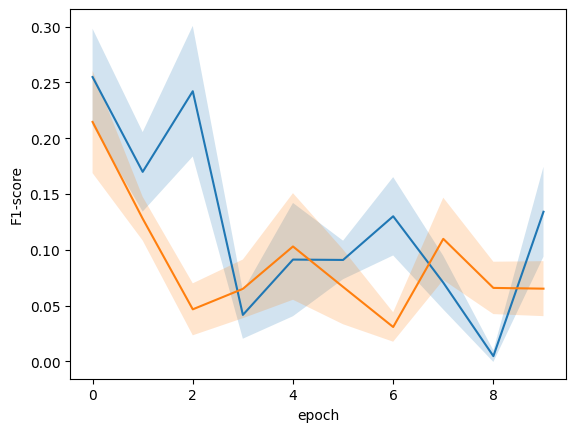

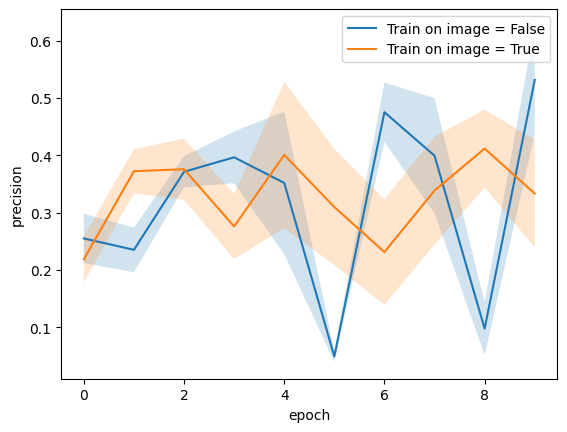

In [25]:
def plot_score_from_report(name):
    
    score_list = ['accuracy', 'precision', 'recall', 'F1-score']
    
    ind = score_list.index(name)
    
    for report in full_report:
    
        score_mean = []
        score_std = []

        for _s_mean, _s_std in zip(report['scores_mean'], report['scores_std']):
            score_mean.append(_s_mean[ind])
            score_std.append(_s_std[ind])

        score_mean = np.array (score_mean)
        score_std = np.array (score_std)

        _label = f'Train on image = {report["train_image_restoration"]}'

        _iter = np.arange(len(score_mean))

        plt.plot (_iter, score_mean, label=_label)
        plt.fill_between(_iter, score_mean - score_std, score_mean + score_std, alpha=0.2)
    
    plt.xlabel('epoch')
    plt.ylabel(name)

plt.figure()
plot_score_from_report ('F1-score')
plt.figure()
plot_score_from_report ('precision')
#     plt.plot(report['loss_training'], label=_label)

plt.legend()

In [53]:
for _m_f in [8, 16, 32, 64]:

    full_report.append(accuracy_objective (m_f=_m_f, n_epochs=5, lr=5.0e-5, train_image_restoration=True))

skip connections in image decoder: False
skip connections in label decoder: True


/srv/data/miniconda3/envs/TomoDev/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


total number of parameters = 1201666


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0781, Accuracy: 27.75%, Test Loss: 0.0672, Test Accuracy: 30.69%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2254, Accuracy: 64.24%, Test Loss: 0.3761, Test Accuracy: 60.87%


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0319, Accuracy: 30.53%, Test Loss: 0.0237, Test Accuracy: 37.98%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2, Loss: 0.1856, Accuracy: 68.11%, Test Loss: 0.2544, Test Accuracy: 62.47%


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0186, Accuracy: 40.22%, Test Loss: 0.0197, Test Accuracy: 44.78%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3, Loss: 0.1652, Accuracy: 70.42%, Test Loss: 0.1522, Test Accuracy: 70.32%


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0134, Accuracy: 53.72%, Test Loss: 0.0141, Test Accuracy: 48.33%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4, Loss: 0.1614, Accuracy: 71.70%, Test Loss: 0.1451, Test Accuracy: 73.82%


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0124, Accuracy: 64.29%, Test Loss: 0.0126, Test Accuracy: 82.78%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5, Loss: 0.1554, Accuracy: 71.78%, Test Loss: 0.1871, Test Accuracy: 69.74%


  0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy:
[0.91613452 0.24762469 0.05815987 0.0617331 ]
skip connections in image decoder: False
skip connections in label decoder: True
total number of parameters = 4791542


  0%|          | 0/426 [00:00<?, ?it/s]

KeyboardInterrupt: 

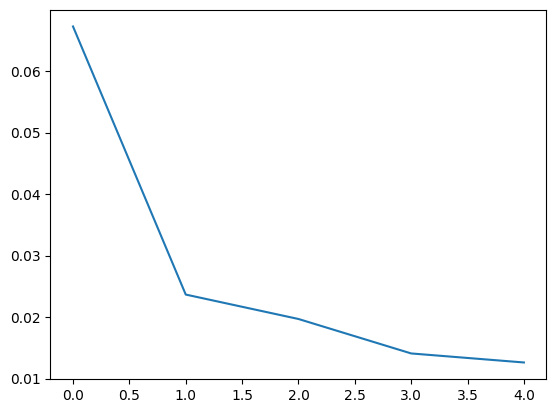

In [54]:
plt.figure()

for report in full_report:
    plt.plot(report['loss_test'])

In [ ]:
n_epochs = 10000

for epoch in range(n_epochs):
    
    #tf.keras.backend.clear_session()

#     for sub_epoch in range(n_sub_epochs):
#         small_label_trainer.one_epoch()
    
    #label_trainer.one_epoch()

    image_trainer.one_epoch()


## Saving/loading model and weights

In [35]:
if save_model:

    dd_model.save_weights(working_dir + 'saved_cnn_model/weights_' + name_str + '.h5')

    np.savez(working_dir + 'saved_cnn_model/loss_' + name_str, np.array(image_trainer.train_loss_list),
                                                                    np.array(image_trainer.test_loss_list),
                                                                    np.array(label_trainer.train_loss_list),
                                                                    np.array(label_trainer.test_loss_list),
                                                                    np.array(label_trainer.train_accuracy_list),
                                                                    np.array(label_trainer.test_accuracy_list))#,
                                                                    #np.array(small_label_trainer.train_loss_list),
                                                                    #np.array(small_label_trainer.test_loss_list))

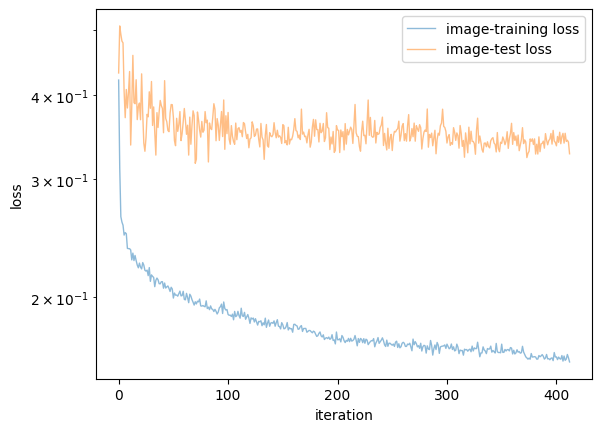

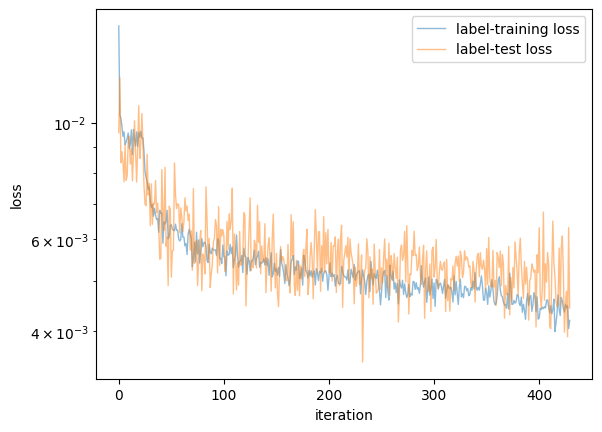

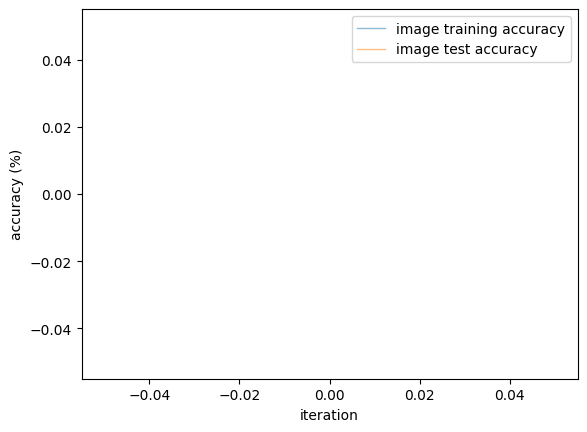

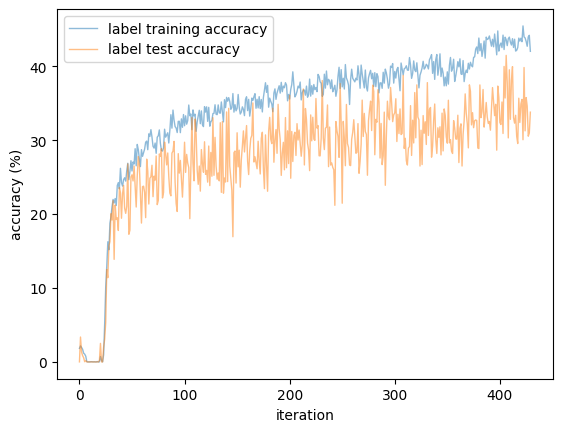

In [34]:
fig = plt.figure()
plt.plot(image_trainer.train_loss_list, alpha=0.5, linewidth=1, label="image-training loss")
plt.plot(image_trainer.test_loss_list, alpha=0.5, linewidth=1, label="image-test loss")
plt.xlabel ('iteration')
plt.ylabel ('loss')
plt.yscale ('log')
plt.legend ()

if save_figures:
    fig.savefig(result_dir + 'image_recovery_loss.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

fig = plt.figure()
plt.plot(label_trainer.train_loss_list, alpha=0.5, linewidth=1, label="label-training loss")
plt.plot(label_trainer.test_loss_list, alpha=0.5, linewidth=1, label="label-test loss")
plt.ylabel ('loss')
plt.xlabel ('iteration')
plt.yscale ('log')
plt.legend ()

if save_figures:
    fig.savefig(result_dir + 'label_loss.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

fig = plt.figure()
plt.plot(100.0 * np.array(image_trainer.train_accuracy_list), alpha=0.5, linewidth=1, label="image training accuracy")
plt.plot(100.0 * np.array(image_trainer.test_accuracy_list), alpha=0.5, linewidth=1, label="image test accuracy")
plt.ylabel ('accuracy (%)')
plt.xlabel ('iteration')
plt.legend ()

if save_figures:
    fig.savefig(result_dir + 'image_accuracy.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)
    
fig = plt.figure()
plt.plot(100.0 * np.array(label_trainer.train_accuracy_list), alpha=0.5, linewidth=1, label="label training accuracy")
plt.plot(100.0 * np.array(label_trainer.test_accuracy_list), alpha=0.5, linewidth=1, label="label test accuracy")
plt.ylabel ('accuracy (%)')
plt.xlabel ('iteration')
plt.legend ()

if save_figures:
    fig.savefig(result_dir + 'label_accuracy.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

In [38]:
n = 0

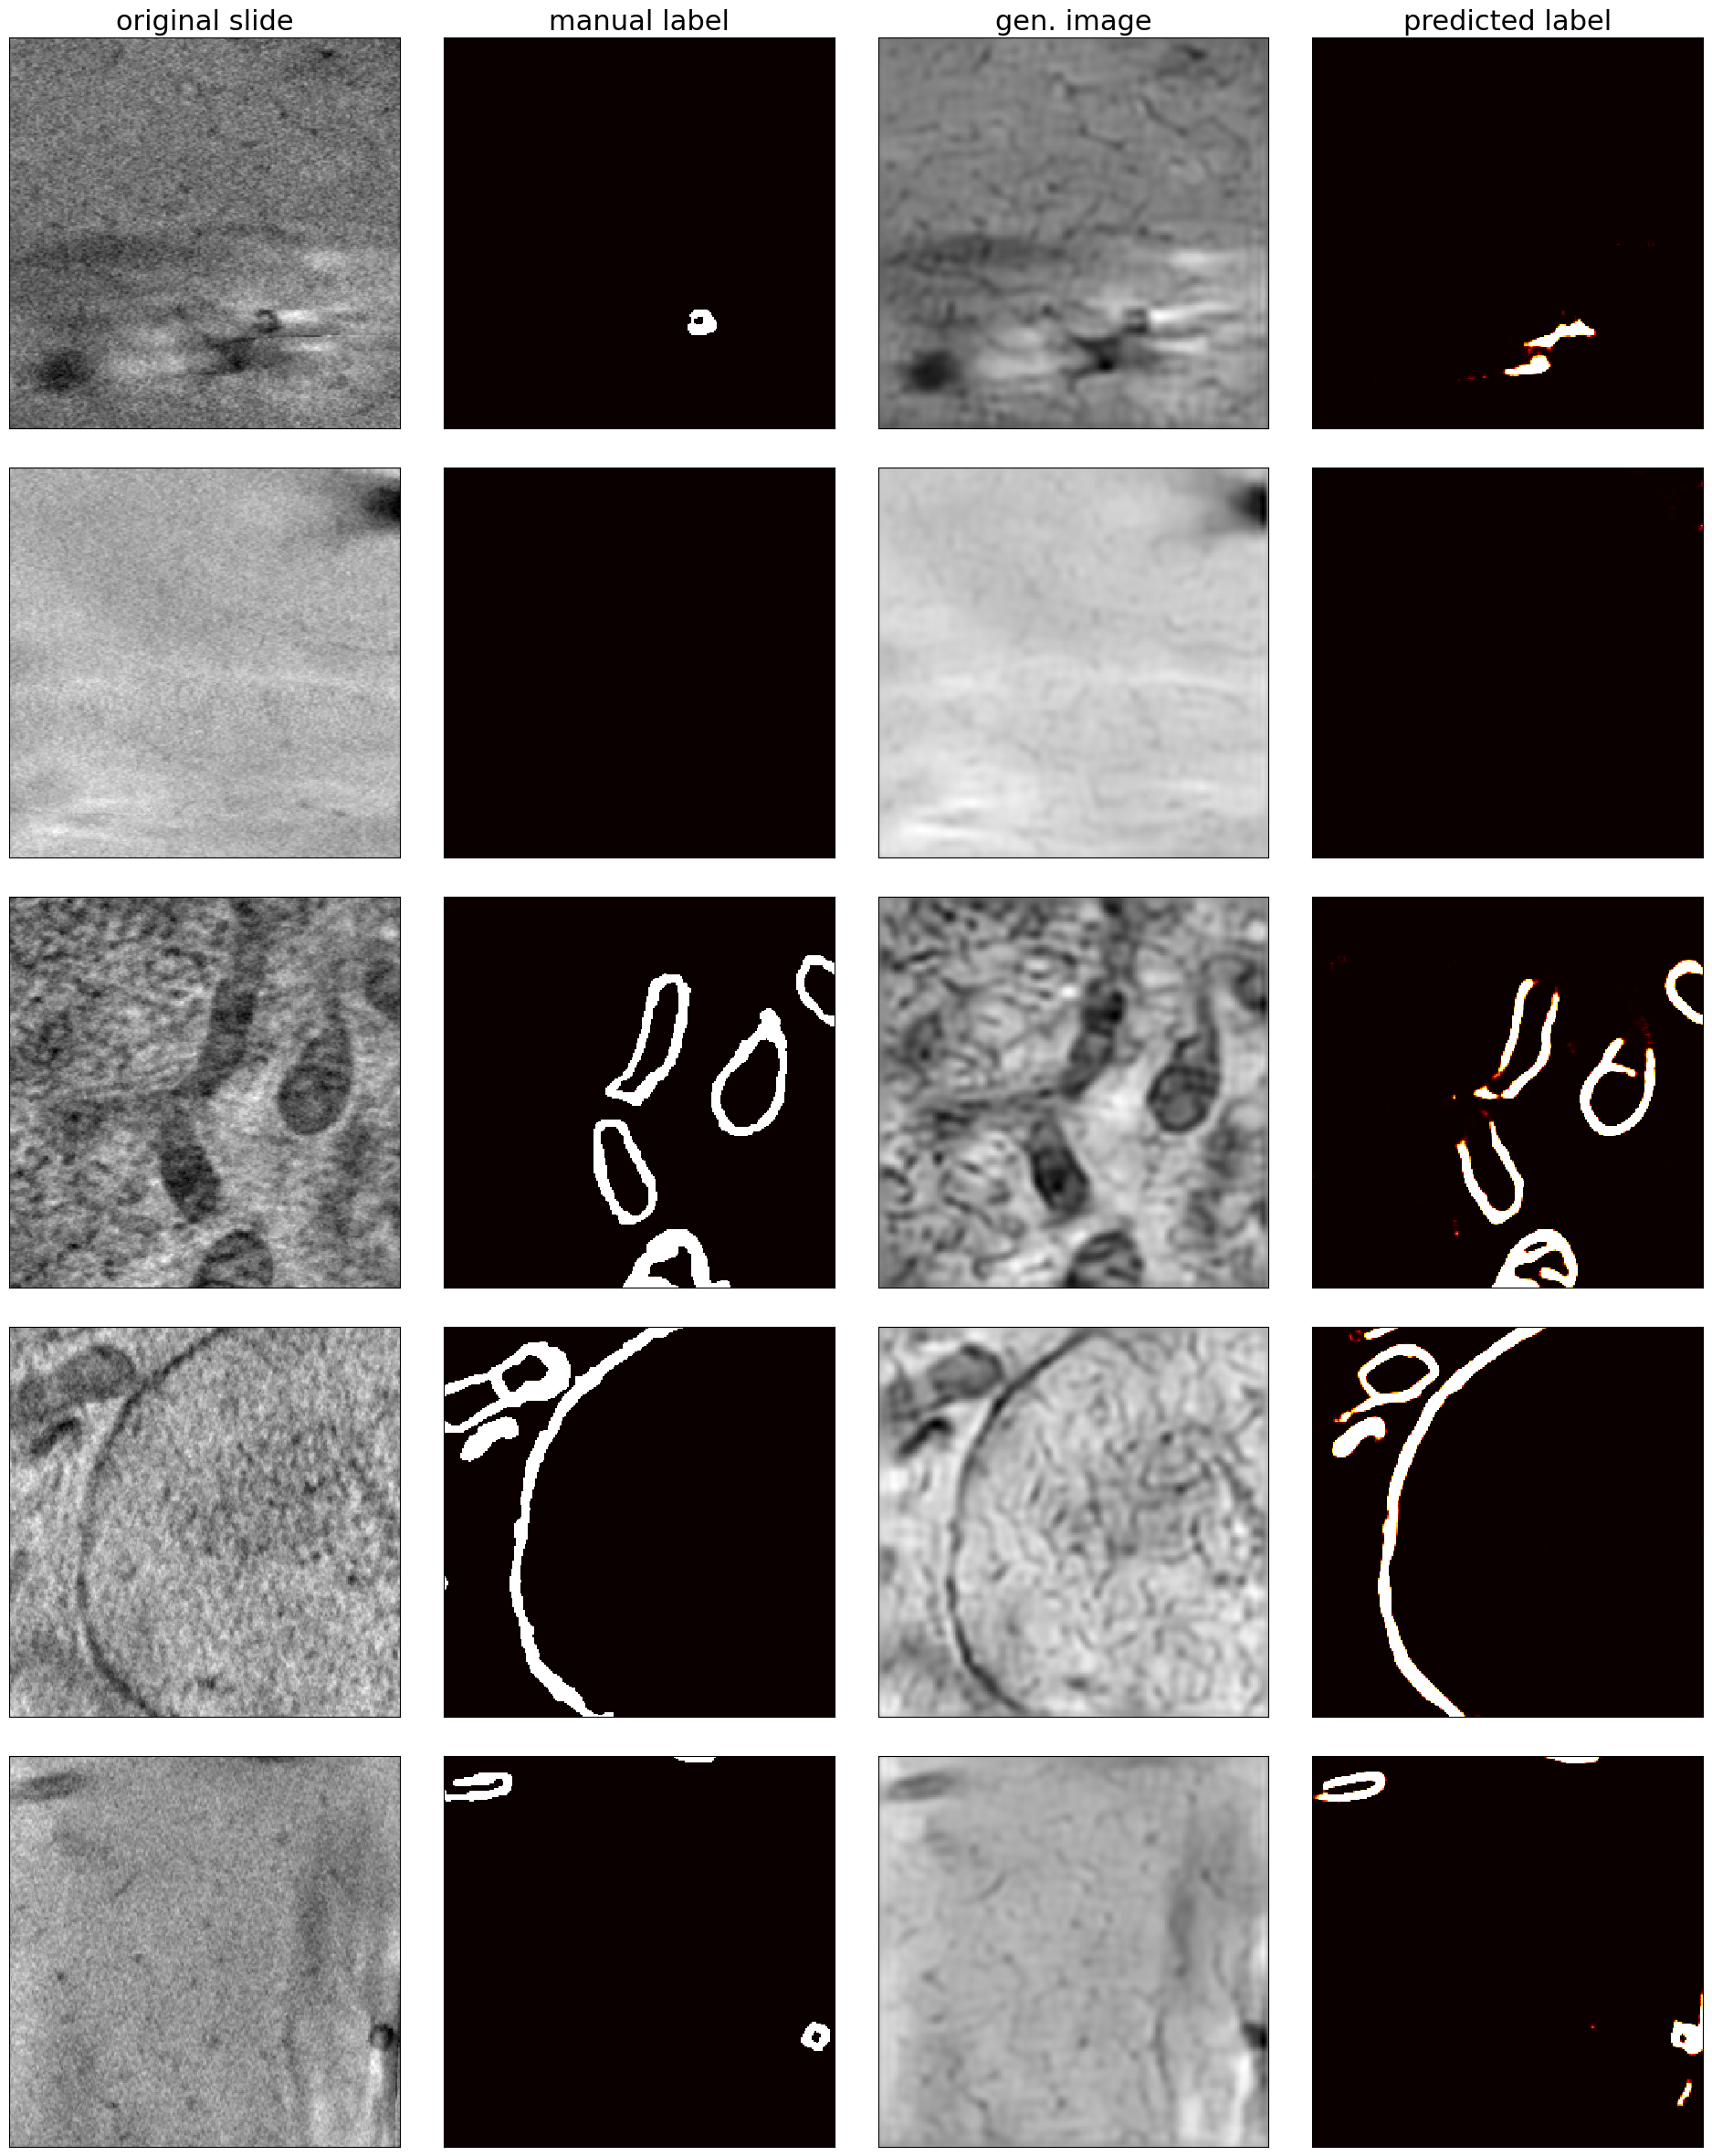

In [39]:
show_image_results(model=dd_model, n_results=5)
        
n += 1

if save_figures:
    fig.savefig(result_dir + 'prediction_' + str(n) + '.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)